# Setup

In [1]:
# Add parent directory to current path. Needed for research imports.
import os.path
import sys
p = os.path.abspath('../..')
if p not in sys.path:
    sys.path.insert(0,p)

# Enable hot reloading
%load_ext autoreload
%autoreload 2


import logging
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import warnings

from experiments.irl.datasets import *
from experiments.irl.experiment_utils import *
from research.irl.fair_irl import *
from research.utils import *


logging.basicConfig(level=logging.INFO)
warnings.filterwarnings('ignore')

sns.set_style('darkgrid')

from IPython.display import display, HTML
display(HTML("<style>.container { width:2000px !important; }</style>"))
pd.set_option('display.max_columns', None)
# pd.set_option('display.max_colwidth', None)

# Prevent long logging lines from wrapping
# display(HTML("<style>div.output_area pre {white-space: pre;}</style>"))
np.set_printoptions(linewidth=np.inf)

# Run experiments

### Boston to Adult

In [555]:
base_exp_info = {
#     'EXPERIMENT_NAME': 'compas_48_hidden',
    'EXPERIMENT_NAME': 'boston_to_adult_jan8_44',
#     'EXPERIMENT_NAME': 'adult_to_boston_jan8_33',
#     'EXPERIMENT_NAME': 'COMPAS_to_boston_jan8_32',
    
    'FEAT_EXP_OBJECTIVE_NAMES': [
        'Acc',
#         'AccPar',
        'DemPar',
        'EqOpp',
#         'FPRPar',
        'TNRPar',
#         'FNRPar',
        'PR_Z0',
        'PR_Z1',
        'NR_Z0',
        'NR_Z1',
        'TPR_Z0',
        'TPR_Z1',
        'TNR_Z0',
        'TNR_Z1',
#         'FPR_Z0',
#         'FPR_Z1',
#         'FNR_Z0',
#         'FNR_Z1',
    ],
    'PERF_MEAS_OBJECTIVE_NAMES': [
        'Acc',
        'DemPar',
        'EqOpp',
        'FPRPar',
        'TNRPar',
        'FNRPar',
#         'PR_Z0',
#         'PR_Z1',
#         'TPR_Z0',
#         'TPR_Z1',
#         'TNR_Z0',
#         'TNR_Z1',
#         'FPR_Z0',
#         'FPR_Z1',
#         'FNR_Z0',
#         'FNR_Z1',
        'PredPar',
        'NegPredPar',
    ],
    
    # Expert demo parameters
#     'DATASET': 'ACSIncome__CA',
#     'TARGET_DATASET': 'ACSIncome__IL',
    
    'EXPERT_CANNOT_PREDICT_IN_TARGET': False,
    'USE_HIDDEN_FEATURES_SOURCE': True,
    'USE_HIDDEN_FEATURES_TARGET': False,
    
    'N_EXPERT_DEMOS': 1,
    'EXPERT_ALGO': None,
    'N_DATASET_SAMPLES': 50_000,
    'MIN_FREQ_FILL_PCT': .3,
    'RESTRICT_Y_ACTION': True,
    # IRL Loop parameters
    'IRL_METHOD': None,
    'METHOD': 'highs',
    # Plotting parameters
    'NOISE_FACTOR': .01,
    'ANNOTATE': True,
    'N_INIT_POLICIES': 3,
    'NON_EXPERT_ALGOS': [
        'OptAccNoisy',
        'HardtDemParNoisy',
        'HardtEqOppNoisy',
#         'HardtFPRNoisy',
#         'HardtTNRNoisy',
#         'Dummy',
#         'DummyNoisy',
    ],
}

base_exp_info['N_TRIALS'] = 3
# base_exp_info['IGNORE_RESULTS_EPSILON'] = .06
base_exp_info['EPSILON'] = .02
base_exp_info['IGNORE_RESULTS_EPSILON'] = .04
base_exp_info['MAX_ITER'] = 40
base_exp_info['ALLOW_NEG_WEIGHTS'] = True
base_exp_info['DOT_WEIGHTS_FEAT_EXP'] = True
base_exp_info['EARLY_STOP_NO_NEW_BEST_ITERS'] = 15

source_states = [
#     'ACSIncome__AL',
#     'ACSIncome__CA',
#     'ACSIncome__FL',
#     'ACSIncome__IL',
#     'ACSIncome__ME',
#     'ACSIncome__NY',
#     'ACSIncome__TX',
#     'ACSIncome__WA',
#     'Adult',
#     'COMPAS',
    'Boston',
]

target_states = [
#     'ACSIncome__AL',
#     'ACSIncome__CA',
#     'ACSIncome__FL',
#     'ACSIncome__IL',
#     'ACSIncome__ME',
#     'ACSIncome__NY',
#     'ACSIncome__TX',
#     'ACSIncome__TX',
    'Adult',
#     'Boston',
#     'COMPAS',
]

### Adult to Boston

In [643]:
base_exp_info = {
#     'EXPERIMENT_NAME': 'compas_48_hidden',
#     'EXPERIMENT_NAME': 'boston_to_adult_jan8_44',
    'EXPERIMENT_NAME': 'adult_to_boston_jan8_44',
#     'EXPERIMENT_NAME': 'COMPAS_to_boston_jan8_32',
    
    'FEAT_EXP_OBJECTIVE_NAMES': [
        'Acc',
#         'AccPar',
        'DemPar',
        'EqOpp',
#         'FPRPar',
        'TNRPar',
#         'FNRPar',
        'PR_Z0',
        'PR_Z1',
        'NR_Z0',
        'NR_Z1',
        'TPR_Z0',
        'TPR_Z1',
        'TNR_Z0',
        'TNR_Z1',
#         'FPR_Z0',
#         'FPR_Z1',
#         'FNR_Z0',
#         'FNR_Z1',
    ],
    'PERF_MEAS_OBJECTIVE_NAMES': [
        'Acc',
        'DemPar',
        'EqOpp',
        'FPRPar',
        'TNRPar',
        'FNRPar',
#         'PR_Z0',
#         'PR_Z1',
#         'TPR_Z0',
#         'TPR_Z1',
#         'TNR_Z0',
#         'TNR_Z1',
#         'FPR_Z0',
#         'FPR_Z1',
#         'FNR_Z0',
#         'FNR_Z1',
        'PredPar',
        'NegPredPar',
    ],
    
    # Expert demo parameters
#     'DATASET': 'ACSIncome__CA',
#     'TARGET_DATASET': 'ACSIncome__IL',
    
    'EXPERT_CANNOT_PREDICT_IN_TARGET': False,
    'USE_HIDDEN_FEATURES_SOURCE': True,
    'USE_HIDDEN_FEATURES_TARGET': False,
    
    'N_EXPERT_DEMOS': 1,
    'EXPERT_ALGO': None,
    'N_DATASET_SAMPLES': 100_000,
    'MIN_FREQ_FILL_PCT': .3,
    'RESTRICT_Y_ACTION': True,
    # IRL Loop parameters
    'IRL_METHOD': None,
    'METHOD': 'highs',
    # Plotting parameters
    'NOISE_FACTOR': .01,
    'ANNOTATE': True,
    'N_INIT_POLICIES': 1,
    'NON_EXPERT_ALGOS': [
        'OptAccNoisy',
#         'HardtDemParNoisy',
#         'HardtEqOppNoisy',
#         'HardtFPRNoisy',
#         'HardtTNRNoisy',
#         'Dummy',
#         'DummyNoisy',
    ],
}

base_exp_info['N_TRIALS'] = 5
# base_exp_info['IGNORE_RESULTS_EPSILON'] = .06
base_exp_info['EPSILON'] = .005
base_exp_info['IGNORE_RESULTS_EPSILON'] = .01
base_exp_info['MAX_ITER'] = 40
base_exp_info['ALLOW_NEG_WEIGHTS'] = True
base_exp_info['DOT_WEIGHTS_FEAT_EXP'] = True
base_exp_info['EARLY_STOP_NO_NEW_BEST_ITERS'] = 15

source_states = [
#     'ACSIncome__AL',
#     'ACSIncome__CA',
#     'ACSIncome__FL',
#     'ACSIncome__IL',
#     'ACSIncome__ME',
#     'ACSIncome__NY',
#     'ACSIncome__TX',
#     'ACSIncome__WA',
    'Adult',
#     'COMPAS',
#     'Boston',
]

target_states = [
#     'ACSIncome__AL',
#     'ACSIncome__CA',
#     'ACSIncome__FL',
#     'ACSIncome__IL',
#     'ACSIncome__ME',
#     'ACSIncome__NY',
#     'ACSIncome__TX',
#     'ACSIncome__TX',
#     'Adult',
    'Boston',
#     'COMPAS',
]

### ACSIncome: State to State MA to MS

In [632]:
base_exp_info = {
#     'EXPERIMENT_NAME': 'compas_48_hidden',
#     'EXPERIMENT_NAME': 'boston_to_adult_jan8_44',
#     'EXPERIMENT_NAME': 'adult_to_boston_jan8_33',
#     'EXPERIMENT_NAME': 'COMPAS_to_boston_jan8_32',
#     'EXPERIMENT_NAME': 'ACSIncome_CA_to_WY_jan8_44',
    'EXPERIMENT_NAME': 'ACSIncome_MA_to_MS_jan8_44',
    
    'FEAT_EXP_OBJECTIVE_NAMES': [
        'Acc',
#         'AccPar',
        'DemPar',
        'EqOpp',
#         'FPRPar',
        'TNRPar',
#         'FNRPar',
        'PR_Z0',
        'PR_Z1',
        'NR_Z0',
        'NR_Z1',
        'TPR_Z0',
        'TPR_Z1',
        'TNR_Z0',
        'TNR_Z1',
#         'FPR_Z0',
#         'FPR_Z1',
#         'FNR_Z0',
#         'FNR_Z1',
    ],
    'PERF_MEAS_OBJECTIVE_NAMES': [
        'Acc',
        'DemPar',
        'EqOpp',
        'FPRPar',
        'TNRPar',
        'FNRPar',
#         'PR_Z0',
#         'PR_Z1',
#         'TPR_Z0',
#         'TPR_Z1',
#         'TNR_Z0',
#         'TNR_Z1',
#         'FPR_Z0',
#         'FPR_Z1',
#         'FNR_Z0',
#         'FNR_Z1',
        'PredPar',
        'NegPredPar',
    ],
    
    # Expert demo parameters
#     'DATASET': 'ACSIncome__CA',
#     'TARGET_DATASET': 'ACSIncome__IL',
    
    'EXPERT_CANNOT_PREDICT_IN_TARGET': False,
    'USE_HIDDEN_FEATURES_SOURCE': True,
    'USE_HIDDEN_FEATURES_TARGET': False,
    
    'N_EXPERT_DEMOS': 1,
    'EXPERT_ALGO': None,
    'N_DATASET_SAMPLES': 40_000,
    'MIN_FREQ_FILL_PCT': .35,
    'RESTRICT_Y_ACTION': True,
    # IRL Loop parameters
    'IRL_METHOD': None,
    'METHOD': 'highs',
    # Plotting parameters
    'NOISE_FACTOR': .01,
    'ANNOTATE': True,
    'N_INIT_POLICIES': 1,
    'NON_EXPERT_ALGOS': [
        'OptAccNoisy',
#         'HardtDemParNoisy',
#         'HardtEqOppNoisy',
#         'HardtFPRNoisy',
#         'HardtTNRNoisy',
#         'Dummy',
#         'DummyNoisy',
    ],
}

base_exp_info['N_TRIALS'] = 2
# base_exp_info['IGNORE_RESULTS_EPSILON'] = .06
base_exp_info['EPSILON'] = .025
base_exp_info['IGNORE_RESULTS_EPSILON'] = .06
base_exp_info['MAX_ITER'] = 40
base_exp_info['ALLOW_NEG_WEIGHTS'] = True
base_exp_info['DOT_WEIGHTS_FEAT_EXP'] = True
base_exp_info['EARLY_STOP_NO_NEW_BEST_ITERS'] = 15

source_states = [
#     'ACSIncome__AL',
#     'ACSIncome__CA',
#     'ACSIncome__FL',
#     'ACSIncome__IL',
#     'ACSIncome__ME',
#     'ACSIncome__NY',
#     'ACSIncome__TX',
    'ACSIncome__MA',
#     'Adult',
#     'COMPAS',
#     'Boston',
]

target_states = [
#     'ACSIncome__AL',
#     'ACSIncome__CA',
#     'ACSIncome__FL',
#     'ACSIncome__IL',
#     'ACSIncome__ME',
#     'ACSIncome__NY',
#     'ACSIncome__TX',
    'ACSIncome__MS',
#     'Adult',
#     'Boston',
#     'COMPAS',
]

### ACSIncome: State to State MS to MA

In [684]:
base_exp_info = {
#     'EXPERIMENT_NAME': 'compas_48_hidden',
#     'EXPERIMENT_NAME': 'boston_to_adult_jan8_44',
#     'EXPERIMENT_NAME': 'adult_to_boston_jan8_33',
#     'EXPERIMENT_NAME': 'COMPAS_to_boston_jan8_32',
#     'EXPERIMENT_NAME': 'ACSIncome_CA_to_WY_jan8_44',
    'EXPERIMENT_NAME': 'ACSIncome_MS_to_MA_jan8_44',
    
    'FEAT_EXP_OBJECTIVE_NAMES': [
        'Acc',
#         'AccPar',
        'DemPar',
        'EqOpp',
#         'FPRPar',
        'TNRPar',
#         'FNRPar',
        'PR_Z0',
        'PR_Z1',
        'NR_Z0',
        'NR_Z1',
        'TPR_Z0',
        'TPR_Z1',
        'TNR_Z0',
        'TNR_Z1',
#         'FPR_Z0',
#         'FPR_Z1',
#         'FNR_Z0',
#         'FNR_Z1',
    ],
    'PERF_MEAS_OBJECTIVE_NAMES': [
        'Acc',
        'DemPar',
        'EqOpp',
        'FPRPar',
        'TNRPar',
        'FNRPar',
#         'PR_Z0',
#         'PR_Z1',
#         'TPR_Z0',
#         'TPR_Z1',
#         'TNR_Z0',
#         'TNR_Z1',
#         'FPR_Z0',
#         'FPR_Z1',
#         'FNR_Z0',
#         'FNR_Z1',
        'PredPar',
        'NegPredPar',
    ],
    
    # Expert demo parameters
#     'DATASET': 'ACSIncome__CA',
#     'TARGET_DATASET': 'ACSIncome__IL',
    
    'EXPERT_CANNOT_PREDICT_IN_TARGET': False,
    'USE_HIDDEN_FEATURES_SOURCE': True,
    'USE_HIDDEN_FEATURES_TARGET': False,
    
    'N_EXPERT_DEMOS': 1,
    'EXPERT_ALGO': None,
    'N_DATASET_SAMPLES': 40_000,
    'MIN_FREQ_FILL_PCT': .35,
    'RESTRICT_Y_ACTION': True,
    # IRL Loop parameters
    'IRL_METHOD': None,
    'METHOD': 'highs',
    # Plotting parameters
    'NOISE_FACTOR': .01,
    'ANNOTATE': True,
    'N_INIT_POLICIES': 1,
    'NON_EXPERT_ALGOS': [
        'OptAccNoisy',
#         'HardtDemParNoisy',
#         'HardtEqOppNoisy',
#         'HardtFPRNoisy',
#         'HardtTNRNoisy',
#         'Dummy',
#         'DummyNoisy',
    ],
}

base_exp_info['N_TRIALS'] = 3
# base_exp_info['IGNORE_RESULTS_EPSILON'] = .06
base_exp_info['EPSILON'] = .025
base_exp_info['IGNORE_RESULTS_EPSILON'] = .06
base_exp_info['MAX_ITER'] = 40
base_exp_info['ALLOW_NEG_WEIGHTS'] = True
base_exp_info['DOT_WEIGHTS_FEAT_EXP'] = True
base_exp_info['EARLY_STOP_NO_NEW_BEST_ITERS'] = 15

source_states = [
#     'ACSIncome__AL',
#     'ACSIncome__CA',
#     'ACSIncome__FL',
#     'ACSIncome__IL',
#     'ACSIncome__ME',
#     'ACSIncome__NY',
#     'ACSIncome__TX',
    'ACSIncome__MS',
#     'Adult',
#     'COMPAS',
#     'Boston',
]

target_states = [
#     'ACSIncome__AL',
#     'ACSIncome__CA',
#     'ACSIncome__FL',
#     'ACSIncome__IL',
#     'ACSIncome__ME',
#     'ACSIncome__NY',
#     'ACSIncome__TX',
    'ACSIncome__MA',
#     'Adult',
#     'Boston',
#     'COMPAS',
]

### Set Experts & Run

In [685]:
expert_algos = [
#     'OptAcc',
    'HardtDemPar',
    'HardtEqOpp',
#     'HardtTNRPar'
#     'HardtFPRPar',
#     'HardtFNRPar',
    'HardtEqOdds',
    'BoundedGroupLoss',
#     'COMPAS',
]
        
experiments = []
for expert_algo in expert_algos:
    for source_dataset in source_states:
        for target_dataset in target_states:
            experiments.append({
                'EXPERT_ALGO': expert_algo,
                'IRL_METHOD': 'FairIRL',
                'DATASET': source_dataset,
                'TARGET_DATASET': target_dataset,
            })

In [686]:
# experiments = [
#     {
#         'EXPERT_ALGO': 'OptAcc',
#         'IRL_METHOD': 'FairIRL',
#     },
#     {
#         'EXPERT_ALGO': 'HardtDemPar',
#         'IRL_METHOD': 'FairIRL',
#     },
#     {
#         'EXPERT_ALGO': 'HardtEqOpp',
#         'IRL_METHOD': 'FairIRL',
#     },
# #     {
# #         'EXPERT_ALGO': 'COMPAS',
# #         'IRL_METHOD': 'FairIRL',
# #         'USE_HIDDEN_FEATURES_SOURCE': True,
# #         'USE_HIDDEN_FEATURES_TARGET': False,
# #         'EXPERT_CANNOT_PREDICT_IN_TARGET': True,
# #     },
    
    
# #     {
# #         'EXPERT_ALGO': 'OptAcc',
# #         'IRL_METHOD': 'FairIRLFO',
# #     },
# #     {
# #         'EXPERT_ALGO': 'HardtDemPar',
# #         'IRL_METHOD': 'FairIRLFO',
# #     },
# #     {
# #         'EXPERT_ALGO': 'HardtEqOpp',
# #         'IRL_METHOD': 'FairIRLFO',
# #     },
# ]

In [687]:
# for exp_i, experiment in enumerate(experiments):
#     logging.info('\n\n')
#     logging.info(f"EXPERIMENT {exp_i+1}/{len(experiments)}")
    
#     exp_info = dict(base_exp_info)
    
#     for k in experiment:
#         exp_info[k] = experiment[k]
        
#     run_experiment(exp_info)

In [688]:
exp_info = dict(base_exp_info)

In [689]:
for exp_i, experiment in enumerate(experiments):
    logging.info('\n\n')
    logging.info(f"EXPERIMENT {exp_i+1}/{len(experiments)}")
    
    exp_info = dict(base_exp_info)
    
    for k in experiment:
        exp_info[k] = experiment[k]
        
    source_X, source_y, source_feature_types = generate_dataset(
        experiment['DATASET'],
        n_samples=exp_info['N_DATASET_SAMPLES'],
    )

    target_X, target_y, target_feature_types = generate_dataset(
        experiment['TARGET_DATASET'],
        n_samples=exp_info['N_DATASET_SAMPLES'],
    )

    for f in source_feature_types['categoric']:
        source_X[f] = source_X[f].astype(str)

    for f in target_feature_types['categoric']:
        target_X[f] = target_X[f].astype(str)
                   
    source_X_cols = (
        source_feature_types['boolean']
        + source_feature_types['categoric']
        + source_feature_types['continuous']
    )
    
    if exp_info['USE_HIDDEN_FEATURES_SOURCE']:
        source_X_cols += source_feature_types['hidden']
    _source_X = source_X[source_X_cols]
    
    
    target_X_cols = (
        target_feature_types['boolean']
        + target_feature_types['categoric']
        + target_feature_types['continuous']
    )
    if exp_info['USE_HIDDEN_FEATURES_TARGET']:
        target_X_cols += target_feature_types['hidden']
    _target_X = target_X[target_X_cols]
    
    source_beh_clone_clf = run_behavior_clone_experiment(
        exp_info,
        source_X=_source_X,
        source_y=source_y,
        source_feature_types=source_feature_types,
        target_X=_target_X,
        target_y=target_y,
        target_feature_types=target_feature_types,
    )

    source_clf_pol, target_clf_pol = run_experiment(
        exp_info,
        source_X=_source_X,
        source_y=source_y,
        source_feature_types=source_feature_types,
        target_X=_target_X,
        target_y=target_y,
        target_feature_types=target_feature_types,
    )

INFO:root:


INFO:root:EXPERIMENT 1/4
INFO:root:

BEHAVIOR CLONING TRIAL 0

INFO:root:muE:
[[0.62989073 0.99148836 0.9310203  0.82889839 0.68131224 0.6728006  0.31868776 0.3271994  0.74781086 0.81679056 0.35211268 0.52321429]]
INFO:root:muE_hold:
[[0.62508809 0.9797699  0.97452011 0.85082485 0.59122402 0.57099391 0.40877598 0.42900609 0.6875     0.71297989 0.4567474  0.60592255]]
INFO:root:muE_perf_hold:
[[0.62508809 0.9797699  0.97452011 0.85082485 0.85082485 0.97452011 0.69400117 0.8830789 ]]
INFO:root:muL:
[[0.6094466  0.74254587 0.79459685 0.77713949 0.32006822 0.57752235 0.67993178 0.42247765 0.44618056 0.65158371 0.74133559 0.51847507]]
INFO:root:		 muL[0] = [0.618 0.848 0.943 0.675 0.824 0.673 0.176 0.327 0.88  0.823 0.204 0.528]


,Acc,DemPar,EqOpp,TNRPar,PR_Z0,PR_Z1,NR_Z0,NR_Z1,TPR_Z0,TPR_Z1,TNR_Z0,TNR_Z1,is_expert,muL_best_Acc,muL_hold_Acc,muL_best_hold_Acc,muL_best_DemPar,muL_hold_DemPar,muL_best_hold_DemPar,muL_best_EqOpp,muL_hold_EqOpp,muL_best_hold_EqOpp,muL_best_TNRPar,muL_hold_TNRPar,muL_best_hold_TNRPar,muL_best_PR_Z0,muL_hold_PR_Z0,muL_best_hold_PR_Z0,muL_best_PR_Z1,muL_hold_PR_Z1,muL_best_hold_PR_Z1,muL_best_NR_Z0,muL_hold_NR_Z0,muL_best_hold_NR_Z0,muL_best_NR_Z1,muL_hold_NR_Z1,muL_best_hold_NR_Z1,muL_best_TPR_Z0,muL_hold_TPR_Z0,muL_best_hold_TPR_Z0,muL_best_TPR_Z1,muL_hold_TPR_Z1,muL_best_hold_TPR_Z1,muL_best_TNR_Z0,muL_hold_TNR_Z0,muL_best_hold_TNR_Z0,muL_best_TNR_Z1,muL_hold_TNR_Z1,muL_best_hold_TNR_Z1,muL_perf_best_hold_Acc,muL_perf_best_hold_DemPar,muL_perf_best_hold_EqOpp,muL_perf_best_hold_FPRPar,muL_perf_best_hold_TNRPar,muL_perf_best_hold_FNRPar,muL_perf_best_hold_PredPar,muL_perf_best_hold_NegPredPar,is_init_policy,learn_idx,Acc_weight,DemPar_weight,EqOpp_weight,TNRPar_weight,PR_Z0_weight,PR_Z1_weight,NR_Z0_weight,NR_Z1_weight,TPR_Z0_weight,TPR_Z1_weight,TNR_Z0_weight,TNR_Z1_weight,t,t_hold,mu_delta_l2norm,mu_delta_l2norm_hold
0,0.630,0.991,0.931,0.829,0.681,0.673,0.319,0.327,0.748,0.817,0.352,0.523,1,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.00,0.00,0.00,0.000,0.000,0.000,0.000,0.00,0.00,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,inf,inf,0.0,0.0
1,0.609,0.743,0.795,0.777,0.320,0.578,0.680,0.422,0.446,0.652,0.741,0.518,0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.00,0.00,0.00,0.000,0.000,0.000,0.000,0.00,0.00,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,inf,inf,0.0,0.0
2,0.618,0.848,0.943,0.675,0.824,0.673,0.176,0.327,0.880,0.823,0.204,0.528,0,0.618,0.614,0.614,0.848,0.862,0.862,0.943,0.999,0.999,0.675,0.669,0.669,0.824,0.824,0.824,0.673,0.686,0.686,0.176,0.176,0.176,0.327,0.314,0.314,0.88,0.85,0.85,0.823,0.848,0.848,0.204,0.19,0.19,0.528,0.521,0.521,0.614,0.862,0.999,0.669,0.669,0.999,0.664,0.976,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


INFO:root:target domain muL = [0.614 0.7   0.77  0.592 0.868 0.567 0.132 0.433 0.931 0.701 0.174 0.581]
INFO:root:target domain muE = [0.651 0.986 0.918 0.895 0.625 0.639 0.375 0.361 0.714 0.796 0.432 0.537]
INFO:root:target domain muL_hold = [0.615 0.712 0.794 0.595 0.856 0.568 0.144 0.432 0.913 0.706 0.179 0.584]
INFO:root:target domain muL_perf_hold = [0.615 0.712 0.794 0.595 0.595 0.794 0.757 0.876]
INFO:root:

BEHAVIOR CLONING TRIAL 1

INFO:root:muE:
[[0.63077194 0.99715283 0.90940299 0.83561403 0.68184438 0.68469155 0.31815562 0.31530845 0.7456446  0.83624161 0.34969854 0.51408451]]
INFO:root:muE_hold:
[[0.6286117  0.98986106 0.92584337 0.87446605 0.66075949 0.67089844 0.33924051 0.32910156 0.72789116 0.80204778 0.37903226 0.50456621]]
INFO:root:muE_perf_hold:
[[0.6286117  0.98986106 0.92584337 0.87446605 0.87446605 0.92584337 0.72582777 0.95429381]]
INFO:root:muL:
[[0.6011632  0.73428799 0.7867383  0.75607036 0.3183882  0.5841002  0.6816118  0.4158998  0.43471338 0.64797508 0.74

,Acc,DemPar,EqOpp,TNRPar,PR_Z0,PR_Z1,NR_Z0,NR_Z1,TPR_Z0,TPR_Z1,TNR_Z0,TNR_Z1,is_expert,muL_best_Acc,muL_hold_Acc,muL_best_hold_Acc,muL_best_DemPar,muL_hold_DemPar,muL_best_hold_DemPar,muL_best_EqOpp,muL_hold_EqOpp,muL_best_hold_EqOpp,muL_best_TNRPar,muL_hold_TNRPar,muL_best_hold_TNRPar,muL_best_PR_Z0,muL_hold_PR_Z0,muL_best_hold_PR_Z0,muL_best_PR_Z1,muL_hold_PR_Z1,muL_best_hold_PR_Z1,muL_best_NR_Z0,muL_hold_NR_Z0,muL_best_hold_NR_Z0,muL_best_NR_Z1,muL_hold_NR_Z1,muL_best_hold_NR_Z1,muL_best_TPR_Z0,muL_hold_TPR_Z0,muL_best_hold_TPR_Z0,muL_best_TPR_Z1,muL_hold_TPR_Z1,muL_best_hold_TPR_Z1,muL_best_TNR_Z0,muL_hold_TNR_Z0,muL_best_hold_TNR_Z0,muL_best_TNR_Z1,muL_hold_TNR_Z1,muL_best_hold_TNR_Z1,muL_perf_best_hold_Acc,muL_perf_best_hold_DemPar,muL_perf_best_hold_EqOpp,muL_perf_best_hold_FPRPar,muL_perf_best_hold_TNRPar,muL_perf_best_hold_FNRPar,muL_perf_best_hold_PredPar,muL_perf_best_hold_NegPredPar,is_init_policy,learn_idx,Acc_weight,DemPar_weight,EqOpp_weight,TNRPar_weight,PR_Z0_weight,PR_Z1_weight,NR_Z0_weight,NR_Z1_weight,TPR_Z0_weight,TPR_Z1_weight,TNR_Z0_weight,TNR_Z1_weight,t,t_hold,mu_delta_l2norm,mu_delta_l2norm_hold
0,0.631,0.997,0.909,0.836,0.682,0.685,0.318,0.315,0.746,0.836,0.350,0.514,1,0.00,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.00,0.000,0.000,0.000,0.000,0.000,0.00,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.00,0.000,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,inf,inf,0.0,0.0
1,0.601,0.734,0.787,0.756,0.318,0.584,0.682,0.416,0.435,0.648,0.746,0.502,0,0.00,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.00,0.000,0.000,0.000,0.000,0.000,0.00,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.00,0.000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,inf,inf,0.0,0.0
2,0.620,0.811,0.887,0.647,0.869,0.680,0.131,0.320,0.948,0.834,0.171,0.523,0,0.62,0.606,0.606,0.811,0.806,0.806,0.887,0.893,0.893,0.647,0.647,0.647,0.869,0.875,0.875,0.68,0.681,0.681,0.131,0.125,0.125,0.32,0.319,0.319,0.948,0.929,0.929,0.834,0.822,0.822,0.171,0.152,0.152,0.523,0.505,0.505,0.606,0.806,0.893,0.647,0.647,0.893,0.67,0.873,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


INFO:root:target domain muL = [0.622 0.776 0.837 0.676 0.801 0.577 0.199 0.423 0.877 0.715 0.249 0.574]
INFO:root:target domain muE = [0.659 0.975 0.943 0.932 0.605 0.631 0.395 0.369 0.734 0.792 0.479 0.547]
INFO:root:target domain muL_hold = [0.622 0.787 0.841 0.684 0.793 0.58  0.207 0.42  0.878 0.718 0.258 0.574]
INFO:root:target domain muL_perf_hold = [0.622 0.787 0.841 0.684 0.684 0.841 0.765 0.871]
INFO:root:

BEHAVIOR CLONING TRIAL 2

INFO:root:muE:
[[0.63870286 0.99459648 0.96853015 0.85746508 0.66965352 0.66425    0.33034648 0.33575    0.78136201 0.81283186 0.38620072 0.52873563]]
INFO:root:muE_hold:
[[0.64975335 0.9815327  0.92917026 0.85083464 0.6713615  0.6898288  0.3286385  0.3101712  0.76760563 0.83843537 0.37676056 0.52592593]]
INFO:root:muE_perf_hold:
[[0.64975335 0.9815327  0.92917026 0.85083464 0.85083464 0.92917026 0.66141085 0.92727273]]
INFO:root:muL:
[[0.60451181 0.72924307 0.78372657 0.752046   0.31278802 0.58354495 0.68721198 0.41645505 0.43464052 0.65091395 0.75

,Acc,DemPar,EqOpp,TNRPar,PR_Z0,PR_Z1,NR_Z0,NR_Z1,TPR_Z0,TPR_Z1,TNR_Z0,TNR_Z1,is_expert,muL_best_Acc,muL_hold_Acc,muL_best_hold_Acc,muL_best_DemPar,muL_hold_DemPar,muL_best_hold_DemPar,muL_best_EqOpp,muL_hold_EqOpp,muL_best_hold_EqOpp,muL_best_TNRPar,muL_hold_TNRPar,muL_best_hold_TNRPar,muL_best_PR_Z0,muL_hold_PR_Z0,muL_best_hold_PR_Z0,muL_best_PR_Z1,muL_hold_PR_Z1,muL_best_hold_PR_Z1,muL_best_NR_Z0,muL_hold_NR_Z0,muL_best_hold_NR_Z0,muL_best_NR_Z1,muL_hold_NR_Z1,muL_best_hold_NR_Z1,muL_best_TPR_Z0,muL_hold_TPR_Z0,muL_best_hold_TPR_Z0,muL_best_TPR_Z1,muL_hold_TPR_Z1,muL_best_hold_TPR_Z1,muL_best_TNR_Z0,muL_hold_TNR_Z0,muL_best_hold_TNR_Z0,muL_best_TNR_Z1,muL_hold_TNR_Z1,muL_best_hold_TNR_Z1,muL_perf_best_hold_Acc,muL_perf_best_hold_DemPar,muL_perf_best_hold_EqOpp,muL_perf_best_hold_FPRPar,muL_perf_best_hold_TNRPar,muL_perf_best_hold_FNRPar,muL_perf_best_hold_PredPar,muL_perf_best_hold_NegPredPar,is_init_policy,learn_idx,Acc_weight,DemPar_weight,EqOpp_weight,TNRPar_weight,PR_Z0_weight,PR_Z1_weight,NR_Z0_weight,NR_Z1_weight,TPR_Z0_weight,TPR_Z1_weight,TNR_Z0_weight,TNR_Z1_weight,t,t_hold,mu_delta_l2norm,mu_delta_l2norm_hold
0,0.639,0.995,0.969,0.857,0.670,0.664,0.330,0.336,0.781,0.813,0.386,0.529,1,0.000,0.000,0.000,0.00,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.00,0.00,0.00,0.000,0.00,0.00,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,inf,inf,0.0,0.0
1,0.605,0.729,0.784,0.752,0.313,0.584,0.687,0.416,0.435,0.651,0.754,0.506,0,0.000,0.000,0.000,0.00,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.00,0.00,0.00,0.000,0.00,0.00,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,inf,inf,0.0,0.0
2,0.609,0.820,0.937,0.638,0.848,0.668,0.152,0.332,0.883,0.820,0.169,0.531,0,0.609,0.623,0.623,0.82,0.843,0.843,0.937,0.975,0.975,0.638,0.637,0.637,0.848,0.825,0.825,0.668,0.669,0.669,0.152,0.175,0.175,0.332,0.331,0.331,0.883,0.855,0.855,0.82,0.83,0.83,0.169,0.19,0.19,0.531,0.553,0.553,0.623,0.843,0.975,0.637,0.637,0.975,0.636,0.987,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


INFO:root:target domain muL = [0.618 0.846 0.916 0.737 0.722 0.569 0.278 0.431 0.787 0.703 0.317 0.58 ]
INFO:root:target domain muE = [0.639 0.977 0.955 0.861 0.668 0.645 0.332 0.355 0.751 0.797 0.382 0.521]
INFO:root:target domain muL_hold = [0.619 0.831 0.927 0.707 0.735 0.566 0.265 0.434 0.776 0.703 0.292 0.585]
INFO:root:target domain muL_perf_hold = [0.619 0.831 0.927 0.707 0.707 0.927 0.767 0.976]
INFO:root:exp_info: {'EXPERIMENT_NAME': 'ACSIncome_MS_to_MA_jan8_44', 'FEAT_EXP_OBJECTIVE_NAMES': ['Acc', 'DemPar', 'EqOpp', 'TNRPar', 'PR_Z0', 'PR_Z1', 'NR_Z0', 'NR_Z1', 'TPR_Z0', 'TPR_Z1', 'TNR_Z0', 'TNR_Z1'], 'PERF_MEAS_OBJECTIVE_NAMES': ['Acc', 'DemPar', 'EqOpp', 'FPRPar', 'TNRPar', 'FNRPar', 'PredPar', 'NegPredPar'], 'EXPERT_CANNOT_PREDICT_IN_TARGET': False, 'USE_HIDDEN_FEATURES_SOURCE': True, 'USE_HIDDEN_FEATURES_TARGET': False, 'N_EXPERT_DEMOS': 1, 'EXPERT_ALGO': 'HardtDemPar', 'N_DATASET_SAMPLES': 40000, 'MIN_FREQ_FILL_PCT': 0.35, 'RESTRICT_Y_ACTION': True, 'IRL_METHOD': 'FairIR

,Acc,DemPar,EqOpp,TNRPar,PR_Z0,PR_Z1,NR_Z0,NR_Z1,TPR_Z0,TPR_Z1,TNR_Z0,TNR_Z1,is_expert,muL_best_Acc,muL_hold_Acc,muL_best_hold_Acc,muL_best_DemPar,muL_hold_DemPar,muL_best_hold_DemPar,muL_best_EqOpp,muL_hold_EqOpp,muL_best_hold_EqOpp,muL_best_TNRPar,muL_hold_TNRPar,muL_best_hold_TNRPar,muL_best_PR_Z0,muL_hold_PR_Z0,muL_best_hold_PR_Z0,muL_best_PR_Z1,muL_hold_PR_Z1,muL_best_hold_PR_Z1,muL_best_NR_Z0,muL_hold_NR_Z0,muL_best_hold_NR_Z0,muL_best_NR_Z1,muL_hold_NR_Z1,muL_best_hold_NR_Z1,muL_best_TPR_Z0,muL_hold_TPR_Z0,muL_best_hold_TPR_Z0,muL_best_TPR_Z1,muL_hold_TPR_Z1,muL_best_hold_TPR_Z1,muL_best_TNR_Z0,muL_hold_TNR_Z0,muL_best_hold_TNR_Z0,muL_best_TNR_Z1,muL_hold_TNR_Z1,muL_best_hold_TNR_Z1,muL_perf_best_hold_Acc,muL_perf_best_hold_DemPar,muL_perf_best_hold_EqOpp,muL_perf_best_hold_FPRPar,muL_perf_best_hold_TNRPar,muL_perf_best_hold_FNRPar,muL_perf_best_hold_PredPar,muL_perf_best_hold_NegPredPar,is_init_policy,learn_idx,Acc_weight,DemPar_weight,EqOpp_weight,TNRPar_weight,PR_Z0_weight,PR_Z1_weight,NR_Z0_weight,NR_Z1_weight,TPR_Z0_weight,TPR_Z1_weight,TNR_Z0_weight,TNR_Z1_weight,t,t_hold,mu_delta_l2norm,mu_delta_l2norm_hold
0,0.633,0.978,0.913,0.869,0.665,0.687,0.335,0.313,0.740,0.826,0.374,0.506,1,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0,-1.0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,inf,inf,0.0,0.0
1,0.610,0.753,0.830,0.773,0.335,0.582,0.665,0.418,0.480,0.650,0.739,0.512,0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.0,0.0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,inf,inf,0.0,0.0
2,0.502,1.000,1.000,1.000,1.000,1.000,0.000,0.000,1.000,1.000,0.000,0.000,0,0.502,0.493,0.493,1.000,0.998,0.998,1.000,0.998,0.998,1.000,0.998,0.998,1.000,0.998,0.998,1.000,1.000,1.000,0.000,0.002,0.002,0.000,0.000,0.000,1.000,0.998,0.998,1.000,1.000,1.000,0.000,0.002,0.002,0.000,0.001,0.001,0.493,0.998,0.998,0.998,0.998,0.998,0.799,0.667,0.0,1.0,0.011,0.107,0.039,0.046,0.157,0.050,-0.157,-0.050,0.123,0.084,-0.173,-0.003,0.257,0.255,0.0,0.0
3,0.435,0.071,0.107,0.022,1.000,0.071,0.000,0.929,1.000,0.107,0.000,0.978,0,0.435,0.453,0.453,0.071,0.069,0.069,0.107,0.106,0.106,0.022,0.023,0.023,1.000,0.998,0.998,0.071,0.066,0.066,0.000,0.002,0.002,0.929,0.934,0.934,1.000,0.998,0.998,0.107,0.104,0.104,0.000,0.002,0.002,0.978,0.979,0.979,0.453,0.069,0.106,0.023,0.023,0.106,0.490,0.803,0.0,2.0,0.088,0.156,0.015,0.001,0.066,-0.090,-0.066,0.090,0.053,0.038,-0.070,0.267,0.366,0.340,0.0,0.0
4,0.603,0.990,0.986,0.921,0.237,0.247,0.763,0.753,0.337,0.351,0.814,0.892,0,0.603,0.598,0.598,0.990,0.989,0.989,0.986,0.953,0.953,0.921,0.920,0.920,0.237,0.219,0.219,0.247,0.229,0.229,0.763,0.781,0.781,0.753,0.771,0.771,0.337,0.284,0.284,0.351,0.331,0.331,0.814,0.816,0.816,0.892,0.896,0.896,0.598,0.989,0.953,0.920,0.920,0.953,0.658,0.843,0.0,3.0,0.101,0.204,0.058,0.045,0.037,-0.062,-0.037,0.062,0.031,0.074,-0.038,0.250,0.229,0.209,0.0,0.0
5,0.621,0.734,0.784,0.577,0.893,0.627,0.107,0.373,0.999,0.783,0.160,0.584,0,0.621,0.621,0.621,0.734,0.741,0.741,0.784,0.776,0.776,0.577,0.615,0.615,0.893,0.877,0.877,0.627,0.618,0.618,0.107,0.123,0.123,0.373,0.382,0.382,0.999,0.998,0.998,0.783,0.774,0.774,0.160,0.189,0.189,0.584,0.573,0.573,0.621,0.741,0.776,0.615,0.615,0.776,0.709,0.679,0.0,4.0,0.167,0.103,-0.052,-0.077,0.014,0.028,-0.014,-0.028,0.054,0.217,0.009,0.236,0.058,0.046,0.0,0.0
6,0.664,0.993,0.937,0.893,0.675,0.668,0.325,0.332,0.884,0.820,0.430,0.537,0,0.664,0.659,0.659,0.993,0.988,0.988,0.937,0.940,0.940,0.893,0.906,0.906,0.675,0.668,0.668,0.668,0.656,0.656,0.325,0.332,0.332,0.332,0.344,

INFO:root:
		Found 1 optimal policies.
INFO:root:target domain muL = [0.664 0.999 0.961 0.947 0.725 0.724 0.275 0.276 0.921 0.883 0.399 0.451]
INFO:root:target domain muE = [0.638 0.977 0.918 0.913 0.63  0.654 0.37  0.346 0.717 0.799 0.421 0.508]
INFO:root:target domain muL_hold = [0.656 0.993 0.985 0.949 0.716 0.722 0.284 0.278 0.891 0.876 0.395 0.446]
INFO:root:target domain muL_perf_hold = [0.656 0.993 0.985 0.949 0.949 0.985 0.848 0.915]
INFO:root:

TRIAL 1

INFO:root:muE:
[[0.62759958 0.9943541  0.88976453 0.81535674 0.68002357 0.67437767 0.31997643 0.32562233 0.71194763 0.8221831  0.33793738 0.52258065]]
INFO:root:muE_hold:
[[0.63942531 0.99238498 0.94762673 0.83846613 0.67954193 0.67192691 0.32045807 0.32807309 0.77210103 0.8244743  0.36774194 0.52927581]]
INFO:root:muE_perf_hold:
[[0.63942531 0.99238498 0.94762673 0.83846613 0.83846613 0.94762673 0.68627731 0.93615653]]
INFO:root:muL:
[[0.6036306  0.76341242 0.81625676 0.79251473 0.35122787 0.58781545 0.64877213 0.41218455 0.47

,Acc,DemPar,EqOpp,TNRPar,PR_Z0,PR_Z1,NR_Z0,NR_Z1,TPR_Z0,TPR_Z1,TNR_Z0,TNR_Z1,is_expert,muL_best_Acc,muL_hold_Acc,muL_best_hold_Acc,muL_best_DemPar,muL_hold_DemPar,muL_best_hold_DemPar,muL_best_EqOpp,muL_hold_EqOpp,muL_best_hold_EqOpp,muL_best_TNRPar,muL_hold_TNRPar,muL_best_hold_TNRPar,muL_best_PR_Z0,muL_hold_PR_Z0,muL_best_hold_PR_Z0,muL_best_PR_Z1,muL_hold_PR_Z1,muL_best_hold_PR_Z1,muL_best_NR_Z0,muL_hold_NR_Z0,muL_best_hold_NR_Z0,muL_best_NR_Z1,muL_hold_NR_Z1,muL_best_hold_NR_Z1,muL_best_TPR_Z0,muL_hold_TPR_Z0,muL_best_hold_TPR_Z0,muL_best_TPR_Z1,muL_hold_TPR_Z1,muL_best_hold_TPR_Z1,muL_best_TNR_Z0,muL_hold_TNR_Z0,muL_best_hold_TNR_Z0,muL_best_TNR_Z1,muL_hold_TNR_Z1,muL_best_hold_TNR_Z1,muL_perf_best_hold_Acc,muL_perf_best_hold_DemPar,muL_perf_best_hold_EqOpp,muL_perf_best_hold_FPRPar,muL_perf_best_hold_TNRPar,muL_perf_best_hold_FNRPar,muL_perf_best_hold_PredPar,muL_perf_best_hold_NegPredPar,is_init_policy,learn_idx,Acc_weight,DemPar_weight,EqOpp_weight,TNRPar_weight,PR_Z0_weight,PR_Z1_weight,NR_Z0_weight,NR_Z1_weight,TPR_Z0_weight,TPR_Z1_weight,TNR_Z0_weight,TNR_Z1_weight,t,t_hold,mu_delta_l2norm,mu_delta_l2norm_hold
0,0.628,0.994,0.890,0.815,0.680,0.674,0.320,0.326,0.712,0.822,0.338,0.523,1,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0,-1.0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,inf,inf,0.0,0.0
1,0.604,0.763,0.816,0.793,0.351,0.588,0.649,0.412,0.475,0.659,0.711,0.503,0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.0,0.0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,inf,inf,0.0,0.0
2,0.500,1.000,1.000,1.000,1.000,1.000,0.000,0.000,1.000,1.000,0.000,0.000,0,0.500,0.501,0.501,1.000,1.000,1.000,1.000,0.998,0.998,1.000,0.998,0.998,1.000,0.998,0.998,1.000,0.999,0.999,0.000,0.002,0.002,0.000,0.001,0.001,1.000,1.000,1.000,1.000,0.998,0.998,0.000,0.002,0.002,0.000,0.001,0.001,0.501,1.000,0.998,0.998,0.998,0.998,0.764,0.250,0.0,1.0,0.012,0.117,0.037,0.012,0.167,0.044,-0.167,-0.044,0.120,0.083,-0.189,0.010,0.273,0.270,0.0,0.0
3,0.403,0.000,0.000,0.000,1.000,0.000,0.000,1.000,1.000,0.000,0.000,1.000,0,0.403,0.399,0.399,0.000,0.002,0.002,0.000,0.000,0.000,0.000,0.002,0.002,1.000,0.998,0.998,0.000,0.000,0.000,0.000,0.002,0.002,1.000,1.000,1.000,1.000,1.000,1.000,0.000,0.000,0.000,0.000,0.002,0.002,1.000,1.000,1.000,0.399,0.002,0.000,0.002,0.002,0.000,1.000,0.426,0.0,2.0,0.072,0.148,-0.001,-0.067,0.072,-0.088,-0.072,0.088,0.026,0.027,-0.093,0.245,0.366,0.361,0.0,0.0
4,0.604,0.996,0.997,0.911,0.255,0.251,0.745,0.749,0.358,0.356,0.798,0.886,0,0.604,0.603,0.603,0.996,0.988,0.988,0.997,0.961,0.961,0.911,0.908,0.908,0.255,0.243,0.243,0.251,0.256,0.256,0.745,0.757,0.757,0.749,0.744,0.744,0.358,0.324,0.324,0.356,0.364,0.364,0.798,0.798,0.798,0.886,0.890,0.890,0.603,0.988,0.961,0.908,0.908,0.961,0.634,0.811,0.0,3.0,0.099,0.231,0.060,-0.019,0.040,-0.058,-0.040,0.058,-0.005,0.082,-0.061,0.247,0.222,0.214,0.0,0.0
5,0.577,0.993,0.615,0.690,0.633,0.640,0.367,0.360,0.408,0.794,0.252,0.562,0,0.577,0.583,0.583,0.993,0.992,0.992,0.615,0.630,0.630,0.690,0.664,0.664,0.633,0.652,0.652,0.640,0.644,0.644,0.367,0.348,0.348,0.360,0.356,0.356,0.408,0.435,0.435,0.794,0.805,0.805,0.252,0.237,0.237,0.562,0.574,0.574,0.583,0.992,0.630,0.664,0.664,0.630,0.507,0.766,0.0,4.0,0.140,0.130,-0.059,-0.132,0.017,0.027,-0.017,-0.027,-0.015,0.201,-0.030,0.207,0.036,0.042,0.0,0.0
6,0.613,0.663,0.707,0.515,0.889,0.551,0.111,0.449,1.000,0.707,0.168,0.653,0,0.613,0.615,0.615,0.663,0.659,0.659,0.707,0.715,0.715,0.515,0.497,0.497,0.889,0.894,0.894,0.551,0.553,0.553,0.111,0.106,0.106,0.449,0

INFO:root:
		Found 1 optimal policies.
INFO:root:target domain muL = [0.607 0.995 0.697 0.749 0.755 0.76  0.245 0.24  0.607 0.91  0.151 0.402]
INFO:root:target domain muE = [0.635 0.967 0.951 0.847 0.636 0.603 0.364 0.397 0.708 0.757 0.406 0.559]
INFO:root:target domain muL_hold = [0.613 0.999 0.72  0.754 0.752 0.754 0.248 0.246 0.622 0.902 0.166 0.412]
INFO:root:target domain muL_perf_hold = [0.613 0.999 0.72  0.754 0.754 0.72  0.686 0.623]
INFO:root:

TRIAL 2

INFO:root:muE:
[[0.63623546 0.98685119 0.92186392 0.8131332  0.68656716 0.67341835 0.31343284 0.32658165 0.7522604  0.83039648 0.34581105 0.53267785]]
INFO:root:muE_hold:
[[0.63936715 0.99383581 0.94091119 0.83313275 0.6770692  0.67090501 0.3229308  0.32909499 0.76439791 0.82348672 0.36656977 0.53343701]]
INFO:root:muE_perf_hold:
[[0.63936715 0.99383581 0.94091119 0.83313275 0.83313275 0.94091119 0.67346819 0.93602653]]
INFO:root:muL:
[[0.61561509 0.71185572 0.75737689 0.75646098 0.30657815 0.59472243 0.69342185 0.40527757 0.42

,Acc,DemPar,EqOpp,TNRPar,PR_Z0,PR_Z1,NR_Z0,NR_Z1,TPR_Z0,TPR_Z1,TNR_Z0,TNR_Z1,is_expert,muL_best_Acc,muL_hold_Acc,muL_best_hold_Acc,muL_best_DemPar,muL_hold_DemPar,muL_best_hold_DemPar,muL_best_EqOpp,muL_hold_EqOpp,muL_best_hold_EqOpp,muL_best_TNRPar,muL_hold_TNRPar,muL_best_hold_TNRPar,muL_best_PR_Z0,muL_hold_PR_Z0,muL_best_hold_PR_Z0,muL_best_PR_Z1,muL_hold_PR_Z1,muL_best_hold_PR_Z1,muL_best_NR_Z0,muL_hold_NR_Z0,muL_best_hold_NR_Z0,muL_best_NR_Z1,muL_hold_NR_Z1,muL_best_hold_NR_Z1,muL_best_TPR_Z0,muL_hold_TPR_Z0,muL_best_hold_TPR_Z0,muL_best_TPR_Z1,muL_hold_TPR_Z1,muL_best_hold_TPR_Z1,muL_best_TNR_Z0,muL_hold_TNR_Z0,muL_best_hold_TNR_Z0,muL_best_TNR_Z1,muL_hold_TNR_Z1,muL_best_hold_TNR_Z1,muL_perf_best_hold_Acc,muL_perf_best_hold_DemPar,muL_perf_best_hold_EqOpp,muL_perf_best_hold_FPRPar,muL_perf_best_hold_TNRPar,muL_perf_best_hold_FNRPar,muL_perf_best_hold_PredPar,muL_perf_best_hold_NegPredPar,is_init_policy,learn_idx,Acc_weight,DemPar_weight,EqOpp_weight,TNRPar_weight,PR_Z0_weight,PR_Z1_weight,NR_Z0_weight,NR_Z1_weight,TPR_Z0_weight,TPR_Z1_weight,TNR_Z0_weight,TNR_Z1_weight,t,t_hold,mu_delta_l2norm,mu_delta_l2norm_hold
0,0.636,0.987,0.922,0.813,0.687,0.673,0.313,0.327,0.752,0.830,0.346,0.533,1,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0,-1.0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,inf,inf,0.0,0.0
1,0.616,0.712,0.757,0.756,0.307,0.595,0.693,0.405,0.428,0.671,0.754,0.510,0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.0,0.0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,inf,inf,0.0,0.0
2,0.501,1.000,1.000,1.000,1.000,1.000,0.000,0.000,1.000,1.000,0.000,0.000,0,0.501,0.498,0.498,1.000,0.998,0.998,1.000,1.000,1.000,1.000,0.998,0.998,1.000,0.998,0.998,1.000,1.000,1.000,0.000,0.002,0.002,0.000,0.000,0.000,1.000,1.000,1.000,1.000,1.000,1.000,0.000,0.002,0.002,0.000,0.000,0.000,0.498,0.998,1.000,0.998,0.998,1.000,0.799,1.000,0.0,1.0,0.009,0.117,0.070,0.024,0.162,0.034,-0.162,-0.034,0.138,0.068,-0.174,0.010,0.256,0.255,0.0,0.0
3,0.399,0.000,0.000,0.000,1.000,0.000,0.000,1.000,1.000,0.000,0.000,1.000,0,0.399,0.416,0.416,0.000,0.002,0.002,0.000,0.000,0.000,0.000,0.002,0.002,1.000,0.998,0.998,0.000,0.000,0.000,0.000,0.002,0.002,1.000,1.000,1.000,1.000,1.000,1.000,0.000,0.000,0.000,0.000,0.002,0.002,1.000,1.000,1.000,0.416,0.002,0.000,0.002,0.002,0.000,1.000,0.441,0.0,2.0,0.068,0.136,0.051,-0.051,0.062,-0.099,-0.062,0.099,0.061,0.010,-0.062,0.239,0.359,0.357,0.0,0.0
4,0.557,0.999,0.992,0.956,0.116,0.116,0.884,0.884,0.180,0.171,0.915,0.959,0,0.557,0.557,0.557,0.999,0.972,0.972,0.992,0.950,0.950,0.956,0.947,0.947,0.116,0.139,0.139,0.116,0.111,0.111,0.884,0.861,0.861,0.884,0.889,0.889,0.180,0.214,0.214,0.171,0.164,0.164,0.915,0.903,0.903,0.959,0.956,0.956,0.557,0.972,0.950,0.947,0.947,0.950,0.724,0.800,0.0,3.0,0.094,0.210,0.114,-0.006,0.031,-0.072,-0.031,0.072,0.038,0.060,-0.028,0.243,0.257,0.253,0.0,0.0
5,0.579,0.549,0.704,0.341,1.000,0.549,0.000,0.451,1.000,0.704,0.000,0.659,0,0.579,0.584,0.584,0.549,0.546,0.546,0.704,0.703,0.703,0.341,0.345,0.345,1.000,0.998,0.998,0.549,0.544,0.544,0.000,0.002,0.002,0.451,0.456,0.456,1.000,1.000,1.000,0.704,0.703,0.703,0.000,0.002,0.002,0.659,0.657,0.657,0.584,0.546,0.703,0.345,0.345,0.703,0.635,0.636,0.0,4.0,0.160,0.133,0.027,-0.123,0.021,0.002,-0.021,-0.002,0.065,0.196,0.000,0.252,0.119,0.119,0.0,0.0
6,0.667,0.996,0.940,0.907,0.634,0.639,0.366,0.361,0.852,0.792,0.474,0.567,0,0.667,0.662,0.662,0.996,0.980,0.980,0.940,0.953,0.953,0.907,0.882,0.882,0.634,0.655,0.655,0.639,0.635,0.635,0.366,0.345,0.345,0.361,0.365,

INFO:root:
		Found 1 optimal policies.
INFO:root:target domain muL = [0.617 0.989 0.656 0.727 0.717 0.728 0.283 0.272 0.545 0.889 0.177 0.45 ]
INFO:root:target domain muE = [0.643 0.985 0.942 0.87  0.71  0.696 0.29  0.304 0.797 0.854 0.343 0.473]
INFO:root:target domain muL_hold = [0.611 0.98  0.694 0.768 0.708 0.728 0.292 0.272 0.57  0.876 0.204 0.436]
INFO:root:target domain muL_perf_hold = [0.611 0.98  0.694 0.768 0.768 0.694 0.682 0.666]
INFO:root:


INFO:root:EXPERIMENT 2/4
INFO:root:

BEHAVIOR CLONING TRIAL 0

INFO:root:muE:
[[0.62223402 0.88387333 0.992214   0.88850022 0.3308007  0.44692737 0.6691993  0.55307263 0.52861953 0.53640553 0.7743957  0.66289593]]
INFO:root:muE_hold:
[[0.63765039 0.91587302 0.90780142 0.70300196 0.70634921 0.62222222 0.29365079 0.37777778 0.70921986 0.80141844 0.29535865 0.59235669]]
INFO:root:muE_perf_hold:
[[0.63765039 0.91587302 0.90780142 0.70300196 0.70300196 0.90780142 0.67266848 0.91707564]]
INFO:root:muL:
[[0.59656576 0.76251878 0.76239587 0.81

,Acc,DemPar,EqOpp,TNRPar,PR_Z0,PR_Z1,NR_Z0,NR_Z1,TPR_Z0,TPR_Z1,TNR_Z0,TNR_Z1,is_expert,muL_best_Acc,muL_hold_Acc,muL_best_hold_Acc,muL_best_DemPar,muL_hold_DemPar,muL_best_hold_DemPar,muL_best_EqOpp,muL_hold_EqOpp,muL_best_hold_EqOpp,muL_best_TNRPar,muL_hold_TNRPar,muL_best_hold_TNRPar,muL_best_PR_Z0,muL_hold_PR_Z0,muL_best_hold_PR_Z0,muL_best_PR_Z1,muL_hold_PR_Z1,muL_best_hold_PR_Z1,muL_best_NR_Z0,muL_hold_NR_Z0,muL_best_hold_NR_Z0,muL_best_NR_Z1,muL_hold_NR_Z1,muL_best_hold_NR_Z1,muL_best_TPR_Z0,muL_hold_TPR_Z0,muL_best_hold_TPR_Z0,muL_best_TPR_Z1,muL_hold_TPR_Z1,muL_best_hold_TPR_Z1,muL_best_TNR_Z0,muL_hold_TNR_Z0,muL_best_hold_TNR_Z0,muL_best_TNR_Z1,muL_hold_TNR_Z1,muL_best_hold_TNR_Z1,muL_perf_best_hold_Acc,muL_perf_best_hold_DemPar,muL_perf_best_hold_EqOpp,muL_perf_best_hold_FPRPar,muL_perf_best_hold_TNRPar,muL_perf_best_hold_FNRPar,muL_perf_best_hold_PredPar,muL_perf_best_hold_NegPredPar,is_init_policy,learn_idx,Acc_weight,DemPar_weight,EqOpp_weight,TNRPar_weight,PR_Z0_weight,PR_Z1_weight,NR_Z0_weight,NR_Z1_weight,TPR_Z0_weight,TPR_Z1_weight,TNR_Z0_weight,TNR_Z1_weight,t,t_hold,mu_delta_l2norm,mu_delta_l2norm_hold
0,0.622,0.884,0.992,0.889,0.331,0.447,0.669,0.553,0.529,0.536,0.774,0.663,1,0.000,0.000,0.000,0.000,0.000,0.000,0.00,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.00,0.00,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,inf,inf,0.0,0.0
1,0.597,0.763,0.762,0.819,0.337,0.574,0.663,0.426,0.412,0.650,0.705,0.524,0,0.000,0.000,0.000,0.000,0.000,0.000,0.00,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.00,0.00,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,inf,inf,0.0,0.0
2,0.691,0.627,0.690,0.698,0.318,0.691,0.682,0.309,0.527,0.837,0.798,0.495,0,0.691,0.674,0.674,0.627,0.607,0.607,0.69,0.641,0.641,0.698,0.684,0.684,0.318,0.294,0.294,0.691,0.687,0.687,0.682,0.706,0.706,0.309,0.313,0.313,0.527,0.461,0.461,0.837,0.82,0.82,0.798,0.799,0.799,0.495,0.483,0.483,0.674,0.607,0.641,0.684,0.684,0.641,0.891,0.951,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


INFO:root:target domain muL = [0.652 0.82  0.841 0.877 0.366 0.546 0.634 0.454 0.528 0.687 0.734 0.611]
INFO:root:target domain muE = [0.634 0.893 0.958 0.773 0.745 0.638 0.255 0.362 0.83  0.789 0.303 0.53 ]
INFO:root:target domain muL_hold = [0.644 0.815 0.815 0.878 0.359 0.545 0.641 0.455 0.496 0.681 0.728 0.606]
INFO:root:target domain muL_perf_hold = [0.644 0.815 0.815 0.878 0.878 0.815 0.883 0.94 ]
INFO:root:

BEHAVIOR CLONING TRIAL 1

INFO:root:muE:
[[0.61975571 0.89674472 0.99712871 0.73317888 0.76510067 0.66184539 0.23489933 0.33815461 0.81500873 0.81213744 0.26172608 0.5285472 ]]
INFO:root:muE_hold:
[[0.61854211 0.877863   0.9655737  0.72381491 0.78947368 0.66733668 0.21052632 0.33266332 0.84076433 0.80633803 0.24137931 0.5175644 ]]
INFO:root:muE_perf_hold:
[[0.61854211 0.877863   0.9655737  0.72381491 0.72381491 0.9655737  0.71024096 0.95176463]]
INFO:root:muL:
[[0.61533015 0.74231914 0.7980969  0.77331119 0.3412604  0.59894127 0.6587396  0.40105873 0.47643098 0.67833407 0.73

,Acc,DemPar,EqOpp,TNRPar,PR_Z0,PR_Z1,NR_Z0,NR_Z1,TPR_Z0,TPR_Z1,TNR_Z0,TNR_Z1,is_expert,muL_best_Acc,muL_hold_Acc,muL_best_hold_Acc,muL_best_DemPar,muL_hold_DemPar,muL_best_hold_DemPar,muL_best_EqOpp,muL_hold_EqOpp,muL_best_hold_EqOpp,muL_best_TNRPar,muL_hold_TNRPar,muL_best_hold_TNRPar,muL_best_PR_Z0,muL_hold_PR_Z0,muL_best_hold_PR_Z0,muL_best_PR_Z1,muL_hold_PR_Z1,muL_best_hold_PR_Z1,muL_best_NR_Z0,muL_hold_NR_Z0,muL_best_hold_NR_Z0,muL_best_NR_Z1,muL_hold_NR_Z1,muL_best_hold_NR_Z1,muL_best_TPR_Z0,muL_hold_TPR_Z0,muL_best_hold_TPR_Z0,muL_best_TPR_Z1,muL_hold_TPR_Z1,muL_best_hold_TPR_Z1,muL_best_TNR_Z0,muL_hold_TNR_Z0,muL_best_hold_TNR_Z0,muL_best_TNR_Z1,muL_hold_TNR_Z1,muL_best_hold_TNR_Z1,muL_perf_best_hold_Acc,muL_perf_best_hold_DemPar,muL_perf_best_hold_EqOpp,muL_perf_best_hold_FPRPar,muL_perf_best_hold_TNRPar,muL_perf_best_hold_FNRPar,muL_perf_best_hold_PredPar,muL_perf_best_hold_NegPredPar,is_init_policy,learn_idx,Acc_weight,DemPar_weight,EqOpp_weight,TNRPar_weight,PR_Z0_weight,PR_Z1_weight,NR_Z0_weight,NR_Z1_weight,TPR_Z0_weight,TPR_Z1_weight,TNR_Z0_weight,TNR_Z1_weight,t,t_hold,mu_delta_l2norm,mu_delta_l2norm_hold
0,0.620,0.897,0.997,0.733,0.765,0.662,0.235,0.338,0.815,0.812,0.262,0.529,1,0.0,0.000,0.000,0.000,0.000,0.000,0.00,0.000,0.000,0.00,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,inf,inf,0.0,0.0
1,0.615,0.742,0.798,0.773,0.341,0.599,0.659,0.401,0.476,0.678,0.733,0.506,0,0.0,0.000,0.000,0.000,0.000,0.000,0.00,0.000,0.000,0.00,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,inf,inf,0.0,0.0
2,0.600,0.715,0.850,0.530,0.945,0.659,0.055,0.341,0.963,0.813,0.066,0.536,0,0.6,0.602,0.602,0.715,0.722,0.722,0.85,0.848,0.848,0.53,0.542,0.542,0.945,0.943,0.943,0.659,0.665,0.665,0.055,0.057,0.057,0.341,0.335,0.335,0.963,0.964,0.964,0.813,0.812,0.812,0.066,0.068,0.068,0.536,0.526,0.526,0.602,0.722,0.848,0.542,0.542,0.848,0.676,0.911,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


INFO:root:target domain muL = [0.607 0.605 0.728 0.462 0.9   0.505 0.1   0.495 0.918 0.645 0.111 0.65 ]
INFO:root:target domain muE = [0.629 0.895 0.991 0.766 0.804 0.7   0.196 0.3   0.86  0.85  0.228 0.462]
INFO:root:target domain muL_hold = [0.607 0.607 0.744 0.454 0.897 0.505 0.103 0.495 0.9   0.645 0.104 0.65 ]
INFO:root:target domain muL_perf_hold = [0.607 0.607 0.744 0.454 0.454 0.744 0.72  0.997]
INFO:root:

BEHAVIOR CLONING TRIAL 2

INFO:root:muE:
[[0.63409453 0.92663941 0.98804749 0.7493438  0.70595168 0.63259109 0.29404832 0.36740891 0.77469671 0.78664921 0.32946429 0.58012048]]
INFO:root:muE_hold:
[[0.62420382 0.83033149 0.95375291 0.65707545 0.8190709  0.64940239 0.1809291  0.35059761 0.85897436 0.81272727 0.2055336  0.54845815]]
INFO:root:muE_perf_hold:
[[0.62420382 0.83033149 0.95375291 0.65707545 0.65707545 0.95375291 0.71441718 0.99531634]]
INFO:root:muL:
[[0.60152239 0.73824052 0.78882408 0.76105352 0.32446501 0.58622449 0.67553499 0.41377551 0.44051447 0.65169039 0.74

,Acc,DemPar,EqOpp,TNRPar,PR_Z0,PR_Z1,NR_Z0,NR_Z1,TPR_Z0,TPR_Z1,TNR_Z0,TNR_Z1,is_expert,muL_best_Acc,muL_hold_Acc,muL_best_hold_Acc,muL_best_DemPar,muL_hold_DemPar,muL_best_hold_DemPar,muL_best_EqOpp,muL_hold_EqOpp,muL_best_hold_EqOpp,muL_best_TNRPar,muL_hold_TNRPar,muL_best_hold_TNRPar,muL_best_PR_Z0,muL_hold_PR_Z0,muL_best_hold_PR_Z0,muL_best_PR_Z1,muL_hold_PR_Z1,muL_best_hold_PR_Z1,muL_best_NR_Z0,muL_hold_NR_Z0,muL_best_hold_NR_Z0,muL_best_NR_Z1,muL_hold_NR_Z1,muL_best_hold_NR_Z1,muL_best_TPR_Z0,muL_hold_TPR_Z0,muL_best_hold_TPR_Z0,muL_best_TPR_Z1,muL_hold_TPR_Z1,muL_best_hold_TPR_Z1,muL_best_TNR_Z0,muL_hold_TNR_Z0,muL_best_hold_TNR_Z0,muL_best_TNR_Z1,muL_hold_TNR_Z1,muL_best_hold_TNR_Z1,muL_perf_best_hold_Acc,muL_perf_best_hold_DemPar,muL_perf_best_hold_EqOpp,muL_perf_best_hold_FPRPar,muL_perf_best_hold_TNRPar,muL_perf_best_hold_FNRPar,muL_perf_best_hold_PredPar,muL_perf_best_hold_NegPredPar,is_init_policy,learn_idx,Acc_weight,DemPar_weight,EqOpp_weight,TNRPar_weight,PR_Z0_weight,PR_Z1_weight,NR_Z0_weight,NR_Z1_weight,TPR_Z0_weight,TPR_Z1_weight,TNR_Z0_weight,TNR_Z1_weight,t,t_hold,mu_delta_l2norm,mu_delta_l2norm_hold
0,0.634,0.927,0.988,0.749,0.706,0.633,0.294,0.367,0.775,0.787,0.329,0.580,1,0.000,0.000,0.000,0.000,0.000,0.000,0.00,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,inf,inf,0.0,0.0
1,0.602,0.738,0.789,0.761,0.324,0.586,0.676,0.414,0.441,0.652,0.741,0.502,0,0.000,0.000,0.000,0.000,0.000,0.000,0.00,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,inf,inf,0.0,0.0
2,0.608,0.753,0.880,0.569,0.878,0.631,0.122,0.369,0.907,0.787,0.138,0.568,0,0.608,0.604,0.604,0.753,0.752,0.752,0.88,0.874,0.874,0.569,0.578,0.578,0.878,0.882,0.882,0.631,0.635,0.635,0.122,0.118,0.118,0.369,0.365,0.365,0.907,0.914,0.914,0.787,0.787,0.787,0.138,0.135,0.135,0.568,0.557,0.557,0.604,0.752,0.874,0.578,0.578,0.874,0.678,0.937,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


INFO:root:target domain muL = [0.621 0.758 0.815 0.656 0.746 0.504 0.254 0.496 0.827 0.642 0.305 0.648]
INFO:root:target domain muE = [0.636 0.886 0.99  0.728 0.755 0.641 0.245 0.359 0.79  0.799 0.265 0.536]
INFO:root:target domain muL_hold = [0.624 0.77  0.826 0.669 0.743 0.513 0.257 0.487 0.828 0.654 0.311 0.642]
INFO:root:target domain muL_perf_hold = [0.624 0.77  0.826 0.669 0.669 0.826 0.762 0.886]
INFO:root:exp_info: {'EXPERIMENT_NAME': 'ACSIncome_MS_to_MA_jan8_44', 'FEAT_EXP_OBJECTIVE_NAMES': ['Acc', 'DemPar', 'EqOpp', 'TNRPar', 'PR_Z0', 'PR_Z1', 'NR_Z0', 'NR_Z1', 'TPR_Z0', 'TPR_Z1', 'TNR_Z0', 'TNR_Z1'], 'PERF_MEAS_OBJECTIVE_NAMES': ['Acc', 'DemPar', 'EqOpp', 'FPRPar', 'TNRPar', 'FNRPar', 'PredPar', 'NegPredPar'], 'EXPERT_CANNOT_PREDICT_IN_TARGET': False, 'USE_HIDDEN_FEATURES_SOURCE': True, 'USE_HIDDEN_FEATURES_TARGET': False, 'N_EXPERT_DEMOS': 1, 'EXPERT_ALGO': 'HardtEqOpp', 'N_DATASET_SAMPLES': 40000, 'MIN_FREQ_FILL_PCT': 0.35, 'RESTRICT_Y_ACTION': True, 'IRL_METHOD': 'FairIRL

INFO:root:		 Best mu_delta_hold[i] 	= [-.04 -.07  .01 -.26  .19  .03 -.59 -.06  .07  .04 -.72 -.01]
INFO:root:		 t[12] 		= 0.04445
INFO:root:		 t_hold[i] 	= 0.03069
INFO:root:		 weights[12] 	= [-.16  .05  .15 -.05 -.03 -.07  .03  .07  .18  .12  .01  .06]
INFO:root:	IRL Loop iteration 14/40 ...
INFO:root:
		Found 1 optimal policies.
INFO:root:		 muL[13] 		= [.56 .4  .55 .22 1.   .4  .   .6  1.   .55 .   .78]
INFO:root:		 Best mu_delta[13] 	= [ .09  .54  .42  .69 -.25  .4   1.   -.81 -.15  .33  1.   -.5 ]
INFO:root:		 Best mu_delta_hold[i] 	= [ .09  .55  .45  .71 -.31  .4   .99 -.78 -.21  .33  .99 -.47]
INFO:root:		 t[13] 		= 0.12189
INFO:root:		 t_hold[i] 	= 0.12541
INFO:root:		 weights[13] 	= [-.16  .05  .11 -.05 -.03 -.08  .03  .08  .21  .1   .02  .07]
INFO:root:	IRL Loop iteration 15/40 ...
INFO:root:
		Found 1 optimal policies.
INFO:root:		 muL[14] 		= [.58 .72 1.   .46 .86 .58 .14 .42 .74 .74 .07 .62]
INFO:root:		 Best mu_delta[14] 	= [ .07  .17 -.05  .36 -.08  .13  .3  -.26  .15  

,Acc,DemPar,EqOpp,TNRPar,PR_Z0,PR_Z1,NR_Z0,NR_Z1,TPR_Z0,TPR_Z1,TNR_Z0,TNR_Z1,is_expert,muL_best_Acc,muL_hold_Acc,muL_best_hold_Acc,muL_best_DemPar,muL_hold_DemPar,muL_best_hold_DemPar,muL_best_EqOpp,muL_hold_EqOpp,muL_best_hold_EqOpp,muL_best_TNRPar,muL_hold_TNRPar,muL_best_hold_TNRPar,muL_best_PR_Z0,muL_hold_PR_Z0,muL_best_hold_PR_Z0,muL_best_PR_Z1,muL_hold_PR_Z1,muL_best_hold_PR_Z1,muL_best_NR_Z0,muL_hold_NR_Z0,muL_best_hold_NR_Z0,muL_best_NR_Z1,muL_hold_NR_Z1,muL_best_hold_NR_Z1,muL_best_TPR_Z0,muL_hold_TPR_Z0,muL_best_hold_TPR_Z0,muL_best_TPR_Z1,muL_hold_TPR_Z1,muL_best_hold_TPR_Z1,muL_best_TNR_Z0,muL_hold_TNR_Z0,muL_best_hold_TNR_Z0,muL_best_TNR_Z1,muL_hold_TNR_Z1,muL_best_hold_TNR_Z1,muL_perf_best_hold_Acc,muL_perf_best_hold_DemPar,muL_perf_best_hold_EqOpp,muL_perf_best_hold_FPRPar,muL_perf_best_hold_TNRPar,muL_perf_best_hold_FNRPar,muL_perf_best_hold_PredPar,muL_perf_best_hold_NegPredPar,is_init_policy,learn_idx,Acc_weight,DemPar_weight,EqOpp_weight,TNRPar_weight,PR_Z0_weight,PR_Z1_weight,NR_Z0_weight,NR_Z1_weight,TPR_Z0_weight,TPR_Z1_weight,TNR_Z0_weight,TNR_Z1_weight,t,t_hold,mu_delta_l2norm,mu_delta_l2norm_hold
0,0.617,0.870,0.952,0.716,0.800,0.670,0.200,0.330,0.872,0.824,0.237,0.521,1,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0,-1.0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,inf,inf,0.0,0.0
1,0.612,0.750,0.798,0.781,0.324,0.574,0.676,0.426,0.452,0.654,0.747,0.529,0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.0,0.0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,inf,inf,0.0,0.0
2,0.499,1.000,1.000,1.000,1.000,1.000,0.000,0.000,1.000,1.000,0.000,0.000,0,0.499,0.504,0.504,1.000,0.998,0.998,1.000,1.000,1.000,1.000,0.997,0.997,1.000,0.998,0.998,1.000,1.000,1.000,0.000,0.002,0.002,0.000,0.000,0.000,1.000,1.000,1.000,1.000,1.000,1.000,0.000,0.004,0.004,0.000,0.001,0.001,0.504,0.998,1.000,0.997,0.997,1.000,0.813,1.000,0.0,1.0,0.002,0.046,0.059,-0.025,0.183,0.037,-0.183,-0.037,0.162,0.066,-0.197,-0.003,0.277,0.277,0.0,0.0
3,0.413,0.000,0.000,0.000,1.000,0.000,0.000,1.000,1.000,0.000,0.000,1.000,0,0.413,0.421,0.421,0.000,0.002,0.002,0.000,0.000,0.000,0.000,0.004,0.004,1.000,0.998,0.998,0.000,0.000,0.000,0.000,0.002,0.002,1.000,1.000,1.000,1.000,1.000,1.000,0.000,0.000,0.000,0.000,0.004,0.004,1.000,1.000,1.000,0.421,0.002,0.000,0.004,0.004,0.000,1.000,0.441,0.0,2.0,0.050,-0.010,0.034,-0.138,0.086,-0.100,-0.086,0.100,0.096,-0.012,-0.083,0.208,0.351,0.341,0.0,0.0
4,0.557,0.672,0.986,0.390,0.775,0.447,0.225,0.553,0.611,0.598,0.136,0.746,0,0.557,0.565,0.565,0.672,0.671,0.671,0.986,0.965,0.965,0.390,0.392,0.392,0.775,0.771,0.771,0.447,0.442,0.442,0.225,0.229,0.229,0.553,0.558,0.558,0.611,0.632,0.632,0.598,0.597,0.597,0.136,0.147,0.147,0.746,0.755,0.755,0.565,0.671,0.965,0.392,0.392,0.965,0.549,0.807,0.0,3.0,0.101,0.107,0.177,-0.073,0.030,-0.047,-0.030,0.047,0.062,0.091,-0.017,0.217,0.114,0.109,0.0,0.0
5,0.670,0.997,0.949,0.916,0.562,0.565,0.438,0.435,0.775,0.724,0.554,0.639,0,0.670,0.664,0.664,0.997,0.997,0.997,0.949,0.942,0.942,0.916,0.937,0.937,0.562,0.573,0.573,0.565,0.576,0.576,0.438,0.427,0.427,0.435,0.424,0.424,0.775,0.782,0.782,0.724,0.725,0.725,0.554,0.550,0.550,0.639,0.613,0.613,0.664,0.997,0.942,0.937,0.937,0.942,0.803,0.827,0.0,4.0,0.135,0.104,-0.009,0.037,0.014,-0.029,-0.014,0.029,0.233,0.106,0.100,0.191,0.147,0.106,0.0,0.0
6,0.588,0.565,0.724,0.361,1.000,0.565,0.000,0.435,1.000,0.724,0.000,0.639,0,0.588,0.585,0.585,0.565,0.578,0.578,0.724,0.725,0.725,0.361,0.391,0.391,1.000,0.998,0.998,0.565,0.576,0.576,0.000,0.002,0.002,0.435,0.

INFO:root:
		Found 1 optimal policies.
INFO:root:target domain muL = [0.667 0.985 0.972 0.97  0.68  0.695 0.32  0.305 0.884 0.856 0.45  0.48 ]
INFO:root:target domain muE = [0.647 0.954 0.984 0.843 0.657 0.611 0.343 0.389 0.754 0.77  0.403 0.561]
INFO:root:target domain muL_hold = [0.661 0.975 0.986 0.973 0.672 0.697 0.328 0.303 0.864 0.851 0.447 0.474]
INFO:root:target domain muL_perf_hold = [0.661 0.975 0.986 0.973 0.973 0.986 0.847 0.897]
INFO:root:

TRIAL 1

INFO:root:muE:
[[0.61479908 0.89662028 0.9928609  0.72924063 0.78301302 0.6796333  0.21698698 0.3203667  0.81737589 0.82451499 0.23546235 0.50622172]]
INFO:root:muE_hold:
[[0.62378783 0.89451109 0.99871076 0.7223637  0.77609562 0.67060671 0.22390438 0.32939329 0.82392777 0.82521701 0.25       0.5276363 ]]
INFO:root:muE_perf_hold:
[[0.62378783 0.89451109 0.99871076 0.7223637  0.7223637  0.99871076 0.68338378 0.97946213]]
INFO:root:muL:
[[0.60824925 0.72319402 0.77720015 0.75250585 0.34134008 0.61814605 0.65865992 0.38185395 0.46

INFO:root:		 muL[14] 		= [.35 1.   1.   .88 .52 .53 .48 .47 .37 .37 .39 .28]
INFO:root:		 Best mu_delta[14] 	= [ .44 -.11 -.   -.21  .33  .23 -1.2  -.48  .55  .55 -.67  .45]
INFO:root:		 Best mu_delta_hold[i] 	= [ .46 -.11  .01 -.26  .32  .22 -1.11 -.45  .57  .56 -.49  .47]
INFO:root:		 t[14] 		= 0.12336
INFO:root:		 t_hold[i] 	= 0.11546
INFO:root:		 weights[14] 	= [ .09  .24  .23 -.06  .01  .01 -.01 -.01 -.14  .05 -.11  .05]
INFO:root:	IRL Loop iteration 16/40 ...
INFO:root:
		Found 4 optimal policies.
INFO:root:		 muL[15] 		= [.65 .98 .99 .91 .66 .68 .34 .32 .82 .83 .42 .51]
INFO:root:		 Best mu_delta[15] 	= [-.06 -.1   .   -.25  .15 -.   -.55  .01 -.01 -.01 -.79 -.01]
INFO:root:		 Best mu_delta_hold[i] 	= [-.04 -.09  .02 -.3   .16 -.02 -.54  .04  .02 -.   -.74  .06]
INFO:root:		 t[15] 		= 0.07182
INFO:root:		 t_hold[i] 	= 0.06803
INFO:root:		 weights[15] 	= [ .09  .2   .23 -.07 -.01  .03  .01 -.03 -.15  .07 -.08  .03]
INFO:root:	IRL Loop iteration 17/40 ...
INFO:root:
		Found 4 opti

,Acc,DemPar,EqOpp,TNRPar,PR_Z0,PR_Z1,NR_Z0,NR_Z1,TPR_Z0,TPR_Z1,TNR_Z0,TNR_Z1,is_expert,muL_best_Acc,muL_hold_Acc,muL_best_hold_Acc,muL_best_DemPar,muL_hold_DemPar,muL_best_hold_DemPar,muL_best_EqOpp,muL_hold_EqOpp,muL_best_hold_EqOpp,muL_best_TNRPar,muL_hold_TNRPar,muL_best_hold_TNRPar,muL_best_PR_Z0,muL_hold_PR_Z0,muL_best_hold_PR_Z0,muL_best_PR_Z1,muL_hold_PR_Z1,muL_best_hold_PR_Z1,muL_best_NR_Z0,muL_hold_NR_Z0,muL_best_hold_NR_Z0,muL_best_NR_Z1,muL_hold_NR_Z1,muL_best_hold_NR_Z1,muL_best_TPR_Z0,muL_hold_TPR_Z0,muL_best_hold_TPR_Z0,muL_best_TPR_Z1,muL_hold_TPR_Z1,muL_best_hold_TPR_Z1,muL_best_TNR_Z0,muL_hold_TNR_Z0,muL_best_hold_TNR_Z0,muL_best_TNR_Z1,muL_hold_TNR_Z1,muL_best_hold_TNR_Z1,muL_perf_best_hold_Acc,muL_perf_best_hold_DemPar,muL_perf_best_hold_EqOpp,muL_perf_best_hold_FPRPar,muL_perf_best_hold_TNRPar,muL_perf_best_hold_FNRPar,muL_perf_best_hold_PredPar,muL_perf_best_hold_NegPredPar,is_init_policy,learn_idx,Acc_weight,DemPar_weight,EqOpp_weight,TNRPar_weight,PR_Z0_weight,PR_Z1_weight,NR_Z0_weight,NR_Z1_weight,TPR_Z0_weight,TPR_Z1_weight,TNR_Z0_weight,TNR_Z1_weight,t,t_hold,mu_delta_l2norm,mu_delta_l2norm_hold
0,0.615,0.897,0.993,0.729,0.783,0.680,0.217,0.320,0.817,0.825,0.235,0.506,1,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0,-1.0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,inf,inf,0.0,0.0
1,0.608,0.723,0.777,0.753,0.341,0.618,0.659,0.382,0.468,0.691,0.723,0.476,0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.0,0.0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,inf,inf,0.0,0.0
2,0.501,1.000,1.000,1.000,1.000,1.000,0.000,0.000,1.000,1.000,0.000,0.000,0,0.501,0.498,0.498,1.000,1.000,1.000,1.000,0.999,0.999,1.000,1.000,1.000,1.000,0.999,0.999,1.000,0.999,0.999,0.000,0.001,0.001,0.000,0.001,0.001,1.000,1.000,1.000,1.000,0.999,0.999,0.000,0.001,0.001,0.000,0.001,0.001,0.498,1.000,0.999,1.000,1.000,0.999,0.812,0.500,0.0,1.0,0.003,0.071,0.089,-0.010,0.182,0.025,-0.182,-0.025,0.144,0.055,-0.201,0.013,0.280,0.279,0.0,0.0
3,0.413,0.000,0.000,0.000,1.000,0.000,0.000,1.000,1.000,0.000,0.000,1.000,0,0.413,0.421,0.421,0.000,0.001,0.001,0.000,0.000,0.000,0.000,0.001,0.001,1.000,0.999,0.999,0.000,0.000,0.000,0.000,0.001,0.001,1.000,1.000,1.000,1.000,1.000,1.000,0.000,0.000,0.000,0.000,0.001,0.001,1.000,1.000,1.000,0.421,0.001,0.000,0.001,0.001,0.000,1.000,0.445,0.0,2.0,0.047,0.023,0.077,-0.115,0.078,-0.104,-0.078,0.104,0.057,-0.020,-0.087,0.211,0.369,0.354,0.0,0.0
4,0.521,0.696,0.985,0.437,0.570,0.265,0.430,0.735,0.364,0.379,0.318,0.881,0,0.521,0.507,0.507,0.696,0.679,0.679,0.985,0.971,0.971,0.437,0.401,0.401,0.570,0.580,0.580,0.265,0.258,0.258,0.430,0.420,0.420,0.735,0.742,0.742,0.364,0.340,0.340,0.379,0.370,0.370,0.318,0.282,0.282,0.881,0.881,0.881,0.507,0.679,0.971,0.401,0.401,0.971,0.420,0.896,0.0,3.0,0.089,0.126,0.206,-0.061,0.030,-0.061,-0.030,0.061,0.017,0.063,-0.036,0.219,0.195,0.181,0.0,0.0
5,0.645,0.814,0.800,0.705,0.736,0.550,0.264,0.450,0.908,0.708,0.358,0.653,0,0.645,0.648,0.648,0.814,0.830,0.830,0.800,0.791,0.791,0.705,0.750,0.750,0.736,0.722,0.722,0.550,0.552,0.552,0.264,0.278,0.278,0.450,0.448,0.448,0.908,0.915,0.915,0.708,0.706,0.706,0.358,0.390,0.390,0.653,0.640,0.640,0.648,0.830,0.791,0.750,0.750,0.791,0.755,0.747,0.0,4.0,0.166,0.068,0.033,-0.053,0.014,-0.004,-0.014,0.004,0.190,0.159,0.082,0.212,0.082,0.073,0.0,0.0
6,0.654,0.979,0.984,0.860,0.622,0.601,0.378,0.399,0.774,0.758,0.460,0.600,0,0.654,0.660,0.660,0.979,0.991,0.991,0.984,0.966,0.966,0.860,0.900,0.900,0.622,0.615,0.615,0.601,0.606,0.606,0.378,0.385,0.385,0.399,0.39

INFO:root:
		Found 1 optimal policies.
INFO:root:target domain muL = [0.616 0.998 0.672 0.714 0.721 0.719 0.279 0.281 0.554 0.882 0.172 0.459]
INFO:root:target domain muE = [0.635 0.879 0.993 0.728 0.8   0.68  0.2   0.32  0.833 0.84  0.222 0.493]
INFO:root:target domain muL_hold = [0.612 0.99  0.722 0.739 0.735 0.725 0.265 0.275 0.596 0.874 0.18  0.441]
INFO:root:target domain muL_perf_hold = [0.612 0.99  0.722 0.739 0.739 0.722 0.671 0.664]
INFO:root:

TRIAL 2

INFO:root:muE:
[[0.61851655 0.91992767 0.99580303 0.77332101 0.74791418 0.66784185 0.25208582 0.33215815 0.81506849 0.81087152 0.28793419 0.51461318]]
INFO:root:muE_hold:
[[0.63161584 0.91573609 0.99208381 0.76080955 0.74921322 0.66494931 0.25078678 0.33505069 0.82806434 0.82014815 0.29411765 0.5333081 ]]
INFO:root:muE_perf_hold:
[[0.63161584 0.91573609 0.99208381 0.76080955 0.76080955 0.99208381 0.70013935 0.94204599]]
INFO:root:muL:
[[0.6165693  0.73414249 0.77906317 0.76813889 0.30671506 0.57257257 0.69328494 0.42742743 0.43

INFO:root:		 Best mu_delta[14] 	= [-.04 -.07 -.   -.13  .03 -.06 -.09  .13 -.05 -.06 -.21  .08]
INFO:root:		 Best mu_delta_hold[i] 	= [-.   -.08  .01 -.16  .04 -.07 -.13  .13 -.   -.03 -.18  .13]
INFO:root:		 t[14] 		= 0.02737
INFO:root:		 t_hold[i] 	= 0.03061
INFO:root:		 weights[14] 	= [-.05  .29  .12 -.08  .04 -.06 -.04  .06  .12 -.06 -.04  .04]
INFO:root:	IRL Loop iteration 16/40 ...
INFO:root:
		Found 4 optimal policies.
INFO:root:		 muL[15] 		= [.62 1.   1.   .91 .81 .81 .19 .19 .93 .94 .25 .34]
INFO:root:		 Best mu_delta[15] 	= [-.01 -.09 -.   -.18 -.09 -.22  .26  .44 -.15 -.16  .12  .33]
INFO:root:		 Best mu_delta_hold[i] 	= [ .02 -.08 -.   -.18 -.1  -.23  .29  .45 -.12 -.14  .19  .37]
INFO:root:		 t[15] 		= 0.04703
INFO:root:		 t_hold[i] 	= 0.04583
INFO:root:		 weights[15] 	= [-.11  .22  .16 -.05  .02 -.06 -.02  .06  .16 -.08 -.03  .02]
INFO:root:	IRL Loop iteration 17/40 ...
INFO:root:
		Found 3 optimal policies.
INFO:root:		 muL[16] 		= [.65 .99 .99 .88 .43 .42 .57 .58 .57 .

INFO:root:		 t[30] 		= 0.03695
INFO:root:		 t_hold[i] 	= 0.03473
INFO:root:		 weights[30] 	= [-.09  .3   .13 -.09  .02 -.05 -.02  .05  .1  -.04 -.06  .05]
INFO:root:
		No new best in last 15 iterations, so stopping early.
INFO:root:Best Learned Policy yhat (not real yhat since doesn't factor mu0): 0.715
INFO:root:best weight:	 [-0.051  0.289  0.119 -0.081  0.039 -0.058 -0.039  0.058  0.125 -0.06  -0.037  0.045]


,Acc,DemPar,EqOpp,TNRPar,PR_Z0,PR_Z1,NR_Z0,NR_Z1,TPR_Z0,TPR_Z1,TNR_Z0,TNR_Z1,is_expert,muL_best_Acc,muL_hold_Acc,muL_best_hold_Acc,muL_best_DemPar,muL_hold_DemPar,muL_best_hold_DemPar,muL_best_EqOpp,muL_hold_EqOpp,muL_best_hold_EqOpp,muL_best_TNRPar,muL_hold_TNRPar,muL_best_hold_TNRPar,muL_best_PR_Z0,muL_hold_PR_Z0,muL_best_hold_PR_Z0,muL_best_PR_Z1,muL_hold_PR_Z1,muL_best_hold_PR_Z1,muL_best_NR_Z0,muL_hold_NR_Z0,muL_best_hold_NR_Z0,muL_best_NR_Z1,muL_hold_NR_Z1,muL_best_hold_NR_Z1,muL_best_TPR_Z0,muL_hold_TPR_Z0,muL_best_hold_TPR_Z0,muL_best_TPR_Z1,muL_hold_TPR_Z1,muL_best_hold_TPR_Z1,muL_best_TNR_Z0,muL_hold_TNR_Z0,muL_best_hold_TNR_Z0,muL_best_TNR_Z1,muL_hold_TNR_Z1,muL_best_hold_TNR_Z1,muL_perf_best_hold_Acc,muL_perf_best_hold_DemPar,muL_perf_best_hold_EqOpp,muL_perf_best_hold_FPRPar,muL_perf_best_hold_TNRPar,muL_perf_best_hold_FNRPar,muL_perf_best_hold_PredPar,muL_perf_best_hold_NegPredPar,is_init_policy,learn_idx,Acc_weight,DemPar_weight,EqOpp_weight,TNRPar_weight,PR_Z0_weight,PR_Z1_weight,NR_Z0_weight,NR_Z1_weight,TPR_Z0_weight,TPR_Z1_weight,TNR_Z0_weight,TNR_Z1_weight,t,t_hold,mu_delta_l2norm,mu_delta_l2norm_hold
0,0.619,0.920,0.996,0.773,0.748,0.668,0.252,0.332,0.815,0.811,0.288,0.515,1,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0,-1.0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,inf,inf,0.0,0.0
1,0.617,0.734,0.779,0.768,0.307,0.573,0.693,0.427,0.438,0.659,0.766,0.534,0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.0,0.0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,inf,inf,0.0,0.0
2,0.500,1.000,1.000,1.000,1.000,1.000,0.000,0.000,1.000,1.000,0.000,0.000,0,0.500,0.502,0.502,1.000,0.997,0.997,1.000,0.999,0.999,1.000,0.995,0.995,1.000,0.997,0.997,1.000,1.000,1.000,0.000,0.003,0.003,0.000,0.000,0.000,1.000,1.000,1.000,1.000,0.999,0.999,0.000,0.005,0.005,0.000,0.000,0.000,0.502,0.997,0.999,0.995,0.995,0.999,0.803,0.000,0.0,1.0,0.001,0.074,0.086,0.002,0.176,0.038,-0.176,-0.038,0.150,0.061,-0.191,-0.008,0.272,0.268,0.0,0.0
3,0.414,0.000,0.000,0.000,1.000,0.000,0.000,1.000,1.000,0.000,0.000,1.000,0,0.414,0.418,0.418,0.000,0.003,0.003,0.000,0.000,0.000,0.000,0.005,0.005,1.000,0.997,0.997,0.000,0.000,0.000,0.000,0.003,0.003,1.000,1.000,1.000,1.000,1.000,1.000,0.000,0.000,0.000,0.000,0.005,0.005,1.000,1.000,1.000,0.418,0.003,0.000,0.005,0.005,0.000,1.000,0.441,0.0,2.0,0.051,0.042,0.087,-0.094,0.074,-0.101,-0.074,0.101,0.076,-0.018,-0.074,0.209,0.348,0.338,0.0,0.0
4,0.514,0.649,0.979,0.385,0.611,0.260,0.389,0.740,0.394,0.374,0.269,0.885,0,0.514,0.524,0.524,0.649,0.655,0.655,0.979,0.942,0.942,0.385,0.414,0.414,0.611,0.618,0.618,0.260,0.274,0.274,0.389,0.382,0.382,0.740,0.726,0.726,0.394,0.443,0.443,0.374,0.386,0.386,0.269,0.283,0.283,0.885,0.869,0.869,0.524,0.655,0.942,0.414,0.414,0.942,0.470,0.947,0.0,3.0,0.086,0.135,0.197,-0.039,0.034,-0.067,-0.034,0.067,0.049,0.050,-0.027,0.217,0.191,0.173,0.0,0.0
5,0.670,0.993,0.924,0.916,0.509,0.502,0.491,0.498,0.735,0.659,0.614,0.698,0,0.670,0.657,0.657,0.993,0.997,0.997,0.924,0.984,0.984,0.916,0.896,0.896,0.509,0.500,0.500,0.502,0.497,0.497,0.491,0.500,0.500,0.498,0.503,0.503,0.735,0.667,0.667,0.659,0.651,0.651,0.614,0.594,0.594,0.698,0.698,0.698,0.657,0.997,0.984,0.896,0.896,0.984,0.749,0.853,0.0,4.0,0.139,0.126,0.071,0.016,0.012,-0.026,-0.012,0.026,0.177,0.112,0.077,0.204,0.120,0.112,0.0,0.0
6,0.586,0.558,0.716,0.357,1.000,0.558,0.000,0.442,1.000,0.716,0.000,0.643,0,0.586,0.588,0.588,0.558,0.554,0.554,0.716,0.706,0.706,0.357,0.358,0.358,1.000,0.997,0.997,0.558,0.550,0.550,0.000,0.003,0.003,0.442,0.450

INFO:root:
		Found 4 optimal policies.
INFO:root:target domain muL = [0.651 0.994 0.999 0.914 0.78  0.774 0.22  0.226 0.926 0.927 0.309 0.395]
INFO:root:target domain muE = [0.623 0.881 0.998 0.737 0.804 0.685 0.196 0.315 0.835 0.836 0.213 0.477]
INFO:root:target domain muL_hold = [0.64  0.999 0.987 0.926 0.774 0.773 0.226 0.227 0.901 0.915 0.308 0.382]
INFO:root:target domain muL_perf_hold = [0.64  0.999 0.987 0.926 0.926 0.987 0.836 0.974]
INFO:root:


INFO:root:EXPERIMENT 3/4
INFO:root:

BEHAVIOR CLONING TRIAL 0

INFO:root:muE:
[[0.62669484 0.91140387 0.9941998  0.75535495 0.74866627 0.66007014 0.25133373 0.33992986 0.8147541  0.8089539  0.28876509 0.53341014]]
INFO:root:muE_hold:
[[0.59929577 0.88953191 0.95044159 0.93844534 0.31203931 0.4225074  0.68796069 0.5774926  0.4496124  0.49917081 0.75179856 0.6902439 ]]
INFO:root:muE_perf_hold:
[[0.59929577 0.88953191 0.95044159 0.93844534 0.93844534 0.95044159 0.75342189 0.73733211]]
INFO:root:muL:
[[0.60397957 0.70431932 0.74241074 0.73

,Acc,DemPar,EqOpp,TNRPar,PR_Z0,PR_Z1,NR_Z0,NR_Z1,TPR_Z0,TPR_Z1,TNR_Z0,TNR_Z1,is_expert,muL_best_Acc,muL_hold_Acc,muL_best_hold_Acc,muL_best_DemPar,muL_hold_DemPar,muL_best_hold_DemPar,muL_best_EqOpp,muL_hold_EqOpp,muL_best_hold_EqOpp,muL_best_TNRPar,muL_hold_TNRPar,muL_best_hold_TNRPar,muL_best_PR_Z0,muL_hold_PR_Z0,muL_best_hold_PR_Z0,muL_best_PR_Z1,muL_hold_PR_Z1,muL_best_hold_PR_Z1,muL_best_NR_Z0,muL_hold_NR_Z0,muL_best_hold_NR_Z0,muL_best_NR_Z1,muL_hold_NR_Z1,muL_best_hold_NR_Z1,muL_best_TPR_Z0,muL_hold_TPR_Z0,muL_best_hold_TPR_Z0,muL_best_TPR_Z1,muL_hold_TPR_Z1,muL_best_hold_TPR_Z1,muL_best_TNR_Z0,muL_hold_TNR_Z0,muL_best_hold_TNR_Z0,muL_best_TNR_Z1,muL_hold_TNR_Z1,muL_best_hold_TNR_Z1,muL_perf_best_hold_Acc,muL_perf_best_hold_DemPar,muL_perf_best_hold_EqOpp,muL_perf_best_hold_FPRPar,muL_perf_best_hold_TNRPar,muL_perf_best_hold_FNRPar,muL_perf_best_hold_PredPar,muL_perf_best_hold_NegPredPar,is_init_policy,learn_idx,Acc_weight,DemPar_weight,EqOpp_weight,TNRPar_weight,PR_Z0_weight,PR_Z1_weight,NR_Z0_weight,NR_Z1_weight,TPR_Z0_weight,TPR_Z1_weight,TNR_Z0_weight,TNR_Z1_weight,t,t_hold,mu_delta_l2norm,mu_delta_l2norm_hold
0,0.627,0.911,0.994,0.755,0.749,0.660,0.251,0.340,0.815,0.809,0.289,0.533,1,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.00,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0,0.0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,inf,inf,0.0,0.0
1,0.604,0.704,0.742,0.734,0.284,0.580,0.716,0.420,0.393,0.650,0.775,0.509,0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.00,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0,0.0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,inf,inf,0.0,0.0
2,0.602,0.717,0.845,0.530,0.945,0.661,0.055,0.339,0.969,0.814,0.069,0.539,0,0.602,0.579,0.579,0.717,0.704,0.704,0.845,0.845,0.845,0.53,0.528,0.528,0.945,0.954,0.954,0.661,0.659,0.659,0.055,0.046,0.046,0.339,0.341,0.341,0.969,0.955,0.955,0.814,0.8,0.8,0.069,0.046,0.046,0.539,0.518,0.518,0.579,0.704,0.845,0.528,0.528,0.845,0.667,0.988,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


INFO:root:target domain muL = [0.628 0.774 0.858 0.651 0.774 0.548 0.226 0.452 0.839 0.697 0.267 0.616]
INFO:root:target domain muE = [0.653 0.97  0.956 0.848 0.656 0.625 0.344 0.375 0.748 0.792 0.403 0.555]
INFO:root:target domain muL_hold = [0.624 0.76  0.834 0.645 0.785 0.545 0.215 0.455 0.855 0.689 0.258 0.613]
INFO:root:target domain muL_perf_hold = [0.624 0.76  0.834 0.645 0.645 0.834 0.757 0.902]
INFO:root:

BEHAVIOR CLONING TRIAL 1

INFO:root:muE:
[[0.62334918 0.91095938 0.98990395 0.75449001 0.73127229 0.64223167 0.26872771 0.35776833 0.79465776 0.78456171 0.30378578 0.54929577]]
INFO:root:muE_hold:
[[0.6084507  0.90242557 0.98237156 0.74054677 0.71536524 0.61779081 0.28463476 0.38220919 0.7443609  0.76198934 0.29924242 0.55869565]]
INFO:root:muE_perf_hold:
[[0.6084507  0.90242557 0.98237156 0.74054677 0.74054677 0.98237156 0.66979408 0.95817396]]
INFO:root:muL:
[[0.60961437 0.71868387 0.78124394 0.74023251 0.29198362 0.57329975 0.70801638 0.42670025 0.42495784 0.6437139  0.77

,Acc,DemPar,EqOpp,TNRPar,PR_Z0,PR_Z1,NR_Z0,NR_Z1,TPR_Z0,TPR_Z1,TNR_Z0,TNR_Z1,is_expert,muL_best_Acc,muL_hold_Acc,muL_best_hold_Acc,muL_best_DemPar,muL_hold_DemPar,muL_best_hold_DemPar,muL_best_EqOpp,muL_hold_EqOpp,muL_best_hold_EqOpp,muL_best_TNRPar,muL_hold_TNRPar,muL_best_hold_TNRPar,muL_best_PR_Z0,muL_hold_PR_Z0,muL_best_hold_PR_Z0,muL_best_PR_Z1,muL_hold_PR_Z1,muL_best_hold_PR_Z1,muL_best_NR_Z0,muL_hold_NR_Z0,muL_best_hold_NR_Z0,muL_best_NR_Z1,muL_hold_NR_Z1,muL_best_hold_NR_Z1,muL_best_TPR_Z0,muL_hold_TPR_Z0,muL_best_hold_TPR_Z0,muL_best_TPR_Z1,muL_hold_TPR_Z1,muL_best_hold_TPR_Z1,muL_best_TNR_Z0,muL_hold_TNR_Z0,muL_best_hold_TNR_Z0,muL_best_TNR_Z1,muL_hold_TNR_Z1,muL_best_hold_TNR_Z1,muL_perf_best_hold_Acc,muL_perf_best_hold_DemPar,muL_perf_best_hold_EqOpp,muL_perf_best_hold_FPRPar,muL_perf_best_hold_TNRPar,muL_perf_best_hold_FNRPar,muL_perf_best_hold_PredPar,muL_perf_best_hold_NegPredPar,is_init_policy,learn_idx,Acc_weight,DemPar_weight,EqOpp_weight,TNRPar_weight,PR_Z0_weight,PR_Z1_weight,NR_Z0_weight,NR_Z1_weight,TPR_Z0_weight,TPR_Z1_weight,TNR_Z0_weight,TNR_Z1_weight,t,t_hold,mu_delta_l2norm,mu_delta_l2norm_hold
0,0.623,0.911,0.990,0.754,0.731,0.642,0.269,0.358,0.795,0.785,0.304,0.549,1,0.0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.00,0.00,0.00,0.000,0.000,0.000,0.00,0.00,0.00,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,inf,inf,0.0,0.0
1,0.610,0.719,0.781,0.740,0.292,0.573,0.708,0.427,0.425,0.644,0.779,0.519,0,0.0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.00,0.00,0.00,0.000,0.000,0.000,0.00,0.00,0.00,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,inf,inf,0.0,0.0
2,0.600,0.706,0.842,0.512,0.924,0.630,0.076,0.370,0.943,0.785,0.086,0.573,0,0.6,0.598,0.598,0.706,0.701,0.701,0.842,0.838,0.838,0.512,0.519,0.519,0.924,0.919,0.919,0.63,0.62,0.62,0.076,0.081,0.081,0.37,0.38,0.38,0.943,0.936,0.936,0.785,0.775,0.775,0.086,0.091,0.091,0.573,0.572,0.572,0.598,0.701,0.838,0.519,0.519,0.838,0.658,0.942,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


INFO:root:target domain muL = [0.622 0.676 0.745 0.566 0.836 0.512 0.164 0.488 0.91  0.655 0.212 0.646]
INFO:root:target domain muE = [0.631 0.898 1.    0.765 0.778 0.676 0.222 0.324 0.825 0.824 0.252 0.486]
INFO:root:target domain muL_hold = [0.619 0.681 0.734 0.581 0.832 0.513 0.168 0.487 0.919 0.653 0.221 0.641]
INFO:root:target domain muL_perf_hold = [0.619 0.681 0.734 0.581 0.581 0.734 0.755 0.811]
INFO:root:

BEHAVIOR CLONING TRIAL 2

INFO:root:muE:
[[0.61313612 0.93181382 0.98582996 0.78131311 0.73038931 0.66220313 0.26961069 0.33779687 0.78547297 0.79964302 0.29849424 0.51718113]]
INFO:root:muE_hold:
[[0.62676056 0.86       0.93454617 0.90684698 0.25       0.39       0.75       0.61       0.42222222 0.48767606 0.83157895 0.73842593]]
INFO:root:muE_perf_hold:
[[0.62676056 0.86       0.93454617 0.90684698 0.90684698 0.93454617 0.83260073 0.77056987]]
INFO:root:muL:
[[0.6022187  0.77072321 0.80483283 0.80915454 0.32764706 0.55692385 0.67235294 0.44307615 0.43464052 0.62980769 0.73

,Acc,DemPar,EqOpp,TNRPar,PR_Z0,PR_Z1,NR_Z0,NR_Z1,TPR_Z0,TPR_Z1,TNR_Z0,TNR_Z1,is_expert,muL_best_Acc,muL_hold_Acc,muL_best_hold_Acc,muL_best_DemPar,muL_hold_DemPar,muL_best_hold_DemPar,muL_best_EqOpp,muL_hold_EqOpp,muL_best_hold_EqOpp,muL_best_TNRPar,muL_hold_TNRPar,muL_best_hold_TNRPar,muL_best_PR_Z0,muL_hold_PR_Z0,muL_best_hold_PR_Z0,muL_best_PR_Z1,muL_hold_PR_Z1,muL_best_hold_PR_Z1,muL_best_NR_Z0,muL_hold_NR_Z0,muL_best_hold_NR_Z0,muL_best_NR_Z1,muL_hold_NR_Z1,muL_best_hold_NR_Z1,muL_best_TPR_Z0,muL_hold_TPR_Z0,muL_best_hold_TPR_Z0,muL_best_TPR_Z1,muL_hold_TPR_Z1,muL_best_hold_TPR_Z1,muL_best_TNR_Z0,muL_hold_TNR_Z0,muL_best_hold_TNR_Z0,muL_best_TNR_Z1,muL_hold_TNR_Z1,muL_best_hold_TNR_Z1,muL_perf_best_hold_Acc,muL_perf_best_hold_DemPar,muL_perf_best_hold_EqOpp,muL_perf_best_hold_FPRPar,muL_perf_best_hold_TNRPar,muL_perf_best_hold_FNRPar,muL_perf_best_hold_PredPar,muL_perf_best_hold_NegPredPar,is_init_policy,learn_idx,Acc_weight,DemPar_weight,EqOpp_weight,TNRPar_weight,PR_Z0_weight,PR_Z1_weight,NR_Z0_weight,NR_Z1_weight,TPR_Z0_weight,TPR_Z1_weight,TNR_Z0_weight,TNR_Z1_weight,t,t_hold,mu_delta_l2norm,mu_delta_l2norm_hold
0,0.613,0.932,0.986,0.781,0.730,0.662,0.270,0.338,0.785,0.800,0.298,0.517,1,0.000,0.000,0.000,0.000,0.000,0.000,0.00,0.000,0.000,0.00,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.00,0.00,0.00,0.000,0.000,0.00,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,inf,inf,0.0,0.0
1,0.602,0.771,0.805,0.809,0.328,0.557,0.672,0.443,0.435,0.630,0.733,0.542,0,0.000,0.000,0.000,0.000,0.000,0.000,0.00,0.000,0.000,0.00,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.00,0.00,0.00,0.000,0.000,0.00,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,inf,inf,0.0,0.0
2,0.594,0.706,0.840,0.520,0.958,0.663,0.042,0.337,0.972,0.811,0.050,0.530,0,0.594,0.584,0.584,0.706,0.715,0.715,0.84,0.877,0.877,0.52,0.521,0.521,0.958,0.956,0.956,0.663,0.671,0.671,0.042,0.044,0.044,0.337,0.329,0.329,0.972,0.943,0.943,0.811,0.82,0.82,0.05,0.038,0.038,0.53,0.517,0.517,0.584,0.715,0.877,0.521,0.521,0.877,0.655,0.866,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


INFO:root:target domain muL = [0.619 0.704 0.8   0.573 0.849 0.553 0.151 0.447 0.897 0.697 0.18  0.607]
INFO:root:target domain muE = [0.64  0.919 0.953 0.758 0.724 0.643 0.276 0.357 0.756 0.803 0.295 0.537]
INFO:root:target domain muL_hold = [0.621 0.692 0.784 0.567 0.854 0.546 0.146 0.454 0.907 0.692 0.18  0.612]
INFO:root:target domain muL_perf_hold = [0.621 0.692 0.784 0.567 0.567 0.784 0.757 0.896]
INFO:root:exp_info: {'EXPERIMENT_NAME': 'ACSIncome_MS_to_MA_jan8_44', 'FEAT_EXP_OBJECTIVE_NAMES': ['Acc', 'DemPar', 'EqOpp', 'TNRPar', 'PR_Z0', 'PR_Z1', 'NR_Z0', 'NR_Z1', 'TPR_Z0', 'TPR_Z1', 'TNR_Z0', 'TNR_Z1'], 'PERF_MEAS_OBJECTIVE_NAMES': ['Acc', 'DemPar', 'EqOpp', 'FPRPar', 'TNRPar', 'FNRPar', 'PredPar', 'NegPredPar'], 'EXPERT_CANNOT_PREDICT_IN_TARGET': False, 'USE_HIDDEN_FEATURES_SOURCE': True, 'USE_HIDDEN_FEATURES_TARGET': False, 'N_EXPERT_DEMOS': 1, 'EXPERT_ALGO': 'HardtEqOdds', 'N_DATASET_SAMPLES': 40000, 'MIN_FREQ_FILL_PCT': 0.35, 'RESTRICT_Y_ACTION': True, 'IRL_METHOD': 'FairIR

INFO:root:		 Best mu_delta_hold[i] 	= [ .08  .25  .07  .42 -.2   .12  .6  -.23  .    .09  .81 -.15]
INFO:root:		 t[12] 		= 0.08209
INFO:root:		 t_hold[i] 	= 0.08056
INFO:root:		 weights[12] 	= [ .06  .1   .1  -.15 -.03  .06  .03 -.06 -.03  .18  .02  .18]
INFO:root:	IRL Loop iteration 14/40 ...
INFO:root:
		Found 1 optimal policies.
INFO:root:		 muL[13] 		= [.58 .76 .99 .52 .92 .68 .08 .32 .83 .83 .04 .52]
INFO:root:		 Best mu_delta[13] 	= [ .07  .18 -.02  .32 -.21  .02  .65 -.04 -.03  .01  .85 -.02]
INFO:root:		 Best mu_delta_hold[i] 	= [ .07  .21  .07  .33 -.26 -.    .75  .01 -.09 -.    .88  .02]
INFO:root:		 t[13] 		= 0.05259
INFO:root:		 t_hold[i] 	= 0.05675
INFO:root:		 weights[13] 	= [ .03  .12  .1  -.14 -.03  .08  .03 -.08 -.05  .19  .01  .16]
INFO:root:	IRL Loop iteration 15/40 ...
INFO:root:
		Found 1 optimal policies.
INFO:root:		 muL[14] 		= [.56 .99 .81 .81 .89 .88 .11 .12 .79 .98 .06 .24]
INFO:root:		 Best mu_delta[14] 	= [ .1  -.07  .17 -.06 -.18 -.28  .55  .63  .02 -.17  

,Acc,DemPar,EqOpp,TNRPar,PR_Z0,PR_Z1,NR_Z0,NR_Z1,TPR_Z0,TPR_Z1,TNR_Z0,TNR_Z1,is_expert,muL_best_Acc,muL_hold_Acc,muL_best_hold_Acc,muL_best_DemPar,muL_hold_DemPar,muL_best_hold_DemPar,muL_best_EqOpp,muL_hold_EqOpp,muL_best_hold_EqOpp,muL_best_TNRPar,muL_hold_TNRPar,muL_best_hold_TNRPar,muL_best_PR_Z0,muL_hold_PR_Z0,muL_best_hold_PR_Z0,muL_best_PR_Z1,muL_hold_PR_Z1,muL_best_hold_PR_Z1,muL_best_NR_Z0,muL_hold_NR_Z0,muL_best_hold_NR_Z0,muL_best_NR_Z1,muL_hold_NR_Z1,muL_best_hold_NR_Z1,muL_best_TPR_Z0,muL_hold_TPR_Z0,muL_best_hold_TPR_Z0,muL_best_TPR_Z1,muL_hold_TPR_Z1,muL_best_hold_TPR_Z1,muL_best_TNR_Z0,muL_hold_TNR_Z0,muL_best_hold_TNR_Z0,muL_best_TNR_Z1,muL_hold_TNR_Z1,muL_best_hold_TNR_Z1,muL_perf_best_hold_Acc,muL_perf_best_hold_DemPar,muL_perf_best_hold_EqOpp,muL_perf_best_hold_FPRPar,muL_perf_best_hold_TNRPar,muL_perf_best_hold_FNRPar,muL_perf_best_hold_PredPar,muL_perf_best_hold_NegPredPar,is_init_policy,learn_idx,Acc_weight,DemPar_weight,EqOpp_weight,TNRPar_weight,PR_Z0_weight,PR_Z1_weight,NR_Z0_weight,NR_Z1_weight,TPR_Z0_weight,TPR_Z1_weight,TNR_Z0_weight,TNR_Z1_weight,t,t_hold,mu_delta_l2norm,mu_delta_l2norm_hold
0,0.620,0.931,0.974,0.764,0.759,0.689,0.241,0.311,0.810,0.837,0.269,0.505,1,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0,-1.0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,inf,inf,0.0,0.0
1,0.598,0.682,0.691,0.730,0.278,0.596,0.722,0.404,0.353,0.662,0.761,0.491,0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.0,0.0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,inf,inf,0.0,0.0
2,0.500,1.000,1.000,1.000,1.000,1.000,0.000,0.000,1.000,1.000,0.000,0.000,0,0.500,0.500,0.500,1.000,0.999,0.999,1.000,1.000,1.000,1.000,0.998,0.998,1.000,0.998,0.998,1.000,1.000,1.000,0.000,0.002,0.002,0.000,0.000,0.000,1.000,1.000,1.000,1.000,1.000,1.000,0.000,0.002,0.002,0.000,0.001,0.001,0.500,0.999,1.000,0.998,0.998,1.000,0.797,1.000,0.0,1.0,0.008,0.086,0.099,0.012,0.167,0.033,-0.167,-0.033,0.159,0.061,-0.171,0.005,0.251,0.250,0.0,0.0
3,0.408,0.000,0.000,0.000,1.000,0.000,0.000,1.000,1.000,0.000,0.000,1.000,0,0.408,0.415,0.415,0.000,0.002,0.002,0.000,0.000,0.000,0.000,0.002,0.002,1.000,0.998,0.998,0.000,0.000,0.000,0.000,0.002,0.002,1.000,1.000,1.000,1.000,1.000,1.000,0.000,0.000,0.000,0.000,0.002,0.002,1.000,1.000,1.000,0.415,0.002,0.000,0.002,0.002,0.000,1.000,0.440,0.0,2.0,0.060,0.057,0.088,-0.092,0.063,-0.103,-0.063,0.103,0.078,-0.010,-0.055,0.227,0.375,0.343,0.0,0.0
4,0.552,0.996,0.996,0.957,0.110,0.106,0.890,0.894,0.162,0.158,0.918,0.962,0,0.552,0.550,0.550,0.996,0.987,0.987,0.996,0.981,0.981,0.957,0.956,0.956,0.110,0.111,0.111,0.106,0.098,0.098,0.890,0.889,0.889,0.894,0.902,0.902,0.162,0.165,0.165,0.158,0.147,0.147,0.918,0.919,0.919,0.962,0.964,0.964,0.550,0.987,0.981,0.956,0.956,0.981,0.694,0.805,0.0,3.0,0.097,0.150,0.191,-0.040,0.020,-0.067,-0.020,0.067,0.046,0.060,-0.006,0.236,0.269,0.241,0.0,0.0
5,0.570,0.728,0.974,0.448,0.825,0.552,0.175,0.448,0.684,0.709,0.100,0.652,0,0.570,0.573,0.573,0.728,0.686,0.686,0.974,0.959,0.959,0.448,0.421,0.421,0.825,0.856,0.856,0.552,0.542,0.542,0.175,0.144,0.144,0.448,0.458,0.458,0.684,0.741,0.741,0.709,0.700,0.700,0.100,0.081,0.081,0.652,0.660,0.660,0.573,0.686,0.959,0.421,0.421,0.959,0.585,0.726,0.0,4.0,0.147,0.056,0.114,-0.161,0.012,0.008,-0.012,-0.008,0.059,0.185,0.013,0.225,0.100,0.094,0.0,0.0
6,0.664,0.995,0.956,0.896,0.622,0.617,0.378,0.383,0.817,0.773,0.483,0.587,0,0.664,0.668,0.668,0.995,0.995,0.995,0.956,0.955,0.955,0.896,0.902,0.902,0.622,0.611,0.611,0.617,0.606,0.606,0.378,0.389,0.389,0.383,0.394

INFO:root:
		Found 1 optimal policies.
INFO:root:target domain muL = [0.615 0.99  0.655 0.723 0.672 0.682 0.328 0.318 0.497 0.843 0.216 0.493]
INFO:root:target domain muE = [0.633 0.877 0.98  0.739 0.71  0.587 0.29  0.413 0.759 0.739 0.319 0.58 ]
INFO:root:target domain muL_hold = [0.616 0.992 0.677 0.736 0.669 0.677 0.331 0.323 0.511 0.834 0.234 0.499]
INFO:root:target domain muL_perf_hold = [0.616 0.992 0.677 0.736 0.736 0.677 0.641 0.708]
INFO:root:

TRIAL 1

INFO:root:muE:
[[0.61260785 0.91669451 0.99148111 0.76203627 0.75141884 0.66811335 0.24858116 0.33188665 0.80063796 0.80915684 0.27577093 0.51373466]]
INFO:root:muE_hold:
[[0.63278708 0.92259601 0.99845129 0.76528343 0.72704572 0.64964173 0.27295428 0.35035827 0.80717002 0.8056213  0.31679049 0.55150706]]
INFO:root:muE_perf_hold:
[[0.63278708 0.92259601 0.99845129 0.76528343 0.76528343 0.99845129 0.69412861 0.93733893]]
INFO:root:muL:
[[0.61577743 0.73731665 0.7622011  0.78357793 0.3122093  0.57489265 0.6877907  0.42510735 0.42

INFO:root:		 Best mu_delta[14] 	= [ .09 -.08  .   -.27  .87  .84 -2.62 -1.68  .81  .8  -2.37 -.87]
INFO:root:		 Best mu_delta_hold[i] 	= [ .13 -.06  .04 -.27  .88  .83 -2.34 -1.54  .85  .8  -1.93 -.74]
INFO:root:		 t[14] 		= 0.29075
INFO:root:		 t_hold[i] 	= 0.24973
INFO:root:		 weights[14] 	= [-.09  .32  .11 -.02  .06 -.04 -.06  .04 -.03  .02 -.08  .12]
INFO:root:	IRL Loop iteration 16/40 ...
INFO:root:
		Found 1 optimal policies.
INFO:root:		 muL[15] 		= [.57 .7  .99 .42 .83 .52 .17 .48 .69 .68 .1  .68]
INFO:root:		 Best mu_delta[15] 	= [ .08  .24  .    .45 -.1   .22  .31 -.43  .14  .16  .65 -.32]
INFO:root:		 Best mu_delta_hold[i] 	= [ .1   .26  .04  .45 -.16  .19  .42 -.35  .1   .16  .69 -.23]
INFO:root:		 t[15] 		= 0.11135
INFO:root:		 t_hold[i] 	= 0.11505
INFO:root:		 weights[15] 	= [-.07  .32  .09 -.12  .06 -.04 -.06  .04  .03 -.   -.06  .09]
INFO:root:	IRL Loop iteration 17/40 ...
INFO:root:
		Found 4 optimal policies.
INFO:root:		 muL[16] 		= [.34 1.   1.   .89 .35 .35 .65 .65

,Acc,DemPar,EqOpp,TNRPar,PR_Z0,PR_Z1,NR_Z0,NR_Z1,TPR_Z0,TPR_Z1,TNR_Z0,TNR_Z1,is_expert,muL_best_Acc,muL_hold_Acc,muL_best_hold_Acc,muL_best_DemPar,muL_hold_DemPar,muL_best_hold_DemPar,muL_best_EqOpp,muL_hold_EqOpp,muL_best_hold_EqOpp,muL_best_TNRPar,muL_hold_TNRPar,muL_best_hold_TNRPar,muL_best_PR_Z0,muL_hold_PR_Z0,muL_best_hold_PR_Z0,muL_best_PR_Z1,muL_hold_PR_Z1,muL_best_hold_PR_Z1,muL_best_NR_Z0,muL_hold_NR_Z0,muL_best_hold_NR_Z0,muL_best_NR_Z1,muL_hold_NR_Z1,muL_best_hold_NR_Z1,muL_best_TPR_Z0,muL_hold_TPR_Z0,muL_best_hold_TPR_Z0,muL_best_TPR_Z1,muL_hold_TPR_Z1,muL_best_hold_TPR_Z1,muL_best_TNR_Z0,muL_hold_TNR_Z0,muL_best_hold_TNR_Z0,muL_best_TNR_Z1,muL_hold_TNR_Z1,muL_best_hold_TNR_Z1,muL_perf_best_hold_Acc,muL_perf_best_hold_DemPar,muL_perf_best_hold_EqOpp,muL_perf_best_hold_FPRPar,muL_perf_best_hold_TNRPar,muL_perf_best_hold_FNRPar,muL_perf_best_hold_PredPar,muL_perf_best_hold_NegPredPar,is_init_policy,learn_idx,Acc_weight,DemPar_weight,EqOpp_weight,TNRPar_weight,PR_Z0_weight,PR_Z1_weight,NR_Z0_weight,NR_Z1_weight,TPR_Z0_weight,TPR_Z1_weight,TNR_Z0_weight,TNR_Z1_weight,t,t_hold,mu_delta_l2norm,mu_delta_l2norm_hold
0,0.613,0.917,0.991,0.762,0.751,0.668,0.249,0.332,0.801,0.809,0.276,0.514,1,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0,-1.0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,inf,inf,0.0,0.0
1,0.616,0.737,0.762,0.784,0.312,0.575,0.688,0.425,0.428,0.665,0.752,0.536,0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.0,0.0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,inf,inf,0.0,0.0
2,0.500,1.000,1.000,1.000,1.000,1.000,0.000,0.000,1.000,1.000,0.000,0.000,0,0.500,0.501,0.501,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,0.999,0.999,1.000,0.999,0.999,0.000,0.001,0.001,0.000,0.001,0.001,1.000,1.000,1.000,1.000,1.000,1.000,0.000,0.001,0.001,0.000,0.002,0.002,0.501,1.000,1.000,1.000,1.000,1.000,0.763,1.000,0.0,1.0,-0.001,0.071,0.091,-0.009,0.175,0.037,-0.175,-0.037,0.148,0.057,-0.190,-0.009,0.271,0.271,0.0,0.0
3,0.412,0.000,0.000,0.000,1.000,0.000,0.000,1.000,1.000,0.000,0.000,1.000,0,0.412,0.401,0.401,0.000,0.001,0.001,0.000,0.000,0.000,0.000,0.001,0.001,1.000,0.999,0.999,0.000,0.000,0.000,0.000,0.001,0.001,1.000,1.000,1.000,1.000,1.000,1.000,0.000,0.000,0.000,0.000,0.001,0.001,1.000,1.000,1.000,0.401,0.001,0.000,0.001,0.001,0.000,1.000,0.429,0.0,2.0,0.046,0.038,0.089,-0.108,0.074,-0.100,-0.074,0.100,0.068,-0.021,-0.078,0.205,0.350,0.326,0.0,0.0
4,0.509,0.697,0.990,0.450,0.541,0.238,0.459,0.762,0.331,0.341,0.344,0.894,0,0.509,0.505,0.505,0.697,0.677,0.677,0.990,0.951,0.951,0.450,0.463,0.463,0.541,0.567,0.567,0.238,0.243,0.243,0.459,0.433,0.433,0.762,0.757,0.757,0.331,0.384,0.384,0.341,0.335,0.335,0.344,0.342,0.342,0.894,0.879,0.879,0.505,0.677,0.951,0.463,0.463,0.951,0.440,0.973,0.0,3.0,0.081,0.135,0.205,-0.054,0.033,-0.064,-0.033,0.064,0.036,0.049,-0.032,0.214,0.194,0.164,0.0,0.0
5,0.668,0.999,0.954,0.905,0.586,0.585,0.414,0.415,0.790,0.744,0.525,0.620,0,0.668,0.661,0.661,0.999,0.989,0.989,0.954,0.966,0.966,0.905,0.908,0.908,0.586,0.573,0.573,0.585,0.583,0.583,0.414,0.427,0.427,0.415,0.417,0.417,0.790,0.768,0.768,0.744,0.734,0.734,0.525,0.525,0.525,0.620,0.618,0.618,0.661,0.989,0.966,0.908,0.908,0.966,0.729,0.817,0.0,4.0,0.152,0.096,0.049,-0.030,0.015,-0.015,-0.015,0.015,0.185,0.137,0.078,0.212,0.086,0.061,0.0,0.0
6,0.588,0.587,0.750,0.380,0.998,0.585,0.002,0.415,0.994,0.744,0.000,0.620,0,0.588,0.579,0.579,0.587,0.587,0.587,0.750,0.744,0.744,0.380,0.384,0.384,0.998,0.996,0.996,0.585,0.583,0.583,0.002,0.004,0.004,0.415,0.

INFO:root:
		Found 4 optimal policies.
INFO:root:target domain muL = [0.351 0.972 0.952 0.919 0.635 0.663 0.365 0.337 0.468 0.516 0.255 0.175]
INFO:root:target domain muE = [0.641 0.891 0.986 0.757 0.752 0.643 0.248 0.357 0.811 0.797 0.286 0.53 ]
INFO:root:target domain muL_hold = [0.36  0.998 0.981 0.94  0.649 0.65  0.351 0.35  0.493 0.513 0.258 0.198]
INFO:root:target domain muL_perf_hold = [0.36  0.998 0.981 0.94  0.94  0.981 0.872 0.811]
INFO:root:

TRIAL 2

INFO:root:muE:
[[0.63074485 0.90646914 0.98689568 0.74955983 0.71146015 0.61792929 0.28853985 0.38207071 0.78827362 0.7751693  0.33122172 0.58166189]]
INFO:root:muE_hold:
[[0.62976523 0.91720231 0.99302075 0.75069889 0.71607556 0.63327787 0.28392444 0.36672213 0.78203724 0.78901649 0.31975015 0.56905126]]
INFO:root:muE_perf_hold:
[[0.62976523 0.91720231 0.99302075 0.75069889 0.75069889 0.99302075 0.68036765 0.94510613]]
INFO:root:muL:
[[0.6078535  0.75735097 0.7971508  0.79775755 0.33173939 0.57438842 0.66826061 0.42561158 0.44

,Acc,DemPar,EqOpp,TNRPar,PR_Z0,PR_Z1,NR_Z0,NR_Z1,TPR_Z0,TPR_Z1,TNR_Z0,TNR_Z1,is_expert,muL_best_Acc,muL_hold_Acc,muL_best_hold_Acc,muL_best_DemPar,muL_hold_DemPar,muL_best_hold_DemPar,muL_best_EqOpp,muL_hold_EqOpp,muL_best_hold_EqOpp,muL_best_TNRPar,muL_hold_TNRPar,muL_best_hold_TNRPar,muL_best_PR_Z0,muL_hold_PR_Z0,muL_best_hold_PR_Z0,muL_best_PR_Z1,muL_hold_PR_Z1,muL_best_hold_PR_Z1,muL_best_NR_Z0,muL_hold_NR_Z0,muL_best_hold_NR_Z0,muL_best_NR_Z1,muL_hold_NR_Z1,muL_best_hold_NR_Z1,muL_best_TPR_Z0,muL_hold_TPR_Z0,muL_best_hold_TPR_Z0,muL_best_TPR_Z1,muL_hold_TPR_Z1,muL_best_hold_TPR_Z1,muL_best_TNR_Z0,muL_hold_TNR_Z0,muL_best_hold_TNR_Z0,muL_best_TNR_Z1,muL_hold_TNR_Z1,muL_best_hold_TNR_Z1,muL_perf_best_hold_Acc,muL_perf_best_hold_DemPar,muL_perf_best_hold_EqOpp,muL_perf_best_hold_FPRPar,muL_perf_best_hold_TNRPar,muL_perf_best_hold_FNRPar,muL_perf_best_hold_PredPar,muL_perf_best_hold_NegPredPar,is_init_policy,learn_idx,Acc_weight,DemPar_weight,EqOpp_weight,TNRPar_weight,PR_Z0_weight,PR_Z1_weight,NR_Z0_weight,NR_Z1_weight,TPR_Z0_weight,TPR_Z1_weight,TNR_Z0_weight,TNR_Z1_weight,t,t_hold,mu_delta_l2norm,mu_delta_l2norm_hold
0,0.631,0.906,0.987,0.750,0.711,0.618,0.289,0.382,0.788,0.775,0.331,0.582,1,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0,-1.0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,inf,inf,0.0,0.0
1,0.608,0.757,0.797,0.798,0.332,0.574,0.668,0.426,0.448,0.651,0.729,0.527,0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.0,0.0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,inf,inf,0.0,0.0
2,0.527,0.963,1.000,0.914,1.000,0.963,0.000,0.037,1.000,1.000,0.000,0.086,0,0.527,0.526,0.526,0.963,0.958,0.958,1.000,1.000,1.000,0.914,0.903,0.903,1.000,1.000,1.000,0.963,0.958,0.958,0.000,0.000,0.000,0.037,0.042,0.042,1.000,1.000,1.000,1.000,1.000,1.000,0.000,0.000,0.000,0.086,0.097,0.097,0.526,0.958,1.000,0.903,0.903,1.000,0.752,1.000,0.0,1.0,0.011,0.069,0.087,-0.022,0.175,0.020,-0.175,-0.020,0.157,0.057,-0.183,0.025,0.268,0.268,0.0,0.0
3,0.410,0.000,0.000,0.000,1.000,0.000,0.000,1.000,1.000,0.000,0.000,1.000,0,0.410,0.407,0.407,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,1.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,1.000,1.000,1.000,1.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,1.000,1.000,0.407,0.000,0.000,0.000,0.000,0.000,1.000,1.000,0.0,2.0,0.050,0.048,0.083,-0.085,0.067,-0.110,-0.067,0.110,0.078,-0.027,-0.060,0.213,0.307,0.318,0.0,0.0
4,0.547,0.996,0.996,0.969,0.091,0.096,0.909,0.904,0.139,0.143,0.935,0.966,0,0.547,0.556,0.556,0.996,1.000,1.000,0.996,0.997,0.997,0.969,0.956,0.956,0.091,0.105,0.105,0.096,0.105,0.105,0.909,0.895,0.895,0.904,0.895,0.895,0.139,0.156,0.156,0.143,0.159,0.159,0.935,0.922,0.922,0.966,0.966,0.966,0.556,1.000,0.997,0.956,0.956,0.997,0.650,0.792,0.0,3.0,0.084,0.143,0.193,-0.027,0.032,-0.078,-0.032,0.078,0.056,0.037,-0.017,0.221,0.217,0.225,0.0,0.0
5,0.573,0.684,0.952,0.419,0.869,0.552,0.131,0.448,0.758,0.710,0.072,0.653,0,0.573,0.574,0.574,0.684,0.693,0.693,0.952,0.951,0.951,0.419,0.438,0.438,0.869,0.871,0.871,0.552,0.565,0.565,0.131,0.129,0.129,0.448,0.435,0.435,0.758,0.771,0.771,0.710,0.722,0.722,0.072,0.077,0.077,0.653,0.639,0.639,0.574,0.693,0.951,0.438,0.438,0.951,0.581,0.755,0.0,4.0,0.146,0.044,0.125,-0.138,0.012,-0.009,-0.012,0.009,0.090,0.161,0.032,0.222,0.075,0.072,0.0,0.0
6,0.667,0.998,0.955,0.901,0.579,0.577,0.421,0.423,0.779,0.735,0.530,0.629,0,0.667,0.668,0.668,0.998,0.987,0.987,0.955,0.957,0.957,0.901,0.920,0.920,0.579,0.573,0.573,0.577,0.585,0.585,0.421,0.427,0.427,0.423,0.41

INFO:root:
		Found 4 optimal policies.
INFO:root:target domain muL = [0.657 0.996 0.999 0.933 0.732 0.736 0.268 0.264 0.893 0.894 0.369 0.436]
INFO:root:target domain muE = [0.647 0.938 0.958 0.796 0.644 0.582 0.356 0.418 0.705 0.747 0.392 0.596]
INFO:root:target domain muL_hold = [0.65  0.966 0.953 0.953 0.707 0.741 0.293 0.259 0.843 0.89  0.378 0.424]
INFO:root:target domain muL_perf_hold = [0.65  0.966 0.953 0.953 0.953 0.953 0.826 0.983]
INFO:root:


INFO:root:EXPERIMENT 4/4
INFO:root:

BEHAVIOR CLONING TRIAL 0

INFO:root:muE:
[[0.68795684 0.58471234 0.59977435 0.69179303 0.24291498 0.65820264 0.75708502 0.34179736 0.40301003 0.80323568 0.84173298 0.53352601]]
INFO:root:muE_hold:
[[0.66597077 0.61559954 0.65218616 0.70117647 0.27459954 0.659      0.72540046 0.341      0.42957746 0.7773913  0.8        0.50117647]]
INFO:root:muE_perf_hold:
[[0.66597077 0.61559954 0.65218616 0.70117647 0.70117647 0.65218616 0.83003288 0.88015394]]
INFO:root:muL:
[[0.60146189 0.75138185 0.7867166  0.78

,Acc,DemPar,EqOpp,TNRPar,PR_Z0,PR_Z1,NR_Z0,NR_Z1,TPR_Z0,TPR_Z1,TNR_Z0,TNR_Z1,is_expert,muL_best_Acc,muL_hold_Acc,muL_best_hold_Acc,muL_best_DemPar,muL_hold_DemPar,muL_best_hold_DemPar,muL_best_EqOpp,muL_hold_EqOpp,muL_best_hold_EqOpp,muL_best_TNRPar,muL_hold_TNRPar,muL_best_hold_TNRPar,muL_best_PR_Z0,muL_hold_PR_Z0,muL_best_hold_PR_Z0,muL_best_PR_Z1,muL_hold_PR_Z1,muL_best_hold_PR_Z1,muL_best_NR_Z0,muL_hold_NR_Z0,muL_best_hold_NR_Z0,muL_best_NR_Z1,muL_hold_NR_Z1,muL_best_hold_NR_Z1,muL_best_TPR_Z0,muL_hold_TPR_Z0,muL_best_hold_TPR_Z0,muL_best_TPR_Z1,muL_hold_TPR_Z1,muL_best_hold_TPR_Z1,muL_best_TNR_Z0,muL_hold_TNR_Z0,muL_best_hold_TNR_Z0,muL_best_TNR_Z1,muL_hold_TNR_Z1,muL_best_hold_TNR_Z1,muL_perf_best_hold_Acc,muL_perf_best_hold_DemPar,muL_perf_best_hold_EqOpp,muL_perf_best_hold_FPRPar,muL_perf_best_hold_TNRPar,muL_perf_best_hold_FNRPar,muL_perf_best_hold_PredPar,muL_perf_best_hold_NegPredPar,is_init_policy,learn_idx,Acc_weight,DemPar_weight,EqOpp_weight,TNRPar_weight,PR_Z0_weight,PR_Z1_weight,NR_Z0_weight,NR_Z1_weight,TPR_Z0_weight,TPR_Z1_weight,TNR_Z0_weight,TNR_Z1_weight,t,t_hold,mu_delta_l2norm,mu_delta_l2norm_hold
0,0.688,0.585,0.600,0.692,0.243,0.658,0.757,0.342,0.403,0.803,0.842,0.534,1,0.000,0.000,0.000,0.00,0.000,0.000,0.000,0.00,0.00,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.00,0.000,0.000,0.00,0.000,0.000,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,inf,inf,0.0,0.0
1,0.601,0.751,0.787,0.789,0.320,0.568,0.680,0.432,0.428,0.641,0.734,0.523,0,0.000,0.000,0.000,0.00,0.000,0.000,0.000,0.00,0.00,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.00,0.000,0.000,0.00,0.000,0.000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,inf,inf,0.0,0.0
2,0.695,0.580,0.591,0.695,0.233,0.653,0.767,0.347,0.398,0.807,0.852,0.548,0,0.695,0.692,0.692,0.58,0.566,0.566,0.591,0.55,0.55,0.695,0.699,0.699,0.233,0.218,0.218,0.653,0.653,0.653,0.767,0.782,0.782,0.347,0.347,0.347,0.398,0.354,0.354,0.807,0.804,0.804,0.852,0.851,0.851,0.548,0.551,0.551,0.692,0.566,0.55,0.699,0.699,0.55,0.844,0.957,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


INFO:root:target domain muL = [0.641 0.705 0.669 0.793 0.233 0.528 0.767 0.472 0.331 0.662 0.826 0.619]
INFO:root:target domain muE = [0.67  0.623 0.605 0.704 0.286 0.663 0.714 0.337 0.429 0.824 0.806 0.51 ]
INFO:root:target domain muL_hold = [0.649 0.72  0.681 0.811 0.253 0.533 0.747 0.467 0.358 0.676 0.814 0.625]
INFO:root:target domain muL_perf_hold = [0.649 0.72  0.681 0.811 0.811 0.681 0.887 0.972]
INFO:root:

BEHAVIOR CLONING TRIAL 1

INFO:root:muE:
[[0.69770275 0.64730021 0.67518258 0.76051476 0.29431438 0.64701417 0.70568562 0.35298583 0.4788961  0.80371353 0.80220713 0.56272189]]
INFO:root:muE_hold:
[[0.68823939 0.54250762 0.52956611 0.66713133 0.23130841 0.68880079 0.76869159 0.31119921 0.36551724 0.83595113 0.83745583 0.50458716]]
INFO:root:muE_perf_hold:
[[0.68823939 0.54250762 0.52956611 0.66713133 0.66713133 0.52956611 0.8461449  0.9802722 ]]
INFO:root:muL:
[[0.61503655 0.74010617 0.79217138 0.77590697 0.29751589 0.55740971 0.70248411 0.44259029 0.42929293 0.63712154 0.77

,Acc,DemPar,EqOpp,TNRPar,PR_Z0,PR_Z1,NR_Z0,NR_Z1,TPR_Z0,TPR_Z1,TNR_Z0,TNR_Z1,is_expert,muL_best_Acc,muL_hold_Acc,muL_best_hold_Acc,muL_best_DemPar,muL_hold_DemPar,muL_best_hold_DemPar,muL_best_EqOpp,muL_hold_EqOpp,muL_best_hold_EqOpp,muL_best_TNRPar,muL_hold_TNRPar,muL_best_hold_TNRPar,muL_best_PR_Z0,muL_hold_PR_Z0,muL_best_hold_PR_Z0,muL_best_PR_Z1,muL_hold_PR_Z1,muL_best_hold_PR_Z1,muL_best_NR_Z0,muL_hold_NR_Z0,muL_best_hold_NR_Z0,muL_best_NR_Z1,muL_hold_NR_Z1,muL_best_hold_NR_Z1,muL_best_TPR_Z0,muL_hold_TPR_Z0,muL_best_hold_TPR_Z0,muL_best_TPR_Z1,muL_hold_TPR_Z1,muL_best_hold_TPR_Z1,muL_best_TNR_Z0,muL_hold_TNR_Z0,muL_best_hold_TNR_Z0,muL_best_TNR_Z1,muL_hold_TNR_Z1,muL_best_hold_TNR_Z1,muL_perf_best_hold_Acc,muL_perf_best_hold_DemPar,muL_perf_best_hold_EqOpp,muL_perf_best_hold_FPRPar,muL_perf_best_hold_TNRPar,muL_perf_best_hold_FNRPar,muL_perf_best_hold_PredPar,muL_perf_best_hold_NegPredPar,is_init_policy,learn_idx,Acc_weight,DemPar_weight,EqOpp_weight,TNRPar_weight,PR_Z0_weight,PR_Z1_weight,NR_Z0_weight,NR_Z1_weight,TPR_Z0_weight,TPR_Z1_weight,TNR_Z0_weight,TNR_Z1_weight,t,t_hold,mu_delta_l2norm,mu_delta_l2norm_hold
0,0.698,0.647,0.675,0.761,0.294,0.647,0.706,0.353,0.479,0.804,0.802,0.563,1,0.0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.00,0.00,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.00,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.00,0.00,0.000,0.000,0.000,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,inf,inf,0.0,0.0
1,0.615,0.740,0.792,0.776,0.298,0.557,0.702,0.443,0.429,0.637,0.771,0.547,0,0.0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.00,0.00,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.00,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.00,0.00,0.000,0.000,0.000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,inf,inf,0.0,0.0
2,0.700,0.578,0.597,0.691,0.221,0.643,0.779,0.357,0.397,0.799,0.870,0.562,0,0.7,0.695,0.695,0.578,0.548,0.548,0.597,0.567,0.567,0.691,0.66,0.66,0.221,0.213,0.213,0.643,0.665,0.665,0.779,0.787,0.787,0.357,0.335,0.335,0.397,0.378,0.378,0.799,0.811,0.811,0.87,0.871,0.871,0.562,0.531,0.531,0.695,0.548,0.567,0.66,0.66,0.567,0.901,0.943,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


INFO:root:target domain muL = [0.649 0.776 0.772 0.848 0.28  0.505 0.72  0.495 0.417 0.645 0.802 0.65 ]
INFO:root:target domain muE = [0.659 0.696 0.688 0.778 0.377 0.681 0.623 0.319 0.52  0.832 0.704 0.482]
INFO:root:target domain muL_hold = [0.65  0.805 0.791 0.878 0.305 0.5   0.695 0.5   0.435 0.644 0.78  0.658]
INFO:root:target domain muL_perf_hold = [0.65  0.805 0.791 0.878 0.878 0.791 0.889 0.948]
INFO:root:

BEHAVIOR CLONING TRIAL 2

INFO:root:muE:
[[0.70135747 0.53719439 0.55821368 0.64154106 0.20162225 0.66442786 0.79837775 0.33557214 0.37763371 0.81942004 0.89630298 0.53784404]]
INFO:root:muE_hold:
[[0.68336813 0.62901948 0.56123218 0.77726383 0.2675737  0.63855422 0.7324263  0.36144578 0.37583893 0.81460674 0.78767123 0.56493506]]
INFO:root:muE_perf_hold:
[[0.68336813 0.62901948 0.56123218 0.77726383 0.77726383 0.56123218 0.79061401 0.9870743 ]]
INFO:root:muL:
[[0.6035503  0.71638497 0.76269703 0.74767808 0.30694205 0.59055708 0.69305795 0.40944292 0.41968912 0.65699208 0.74

,Acc,DemPar,EqOpp,TNRPar,PR_Z0,PR_Z1,NR_Z0,NR_Z1,TPR_Z0,TPR_Z1,TNR_Z0,TNR_Z1,is_expert,muL_best_Acc,muL_hold_Acc,muL_best_hold_Acc,muL_best_DemPar,muL_hold_DemPar,muL_best_hold_DemPar,muL_best_EqOpp,muL_hold_EqOpp,muL_best_hold_EqOpp,muL_best_TNRPar,muL_hold_TNRPar,muL_best_hold_TNRPar,muL_best_PR_Z0,muL_hold_PR_Z0,muL_best_hold_PR_Z0,muL_best_PR_Z1,muL_hold_PR_Z1,muL_best_hold_PR_Z1,muL_best_NR_Z0,muL_hold_NR_Z0,muL_best_hold_NR_Z0,muL_best_NR_Z1,muL_hold_NR_Z1,muL_best_hold_NR_Z1,muL_best_TPR_Z0,muL_hold_TPR_Z0,muL_best_hold_TPR_Z0,muL_best_TPR_Z1,muL_hold_TPR_Z1,muL_best_hold_TPR_Z1,muL_best_TNR_Z0,muL_hold_TNR_Z0,muL_best_hold_TNR_Z0,muL_best_TNR_Z1,muL_hold_TNR_Z1,muL_best_hold_TNR_Z1,muL_perf_best_hold_Acc,muL_perf_best_hold_DemPar,muL_perf_best_hold_EqOpp,muL_perf_best_hold_FPRPar,muL_perf_best_hold_TNRPar,muL_perf_best_hold_FNRPar,muL_perf_best_hold_PredPar,muL_perf_best_hold_NegPredPar,is_init_policy,learn_idx,Acc_weight,DemPar_weight,EqOpp_weight,TNRPar_weight,PR_Z0_weight,PR_Z1_weight,NR_Z0_weight,NR_Z1_weight,TPR_Z0_weight,TPR_Z1_weight,TNR_Z0_weight,TNR_Z1_weight,t,t_hold,mu_delta_l2norm,mu_delta_l2norm_hold
0,0.701,0.537,0.558,0.642,0.202,0.664,0.798,0.336,0.378,0.819,0.896,0.538,1,0.000,0.00,0.00,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.00,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.00,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,inf,inf,0.0,0.0
1,0.604,0.716,0.763,0.748,0.307,0.591,0.693,0.409,0.420,0.657,0.749,0.497,0,0.000,0.00,0.00,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.00,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.00,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,inf,inf,0.0,0.0
2,0.698,0.525,0.531,0.643,0.193,0.668,0.807,0.332,0.351,0.820,0.888,0.531,0,0.698,0.69,0.69,0.525,0.536,0.536,0.531,0.507,0.507,0.643,0.668,0.668,0.193,0.201,0.201,0.668,0.664,0.664,0.807,0.799,0.799,0.332,0.336,0.336,0.351,0.327,0.327,0.82,0.819,0.819,0.888,0.869,0.869,0.531,0.537,0.537,0.69,0.536,0.507,0.668,0.668,0.507,0.884,0.997,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


INFO:root:target domain muL = [0.647 0.629 0.584 0.722 0.194 0.565 0.806 0.435 0.289 0.705 0.864 0.586]
INFO:root:target domain muE = [0.668 0.733 0.713 0.824 0.317 0.584 0.683 0.416 0.453 0.74  0.772 0.596]
INFO:root:target domain muL_hold = [0.651 0.618 0.569 0.718 0.188 0.57  0.812 0.43  0.281 0.712 0.871 0.589]
INFO:root:target domain muL_perf_hold = [0.651 0.618 0.569 0.718 0.718 0.569 0.924 0.992]
INFO:root:exp_info: {'EXPERIMENT_NAME': 'ACSIncome_MS_to_MA_jan8_44', 'FEAT_EXP_OBJECTIVE_NAMES': ['Acc', 'DemPar', 'EqOpp', 'TNRPar', 'PR_Z0', 'PR_Z1', 'NR_Z0', 'NR_Z1', 'TPR_Z0', 'TPR_Z1', 'TNR_Z0', 'TNR_Z1'], 'PERF_MEAS_OBJECTIVE_NAMES': ['Acc', 'DemPar', 'EqOpp', 'FPRPar', 'TNRPar', 'FNRPar', 'PredPar', 'NegPredPar'], 'EXPERT_CANNOT_PREDICT_IN_TARGET': False, 'USE_HIDDEN_FEATURES_SOURCE': True, 'USE_HIDDEN_FEATURES_TARGET': False, 'N_EXPERT_DEMOS': 1, 'EXPERT_ALGO': 'BoundedGroupLoss', 'N_DATASET_SAMPLES': 40000, 'MIN_FREQ_FILL_PCT': 0.35, 'RESTRICT_Y_ACTION': True, 'IRL_METHOD': 'F

INFO:root:		 Best mu_delta_hold[i] 	= [ .18 -.82 -.59 -.48 -2.56 -.13  .69  .26 -1.49  .02  .62  .41]
INFO:root:		 t[12] 		= 0.42693
INFO:root:		 t_hold[i] 	= 0.38407
INFO:root:		 weights[12] 	= [-.09  .05 -.02  .04  .13  .08 -.13 -.08 -.05 -.01  .24  .08]
INFO:root:	IRL Loop iteration 14/40 ...
INFO:root:
		Found 1 optimal policies.
INFO:root:		 muL[13] 		= [.67 1.   .94 .9  .59 .59 .41 .41 .81 .75 .52 .62]
INFO:root:		 Best mu_delta[13] 	= [ .02 -.83 -.73 -.37 -1.98  .09  .49 -.18 -1.41  .05  .41 -.16]
INFO:root:		 Best mu_delta_hold[i] 	= [ .05 -.83 -.71 -.37 -1.76  .12  .48 -.24 -1.13  .1   .4  -.13]
INFO:root:		 t[13] 		= 0.29696
INFO:root:		 t_hold[i] 	= 0.26829
INFO:root:		 weights[13] 	= [-.07  .07 -.05 -.    .13  .07 -.13 -.07 -.05  .02  .23  .13]
INFO:root:	IRL Loop iteration 15/40 ...
INFO:root:
		Found 4 optimal policies.
INFO:root:		 muL[14] 		= [.63 .98 .9  .99 .59 .61 .41 .39 .81 .71 .53 .52]
INFO:root:		 Best mu_delta[14] 	= [ .09 -.79 -.66 -.5  -1.96  .06  .48 -.12 -1.

,Acc,DemPar,EqOpp,TNRPar,PR_Z0,PR_Z1,NR_Z0,NR_Z1,TPR_Z0,TPR_Z1,TNR_Z0,TNR_Z1,is_expert,muL_best_Acc,muL_hold_Acc,muL_best_hold_Acc,muL_best_DemPar,muL_hold_DemPar,muL_best_hold_DemPar,muL_best_EqOpp,muL_hold_EqOpp,muL_best_hold_EqOpp,muL_best_TNRPar,muL_hold_TNRPar,muL_best_hold_TNRPar,muL_best_PR_Z0,muL_hold_PR_Z0,muL_best_hold_PR_Z0,muL_best_PR_Z1,muL_hold_PR_Z1,muL_best_hold_PR_Z1,muL_best_NR_Z0,muL_hold_NR_Z0,muL_best_hold_NR_Z0,muL_best_NR_Z1,muL_hold_NR_Z1,muL_best_hold_NR_Z1,muL_best_TPR_Z0,muL_hold_TPR_Z0,muL_best_hold_TPR_Z0,muL_best_TPR_Z1,muL_hold_TPR_Z1,muL_best_hold_TPR_Z1,muL_best_TNR_Z0,muL_hold_TNR_Z0,muL_best_hold_TNR_Z0,muL_best_TNR_Z1,muL_hold_TNR_Z1,muL_best_hold_TNR_Z1,muL_perf_best_hold_Acc,muL_perf_best_hold_DemPar,muL_perf_best_hold_EqOpp,muL_perf_best_hold_FPRPar,muL_perf_best_hold_TNRPar,muL_perf_best_hold_FNRPar,muL_perf_best_hold_PredPar,muL_perf_best_hold_NegPredPar,is_init_policy,learn_idx,Acc_weight,DemPar_weight,EqOpp_weight,TNRPar_weight,PR_Z0_weight,PR_Z1_weight,NR_Z0_weight,NR_Z1_weight,TPR_Z0_weight,TPR_Z1_weight,TNR_Z0_weight,TNR_Z1_weight,t,t_hold,mu_delta_l2norm,mu_delta_l2norm_hold
0,0.684,0.546,0.543,0.659,0.199,0.653,0.801,0.347,0.337,0.794,0.878,0.537,1,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0,-1.0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,inf,inf,0.0,0.0
1,0.612,0.725,0.803,0.745,0.316,0.591,0.684,0.409,0.463,0.661,0.757,0.501,0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.0,0.0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,inf,inf,0.0,0.0
2,0.595,0.000,0.000,0.000,0.000,1.000,1.000,0.000,0.000,1.000,1.000,0.000,0,0.595,0.593,0.593,0.000,0.001,0.001,0.000,0.001,0.001,0.000,0.001,0.001,0.000,0.000,0.000,1.000,0.999,0.999,1.000,1.000,1.000,0.000,0.001,0.001,0.000,0.000,0.000,1.000,0.999,0.999,1.000,1.000,1.000,0.000,0.001,0.001,0.593,0.001,0.001,0.001,0.001,0.001,1.000,0.994,0.0,1.0,0.053,-0.130,-0.189,-0.063,-0.086,0.045,0.086,-0.045,-0.092,0.097,0.089,0.026,0.278,0.277,0.0,0.0
3,0.625,0.697,0.575,0.857,0.000,0.303,1.000,0.697,0.000,0.425,1.000,0.857,0,0.625,0.623,0.623,0.697,0.706,0.706,0.575,0.587,0.587,0.857,0.860,0.860,0.000,0.000,0.000,0.303,0.294,0.294,1.000,1.000,1.000,0.697,0.706,0.706,0.000,0.000,0.000,0.425,0.413,0.413,1.000,1.000,1.000,0.857,0.860,0.860,0.623,0.706,0.587,0.860,0.860,0.587,1.000,0.870,0.0,2.0,0.108,-0.026,-0.117,0.111,-0.068,-0.041,0.068,0.041,-0.034,0.083,0.096,0.207,0.163,0.165,0.0,0.0
4,0.602,0.713,0.343,0.974,0.397,0.684,0.603,0.316,0.177,0.834,0.489,0.515,0,0.602,0.599,0.599,0.713,0.725,0.725,0.343,0.365,0.365,0.974,0.977,0.977,0.397,0.402,0.402,0.684,0.677,0.677,0.603,0.598,0.598,0.316,0.323,0.323,0.177,0.186,0.186,0.834,0.822,0.822,0.489,0.487,0.487,0.515,0.510,0.510,0.599,0.725,0.365,0.977,0.977,0.365,0.472,0.850,0.0,3.0,0.147,-0.036,-0.100,0.113,0.003,0.038,-0.003,-0.038,0.095,0.195,0.060,0.172,0.087,0.087,0.0,0.0
5,0.701,0.545,0.578,0.648,0.228,0.684,0.772,0.316,0.412,0.834,0.867,0.515,0,0.701,0.687,0.687,0.545,0.541,0.541,0.578,0.542,0.542,0.648,0.653,0.653,0.228,0.218,0.218,0.684,0.677,0.677,0.772,0.782,0.782,0.316,0.323,0.323,0.412,0.364,0.364,0.834,0.822,0.822,0.867,0.857,0.857,0.515,0.510,0.510,0.687,0.541,0.542,0.653,0.653,0.542,0.882,0.964,0.0,4.0,0.153,-0.050,-0.043,0.063,-0.020,0.030,0.020,-0.030,0.133,0.177,0.114,0.168,0.033,0.010,0.0,0.0
6,0.680,0.246,0.110,0.424,0.000,0.754,1.000,0.246,0.000,0.890,1.000,0.424,0,0.680,0.671,0.671,0.246,0.255,0.255,0.110,0.128,0.128,0.424,0.421,0.421,0.000,0.000,0.000,0.754,0.745,0.745,1.000,1.000,1.000,0.246,0

INFO:root:
		Found 1 optimal policies.
INFO:root:target domain muL = [0.674 0.497 0.482 0.585 0.238 0.741 0.762 0.259 0.376 0.893 0.846 0.431]
INFO:root:target domain muE = [0.66  0.622 0.6   0.718 0.303 0.681 0.697 0.319 0.422 0.822 0.764 0.482]
INFO:root:target domain muL_hold = [0.666 0.492 0.458 0.582 0.23  0.738 0.77  0.262 0.35  0.893 0.846 0.428]
INFO:root:target domain muL_perf_hold = [0.666 0.492 0.458 0.582 0.582 0.458 0.965 0.884]
INFO:root:

TRIAL 1

INFO:root:muE:
[[0.69787678 0.57099351 0.5996045  0.68767531 0.22094361 0.6499501  0.77905639 0.3500499  0.3943662  0.7947617  0.86324786 0.55092317]]
INFO:root:muE_hold:
[[0.69882839 0.56900487 0.57847169 0.68873231 0.23073953 0.66173465 0.76926047 0.33826535 0.39612977 0.81765807 0.85417884 0.54291115]]
INFO:root:muE_perf_hold:
[[0.69882839 0.56900487 0.57847169 0.68873231 0.68873231 0.57847169 0.88112968 0.96037036]]
INFO:root:muL:
[[0.5964149  0.73435886 0.75343006 0.7729561  0.3086138  0.57425495 0.6913862  0.42574505 0.39

,Acc,DemPar,EqOpp,TNRPar,PR_Z0,PR_Z1,NR_Z0,NR_Z1,TPR_Z0,TPR_Z1,TNR_Z0,TNR_Z1,is_expert,muL_best_Acc,muL_hold_Acc,muL_best_hold_Acc,muL_best_DemPar,muL_hold_DemPar,muL_best_hold_DemPar,muL_best_EqOpp,muL_hold_EqOpp,muL_best_hold_EqOpp,muL_best_TNRPar,muL_hold_TNRPar,muL_best_hold_TNRPar,muL_best_PR_Z0,muL_hold_PR_Z0,muL_best_hold_PR_Z0,muL_best_PR_Z1,muL_hold_PR_Z1,muL_best_hold_PR_Z1,muL_best_NR_Z0,muL_hold_NR_Z0,muL_best_hold_NR_Z0,muL_best_NR_Z1,muL_hold_NR_Z1,muL_best_hold_NR_Z1,muL_best_TPR_Z0,muL_hold_TPR_Z0,muL_best_hold_TPR_Z0,muL_best_TPR_Z1,muL_hold_TPR_Z1,muL_best_hold_TPR_Z1,muL_best_TNR_Z0,muL_hold_TNR_Z0,muL_best_hold_TNR_Z0,muL_best_TNR_Z1,muL_hold_TNR_Z1,muL_best_hold_TNR_Z1,muL_perf_best_hold_Acc,muL_perf_best_hold_DemPar,muL_perf_best_hold_EqOpp,muL_perf_best_hold_FPRPar,muL_perf_best_hold_TNRPar,muL_perf_best_hold_FNRPar,muL_perf_best_hold_PredPar,muL_perf_best_hold_NegPredPar,is_init_policy,learn_idx,Acc_weight,DemPar_weight,EqOpp_weight,TNRPar_weight,PR_Z0_weight,PR_Z1_weight,NR_Z0_weight,NR_Z1_weight,TPR_Z0_weight,TPR_Z1_weight,TNR_Z0_weight,TNR_Z1_weight,t,t_hold,mu_delta_l2norm,mu_delta_l2norm_hold
0,0.698,0.571,0.600,0.688,0.221,0.650,0.779,0.350,0.394,0.795,0.863,0.551,1,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0,-1.0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,inf,inf,0.0,0.0
1,0.596,0.734,0.753,0.773,0.309,0.574,0.691,0.426,0.398,0.645,0.741,0.513,0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.0,0.0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,inf,inf,0.0,0.0
2,0.595,0.000,0.000,0.000,0.000,1.000,1.000,0.000,0.000,1.000,1.000,0.000,0,0.595,0.592,0.592,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,1.000,1.000,1.000,1.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,1.000,1.000,1.000,1.000,1.000,0.000,0.000,0.000,0.592,0.000,0.000,0.000,0.000,0.000,1.000,1.000,0.0,1.0,0.089,-0.143,-0.134,-0.075,-0.077,0.066,0.077,-0.066,-0.004,0.131,0.107,0.033,0.242,0.242,0.0,0.0
3,0.684,0.427,0.274,0.635,0.004,0.577,0.996,0.423,0.011,0.737,1.000,0.634,0,0.684,0.677,0.677,0.427,0.415,0.415,0.274,0.264,0.264,0.635,0.615,0.615,0.004,0.005,0.005,0.577,0.590,0.590,0.996,0.995,0.995,0.423,0.410,0.410,0.011,0.009,0.009,0.737,0.745,0.745,1.000,0.998,0.998,0.634,0.613,0.613,0.677,0.415,0.264,0.615,0.615,0.264,0.951,0.996,0.0,2.0,0.157,-0.060,-0.040,0.071,-0.055,0.005,0.055,-0.005,0.098,0.139,0.122,0.193,0.120,0.120,0.0,0.0
4,0.639,0.791,0.907,0.808,0.670,0.879,0.330,0.121,0.882,0.975,0.439,0.247,0,0.639,0.640,0.640,0.791,0.782,0.782,0.907,0.880,0.880,0.808,0.804,0.804,0.670,0.653,0.653,0.879,0.871,0.871,0.330,0.347,0.347,0.121,0.129,0.129,0.882,0.850,0.850,0.975,0.969,0.969,0.439,0.453,0.453,0.247,0.257,0.257,0.640,0.782,0.880,0.804,0.804,0.880,0.825,0.984,0.0,3.0,0.161,-0.062,0.018,0.035,-0.002,0.060,0.002,-0.060,0.200,0.181,0.093,0.127,0.269,0.250,0.0,0.0
5,0.646,0.939,0.998,0.992,0.266,0.327,0.734,0.673,0.457,0.455,0.832,0.840,0,0.646,0.644,0.644,0.939,0.931,0.931,0.998,0.992,0.992,0.992,0.994,0.994,0.266,0.268,0.268,0.327,0.337,0.337,0.734,0.732,0.732,0.673,0.663,0.663,0.457,0.455,0.455,0.455,0.463,0.463,0.832,0.832,0.832,0.840,0.826,0.826,0.644,0.931,0.992,0.994,0.994,0.992,0.817,0.801,0.0,4.0,0.117,-0.055,0.130,-0.061,-0.059,-0.004,0.059,0.004,0.182,0.052,0.169,0.108,0.120,0.124,0.0,0.0
6,0.674,0.351,0.433,0.385,0.230,0.879,0.770,0.121,0.408,0.975,0.862,0.247,0,0.674,0.674,0.674,0.351,0.363,0.363,0.433,0.445,0.445,0.385,0.394,0.394,0.230,0.234,0.234,0.879,0.871,0.871,0.770,0.766,0.766,0.121,0.1

INFO:root:
		Found 1 optimal policies.
INFO:root:target domain muL = [0.681 0.565 0.544 0.654 0.232 0.666 0.768 0.334 0.377 0.833 0.863 0.517]
INFO:root:target domain muE = [0.669 0.714 0.697 0.807 0.344 0.631 0.656 0.369 0.484 0.786 0.739 0.546]
INFO:root:target domain muL_hold = [0.662 0.561 0.525 0.658 0.226 0.664 0.774 0.336 0.338 0.813 0.842 0.5  ]
INFO:root:target domain muL_perf_hold = [0.662 0.561 0.525 0.658 0.658 0.525 0.922 0.97 ]
INFO:root:

TRIAL 2

INFO:root:muE:
[[0.69770275 0.54888684 0.56959295 0.65454602 0.20256112 0.65367428 0.79743888 0.34632572 0.37377049 0.80417755 0.89169675 0.54624277]]
INFO:root:muE_hold:
[[0.69859867 0.56056281 0.57412807 0.67713849 0.23211538 0.67155257 0.76788462 0.32844743 0.39920725 0.82507918 0.85381479 0.53095329]]
INFO:root:muE_perf_hold:
[[0.69859867 0.56056281 0.57412807 0.67713849 0.67713849 0.57412807 0.88527557 0.96279802]]
INFO:root:muL:
[[0.59780717 0.72679999 0.7838281  0.74595103 0.3160323  0.5892323  0.6839677  0.4107677  0.43

,Acc,DemPar,EqOpp,TNRPar,PR_Z0,PR_Z1,NR_Z0,NR_Z1,TPR_Z0,TPR_Z1,TNR_Z0,TNR_Z1,is_expert,muL_best_Acc,muL_hold_Acc,muL_best_hold_Acc,muL_best_DemPar,muL_hold_DemPar,muL_best_hold_DemPar,muL_best_EqOpp,muL_hold_EqOpp,muL_best_hold_EqOpp,muL_best_TNRPar,muL_hold_TNRPar,muL_best_hold_TNRPar,muL_best_PR_Z0,muL_hold_PR_Z0,muL_best_hold_PR_Z0,muL_best_PR_Z1,muL_hold_PR_Z1,muL_best_hold_PR_Z1,muL_best_NR_Z0,muL_hold_NR_Z0,muL_best_hold_NR_Z0,muL_best_NR_Z1,muL_hold_NR_Z1,muL_best_hold_NR_Z1,muL_best_TPR_Z0,muL_hold_TPR_Z0,muL_best_hold_TPR_Z0,muL_best_TPR_Z1,muL_hold_TPR_Z1,muL_best_hold_TPR_Z1,muL_best_TNR_Z0,muL_hold_TNR_Z0,muL_best_hold_TNR_Z0,muL_best_TNR_Z1,muL_hold_TNR_Z1,muL_best_hold_TNR_Z1,muL_perf_best_hold_Acc,muL_perf_best_hold_DemPar,muL_perf_best_hold_EqOpp,muL_perf_best_hold_FPRPar,muL_perf_best_hold_TNRPar,muL_perf_best_hold_FNRPar,muL_perf_best_hold_PredPar,muL_perf_best_hold_NegPredPar,is_init_policy,learn_idx,Acc_weight,DemPar_weight,EqOpp_weight,TNRPar_weight,PR_Z0_weight,PR_Z1_weight,NR_Z0_weight,NR_Z1_weight,TPR_Z0_weight,TPR_Z1_weight,TNR_Z0_weight,TNR_Z1_weight,t,t_hold,mu_delta_l2norm,mu_delta_l2norm_hold
0,0.698,0.549,0.570,0.655,0.203,0.654,0.797,0.346,0.374,0.804,0.892,0.546,1,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0,-1.0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,inf,inf,0.0,0.0
1,0.598,0.727,0.784,0.746,0.316,0.589,0.684,0.411,0.432,0.648,0.744,0.490,0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.0,0.0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,inf,inf,0.0,0.0
2,0.596,0.000,0.000,0.000,0.000,1.000,1.000,0.000,0.000,1.000,1.000,0.000,0,0.596,0.589,0.589,0.000,0.001,0.001,0.000,0.000,0.000,0.000,0.003,0.003,0.000,0.000,0.000,1.000,0.999,0.999,1.000,1.000,1.000,0.000,0.001,0.001,0.000,0.000,0.000,1.000,1.000,1.000,1.000,1.000,1.000,0.000,0.003,0.003,0.589,0.001,0.000,0.003,0.003,0.000,1.000,0.651,0.0,1.0,0.074,-0.131,-0.158,-0.067,-0.084,0.047,0.084,-0.047,-0.043,0.115,0.109,0.041,0.248,0.248,0.0,0.0
3,0.667,0.533,0.379,0.735,0.000,0.467,1.000,0.533,0.000,0.621,1.000,0.735,0,0.667,0.661,0.661,0.533,0.526,0.526,0.379,0.377,0.377,0.735,0.717,0.717,0.000,0.000,0.000,0.467,0.474,0.474,1.000,1.000,1.000,0.533,0.526,0.526,0.000,0.000,0.000,0.621,0.623,0.623,1.000,1.000,1.000,0.735,0.717,0.717,0.661,0.526,0.377,0.717,0.717,0.377,1.000,0.947,0.0,2.0,0.134,-0.040,-0.073,0.081,-0.066,-0.026,0.066,0.026,0.040,0.113,0.128,0.208,0.115,0.118,0.0,0.0
4,0.665,0.798,0.898,0.847,0.598,0.800,0.402,0.200,0.823,0.925,0.519,0.366,0,0.665,0.643,0.643,0.798,0.812,0.812,0.898,0.890,0.890,0.847,0.854,0.854,0.598,0.619,0.619,0.800,0.807,0.807,0.402,0.381,0.381,0.200,0.193,0.193,0.823,0.809,0.809,0.925,0.919,0.919,0.519,0.482,0.482,0.366,0.336,0.336,0.643,0.812,0.890,0.854,0.854,0.890,0.816,0.938,0.0,3.0,0.158,-0.048,-0.021,0.048,-0.001,0.047,0.001,-0.047,0.176,0.197,0.104,0.152,0.227,0.199,0.0,0.0
5,0.693,0.443,0.511,0.509,0.243,0.800,0.757,0.200,0.436,0.925,0.856,0.366,0,0.693,0.669,0.669,0.443,0.437,0.437,0.511,0.475,0.475,0.509,0.500,0.500,0.243,0.244,0.244,0.800,0.807,0.807,0.757,0.756,0.756,0.200,0.193,0.193,0.436,0.393,0.393,0.925,0.919,0.919,0.856,0.836,0.836,0.366,0.336,0.336,0.669,0.437,0.475,0.500,0.500,0.475,0.923,0.957,0.0,4.0,0.104,-0.053,0.109,-0.094,-0.055,-0.003,0.055,0.003,0.174,0.065,0.190,0.096,0.053,0.049,0.0,0.0
6,0.620,0.940,0.996,0.990,0.185,0.245,0.815,0.755,0.351,0.347,0.900,0.889,0,0.620,0.616,0.616,0.940,0.931,0.931,0.996,0.947,0.947,0.990,0.999,0.999,0.185,0.189,0.189,0.245,0.258,0.258,0.815,0.811,0.811,0.755,0.

INFO:root:
		Found 1 optimal policies.
INFO:root:target domain muL = [0.676 0.441 0.391 0.55  0.156 0.715 0.844 0.285 0.265 0.875 0.911 0.462]
INFO:root:target domain muE = [0.665 0.724 0.725 0.795 0.365 0.641 0.635 0.359 0.519 0.794 0.734 0.529]
INFO:root:target domain muL_hold = [0.661 0.449 0.37  0.569 0.167 0.718 0.833 0.282 0.239 0.868 0.879 0.448]
INFO:root:target domain muL_perf_hold = [0.661 0.449 0.37  0.569 0.569 0.37  0.926 0.886]


# Compare results with source domain only

In [690]:
!rm ../../data/experiment_output/fair_irl/exp_info/.DS_Store
!rm ../../data/experiment_output/fair_irl/exp_results/.DS_Store

rm: ../../data/experiment_output/fair_irl/exp_info/.DS_Store: No such file or directory
rm: ../../data/experiment_output/fair_irl/exp_results/.DS_Store: No such file or directory


In [691]:
# min_exp_timestamp = '2023-08-12 20:22:00'  # Cutoff for results of main text in AAAI submission   
if exp_info['EXPERIMENT_NAME'] == 'ACSIncome_MA_to_MS_jan8_44':
    min_exp_timestamp = '2024-01-11 18:36:00'
elif exp_info['EXPERIMENT_NAME'] == 'boston_to_adult_jan8_44':
    min_exp_timestamp = '2024-01-14 00:00:00'
else:
    min_exp_timestamp = '2024-01-01 00:00:00'  # Cutoff for results on Appendix D.4 (progressively increasing expert)

def skip_by_name(info):
    return 'EXPERIMENT_NAME' not in info or info['EXPERIMENT_NAME'] != base_exp_info['EXPERIMENT_NAME']

### Compare each expert's demonstrations vs learned

In [ ]:
# For folding
size_mult = 1.0
plt.rc('axes', titlesize=10*size_mult)     # fontsize of the axes title
plt.rc('axes', labelsize=10*size_mult, titlesize=10*size_mult)    # fontsize of the x and y axes labels
plt.rc('xtick', labelsize=10*size_mult)    # fontsize of the tick labels
plt.rc('ytick', labelsize=9*size_mult)    # fontsize of the tick labels
plt.rc('legend', fontsize=9*size_mult)    # legend fontsize
sns.set_style('whitegrid')

print('Experiment ID:', exp_info['EXPERIMENT_NAME'])
    
fig, axes, mu_dfs, w_dfs, perf_dfs = plot_results_source_domain_only(
    feat_objective_set_names=exp_info['FEAT_EXP_OBJECTIVE_NAMES'],
#     perf_objective_set_names=exp_info['PERF_MEAS_OBJECTIVE_NAMES'],
    perf_objective_set_names=[
        'Acc',
        'DemPar',
        'EqOpp',
        'FPRPar',
        'TNRPar',
        'FNRPar',
        'PredPar',
        'NegPredPar',
    ],
#     expert_algos=np.unique([exp['EXPERT_ALGO'] for exp in experiments]),
    expert_algos=[
#         'OptAcc',
        'HardtDemPar',
        'HardtEqOpp',
#         'HardtFPRPar',
#         'HardtFNRPar',
        'HardtEqOdds',
        'BoundedGroupLoss',
#         'COMPAS',
    ],
#     dataset=exp_info['DATASET'],
    dataset=None,
#     mu_noise_factor=.1,
    perf_noise_factor=0,
    w_noise_factor=0,
    mu_hue_order=[
        'muE',
        'muL (FairIRL)',
        'muL (Beh Clone)',
#         None,
#         None,
#         'muL (FairIRLFO)',
    ],
    perf_hue_order=[
        'Expert',
        'Learned (FairIRL)',
        'Learned (Beh Clone)',
#         None,
#         None,
    ],
    w_hue_order=[
#         None,
        'wL (FairIRL)',
#         None,
#         'wL (FairIRLFO)',
    ],
    extra_skip_conditions=skip_by_name,
    min_exp_timestamp=min_exp_timestamp,
#     max_mu_value=1,
#     min_w_value=-.05,
    mu_yticks=np.linspace(0, 1, 11).round(1),
    mu_ylim=(.1, 1.0),
    mu_whis=[1, 99],
    w_yticks = np.linspace(-1, 1, 21).round(2),
    w_ylim=(-.2, .4),
    w_whis=[1, 99],
    w_palette=[cp[1]],
    perf_ylim=(.6, 1.0),
    perf_yticks=np.linspace(0, 1, 11).round(2),
    perf_whis=[1, 99],
    min_perf_value=.6,
    size_mult=size_mult,
    figsize=(10, 8),
    palette=cp,
    mu_leg_ax=1,
    perf_leg_ax=0,
)

rotation = 60
if len(np.shape(axes)) > 1:
    for ax_i, _ in enumerate(axes[0]):
        axes[0][ax_i].tick_params(axis='x', rotation=rotation)
        axes[1][ax_i].tick_params(axis='x', rotation=rotation)
        axes[2][ax_i].tick_params(axis='x', rotation=rotation)
else:
    axes[0].tick_params(axis='x', rotation=rotation)
    axes[1].tick_params(axis='x', rotation=rotation)
    axes[2].tick_params(axis='x', rotation=rotation)
    
    
# axes[1][0].legend(labels=['$w^L$'])
axes[0][0].get_legend().get_texts()[0].set_text('$w^L$')

for i, label in enumerate(axes[1][1].get_legend().get_texts()):
    text = label.get_text()
    label.set_text(text.replace('(', '').replace(')', ''))
    

for i, label in enumerate(axes[2][0].get_legend().get_texts()):
    text = label.get_text()
    label.set_text(text.replace('Learned (', '').replace(')', ''))
    

for ax_i, ax in enumerate(axes):
    for plot_i, plot in enumerate(ax):
        title = plot.get_title()
        plot.set_title(title.replace('HardtEqOdds', 'EqOddsRed'))    

for i, _ in enumerate(axes[0]):
    labels = [item.get_text() for item in axes[0][i].get_xticklabels()]
#     labels[1] = labels[1].replace('DemPar', 'PRPar')
#     labels[2] = labels[2].replace('EqOpp', 'TPRPar')
    axes[0][i].set_xticklabels(labels)
    
for i, _ in enumerate(axes[1]):
    labels = [item.get_text() for item in axes[0][i].get_xticklabels()]
#     labels[1] = labels[1].replace('DemPar', 'PRPar')
#     labels[2] = labels[2].replace('EqOpp', 'TPRPar')
    axes[1][i].set_xticklabels(labels)

for i, _ in enumerate(axes[2]):
    labels = [item.get_text() for item in axes[2][i].get_xticklabels()]
#     labels[1] = labels[1].replace('DemPar', 'PRPar')
#     labels[2] = labels[2].replace('EqOpp', 'TPRPar')
    labels[-2] = labels[-2].replace('PredPar', 'PrPar')
    labels[-1] = labels[-1].replace('NegPredPar', 'NPrPar')
    axes[2][i].set_xticklabels(labels)

Experiment ID: ACSIncome_MS_to_MA_jan8_44


### Compare just IRL learned policies

Experiment ID: ACSIncome_MA_to_MS_jan8_44


ValueError: No results for provided config.

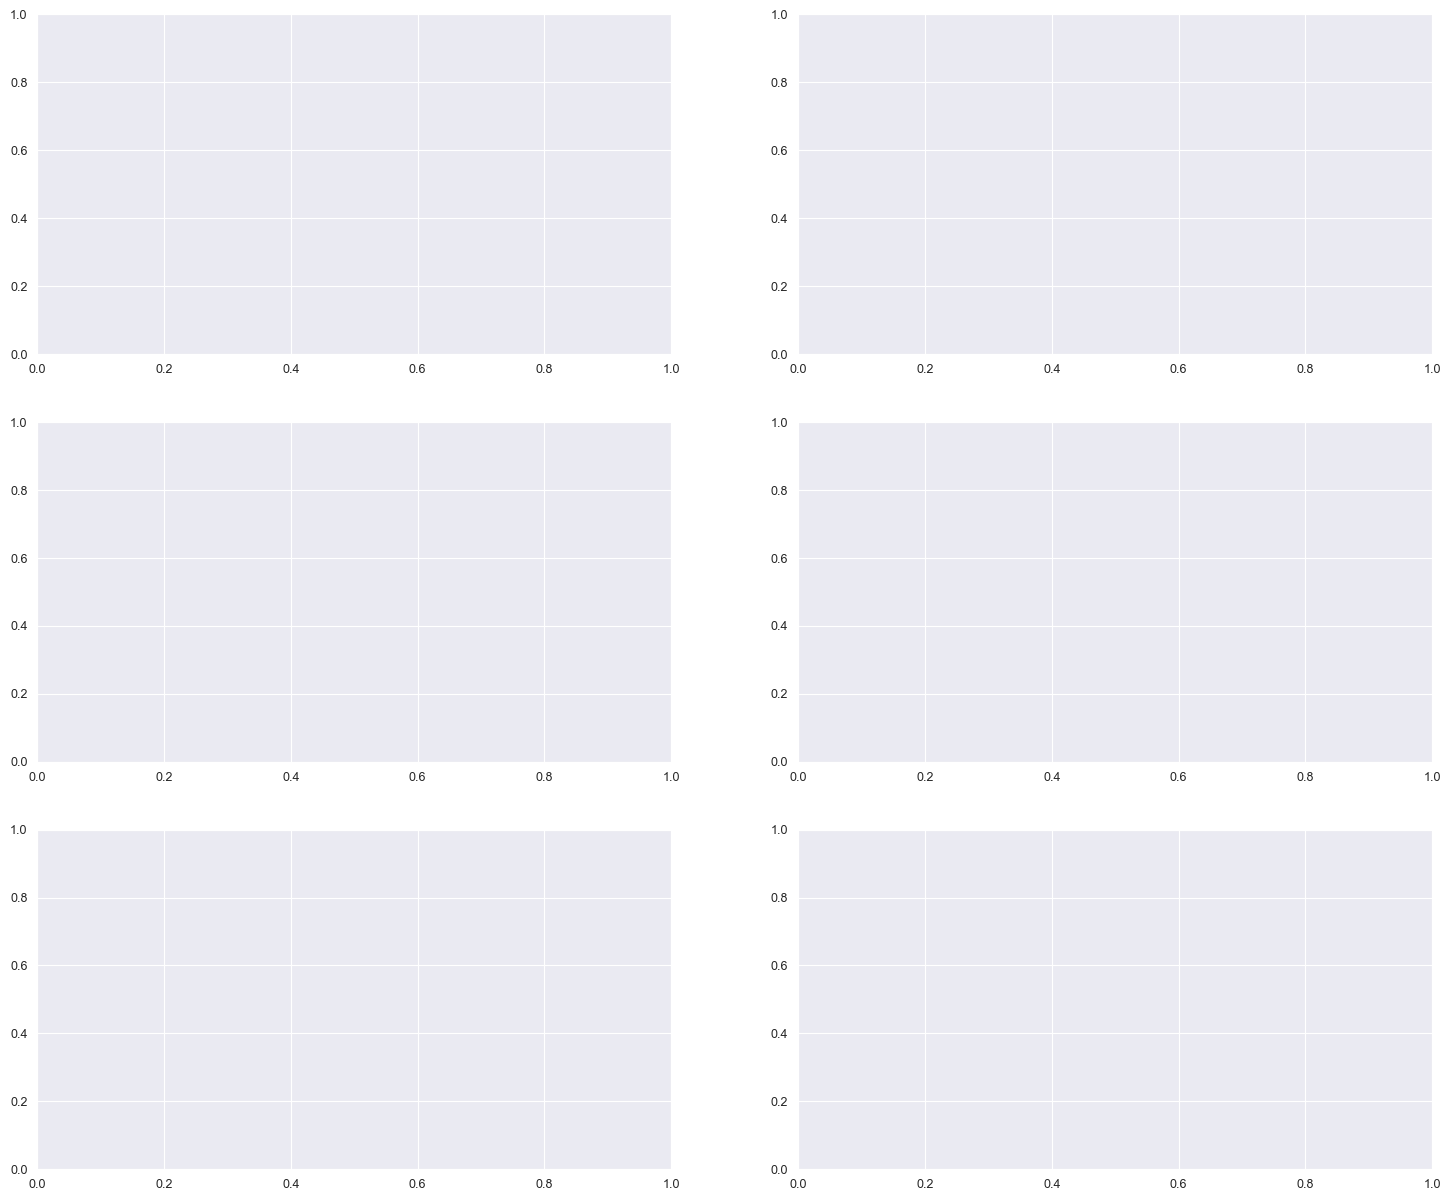

In [1507]:
size_mult = 1.5
plt.rc('axes', titlesize=6*size_mult)     # fontsize of the axes title
plt.rc('axes', labelsize=6*size_mult)    # fontsize of the x and y axes labels
plt.rc('xtick', labelsize=6*size_mult)    # fontsize of the tick labels
plt.rc('ytick', labelsize=6*size_mult)    # fontsize of the tick labels
plt.rc('legend', fontsize=5*size_mult)    # legend fontsize
plt.rc('figure', titlesize=9*size_mult)  # fontsize of the figure title

print('Experiment ID:', exp_info['EXPERIMENT_NAME'])
    
fig, axes, mu_dfs, w_dfs, perf_dfs = plot_source_fair_irl_comparisons(
    feat_objective_set_names=base_exp_info['FEAT_EXP_OBJECTIVE_NAMES'],
#     perf_objective_set_names=base_exp_info['PERF_MEAS_OBJECTIVE_NAMES'],
    perf_objective_set_names=[
        'Acc',
#         'AccPar',
        'DemPar',
        'EqOpp',
        'FPRPar',
        'TNRPar',
#         'FNRPar',
#         'PR_Z0',
#         'PR_Z1',
#         'NR_Z0',
#         'NR_Z1'
#         'TPR_Z0',
#         'TPR_Z1',
#         'TNR_Z0',
#         'TNR_Z1',
#         'FPR_Z0',
#         'FPR_Z1',
#         'FNR_Z0',
#         'FNR_Z1',
        'PredPar',
#         'OppPredPar',
    ],
    expert_algos=[
        'OptAcc',
#         'COMPAS',
        'HardtDemPar',
        'HardtEqOpp',
#         'HardtTNRPar',
#         'RedBoundedGroupLoss',
    ],
    dataset=exp_info['DATASET'],
    demo_producers=[
        'muE',  # source
        'muL (FairIRL)',  # source
    ],
    mu_noise_factor=0,
    perf_noise_factor=0,
    w_noise_factor=0,
    mu_hue_order=[
        'muE',
        'muL (FairIRL)',
        'muL (Beh Clone)',
#         None,
#         None,
#         'muL (FairIRLFO)',
    ],
    perf_hue_order=[
        'Expert',
        'Learned (FairIRL)',
        'Learned (Beh Clone)',
#         None,
#         None,
    ],
    w_hue_order=[
        None,
        'wL (FairIRL)',
#         None,
#         'wL (FairIRLFO)',
    ],
    extra_skip_conditions=skip_by_name,
    min_exp_timestamp=min_exp_timestamp,
    mu_yticks=np.linspace(0, 1, 11).round(1),
    mu_ylim=(0, 1.02),
    mu_whis=[1, 99],
    w_yticks = np.linspace(-1, 1, 21).round(1),
    w_ylim=(-.2, .32),
    perf_ylim=(.45, 1.05),
    perf_yticks=np.linspace(.5, 1, 6).round(1),
    size_mult=size_mult,
    palette=[cp[4], cp[9], cp[6], cp[8]],
    figsize=(18, 15),
)

rotation = 67.5
if len(np.shape(axes)) > 1:
    for ax_i, _ in enumerate(axes[0]):
        axes[0][ax_i].tick_params(axis='x', rotation=rotation)
        axes[1][ax_i].tick_params(axis='x', rotation=rotation)
        axes[2][ax_i].tick_params(axis='x', rotation=rotation)
else:
    axes[0].tick_params(axis='x', rotation=rotation)
    axes[1].tick_params(axis='x', rotation=rotation)
    axes[2].tick_params(axis='x', rotation=rotation)


# Compare results with target domain

### Compare each expert's demo vs learned

Experiment ID: adult_to_boston_jan8_44
2024-01-12 07:14:22.csv HardtDemPar Beh Clone 1 result rows
2024-01-12 07:25:43.csv HardtDemPar Beh Clone 1 result rows
2024-01-12 07:26:20.csv HardtDemPar FairIRL 1 result rows
2024-01-12 07:29:56.csv HardtDemPar Beh Clone 1 result rows
2024-01-12 07:30:31.csv HardtDemPar FairIRL 1 result rows
2024-01-12 07:34:31.csv HardtDemPar Beh Clone 1 result rows
2024-01-12 07:35:09.csv HardtDemPar FairIRL 1 result rows
2024-01-12 07:46:01.csv HardtDemPar Beh Clone 3 result rows
2024-01-12 07:47:49.csv HardtDemPar FairIRL 1 result rows
2024-01-12 07:58:26.csv HardtDemPar Beh Clone 20 result rows
2024-01-12 08:12:08.csv HardtDemPar FairIRL 12 result rows
2024-01-16 08:53:10.csv HardtDemPar Beh Clone 5 result rows
2024-01-16 08:56:54.csv HardtDemPar FairIRL 5 result rows
2024-01-16 09:02:41.csv HardtDemPar Beh Clone 5 result rows
2024-01-16 09:05:52.csv HardtDemPar FairIRL 3 result rows
2024-01-12 07:14:49.csv HardtEqOpp Beh Clone 1 result rows
2024-01-12 07:

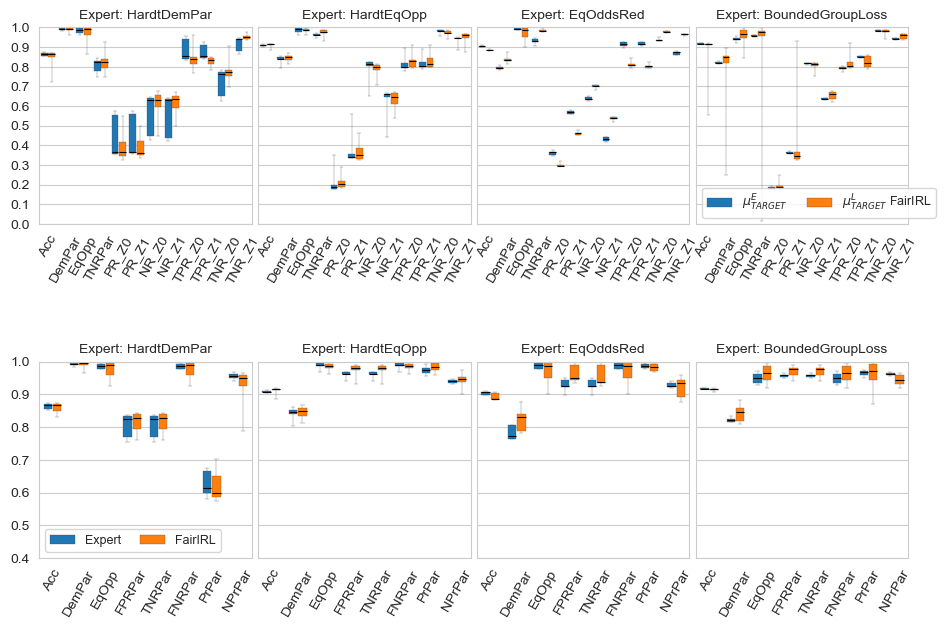

In [683]:
## plt.rc('axes', titlesize=11)     # fontsize of the axes title
size_mult = 1.
sns.set_style('whitegrid')
plt.rc('axes', titlesize=10*size_mult)     # fontsize of the axes title
plt.rc('axes', labelsize=10*size_mult)    # fontsize of the x and y axes labels
plt.rc('xtick', labelsize=10*size_mult)    # fontsize of the tick labels
plt.rc('ytick', labelsize=10*size_mult)    # fontsize of the tick labels
plt.rc('legend', fontsize=9*size_mult)    # legend fontsize
plt.rc('figure', titlesize=10*size_mult)  # fontsize of the figure title

print('Experiment ID:', exp_info['EXPERIMENT_NAME'])

fig, axes, mu_dfs, w_dfs, perf_dfs = plot_results_target_domain(
    feat_objective_set_names=exp_info['FEAT_EXP_OBJECTIVE_NAMES'],
#     perf_objective_set_names=base_exp_info['PERF_MEAS_OBJECTIVE_NAMES'],
    perf_objective_set_names=[
        'Acc',
        'DemPar',
        'EqOpp',
        'FPRPar',
        'TNRPar',
        'FNRPar',
#         'PR_Z0',
#         'PR_Z1',
#         'NR_Z0',
#         'NR_Z1'
#         'TPR_Z0',
#         'TPR_Z1',
#         'TNR_Z0',
#         'TNR_Z1',
#         'FPR_Z0',
#         'FPR_Z1',
#         'FNR_Z0',
#         'FNR_Z1',
        'PredPar',
        'NegPredPar',
    ],
#     expert_algos=np.unique([exp['EXPERT_ALGO'] for exp in experiments]),
    expert_algos=[
#         'OptAcc',
        'HardtDemPar',
        'HardtEqOpp',
        'HardtEqOdds',
        'BoundedGroupLoss',
#         'COMPAS',
    ],
    source_dataset=experiments[-1]['DATASET'],
    target_dataset=experiments[-1]['TARGET_DATASET'],
#     source_dataset=None,
#     target_dataset=None,
    mu_noise_factor=0,
    extra_skip_conditions=skip_by_name,
    min_exp_timestamp=min_exp_timestamp,
    mu_yticks=np.linspace(0, 1, 11).round(1),
    mu_ylim=(0, 1.0),
    mu_whis=[1, 99],
    perf_noise_factor=0,
    perf_ylim=(.4, 1),
    perf_yticks=np.linspace(0, 1, 11).round(2),
    size_mult=size_mult,
    mu_hue_order=[  
#         'muE',
        'muE_target',
#         'muL (FairIRL)',
#         'muL (FairIRLFO)',
        'muL_target FairIRL',

    ],
    perf_hue_order=[
#         'Expert (source)',
        'Expert (target)',
        'FairIRL Learned (target)',
#         'Beh Clone Learned (target)',
    ],
    figsize=(10, 6),
    perf_leg_ax=0,
)

rotation = 60
if len(np.shape(axes)) > 1:
    for ax_i, _ in enumerate(axes[0]):
        axes[0][ax_i].tick_params(axis='x', rotation=rotation)
        axes[1][ax_i].tick_params(axis='x', rotation=rotation)
else:
    axes[0].tick_params(axis='x', rotation=rotation)
    axes[1].tick_params(axis='x', rotation=rotation)
    
    
for i, label in enumerate(axes[1][0].get_legend().get_texts()):
    text = label.get_text()
    label.set_text(text.replace(' (target)', '').replace(' Learned', ''))
    
for i, _ in enumerate(axes[0]):
    labels = [item.get_text() for item in axes[0][i].get_xticklabels()]
#     labels[1] = labels[1].replace('DemPar', 'PRPar')
#     labels[2] = labels[2].replace('EqOpp', 'TPRPar')
    axes[0][i].set_xticklabels(labels)
    
for i, _ in enumerate(axes[1]):
    labels = [item.get_text() for item in axes[1][i].get_xticklabels()]
#     labels[1] = labels[1].replace('DemPar', 'PRPar')
#     labels[2] = labels[2].replace('EqOpp', 'TPRPar')
    labels[-2] = labels[-2].replace('PredPar', 'PrPar')
    labels[-1] = labels[-1].replace('NegPredPar', 'NPrPar')
    axes[1][i].set_xticklabels(labels)
    
for ax_i, ax in enumerate(axes):
    for plot_i, plot in enumerate(ax):
        title = plot.get_title()
        plot.set_title(title.replace('HardtEqOdds', 'EqOddsRed'))   

### Compare just IRL learned policies

Experiment ID: adult_to_boston_jan8_44


ValueError: No results for provided config.

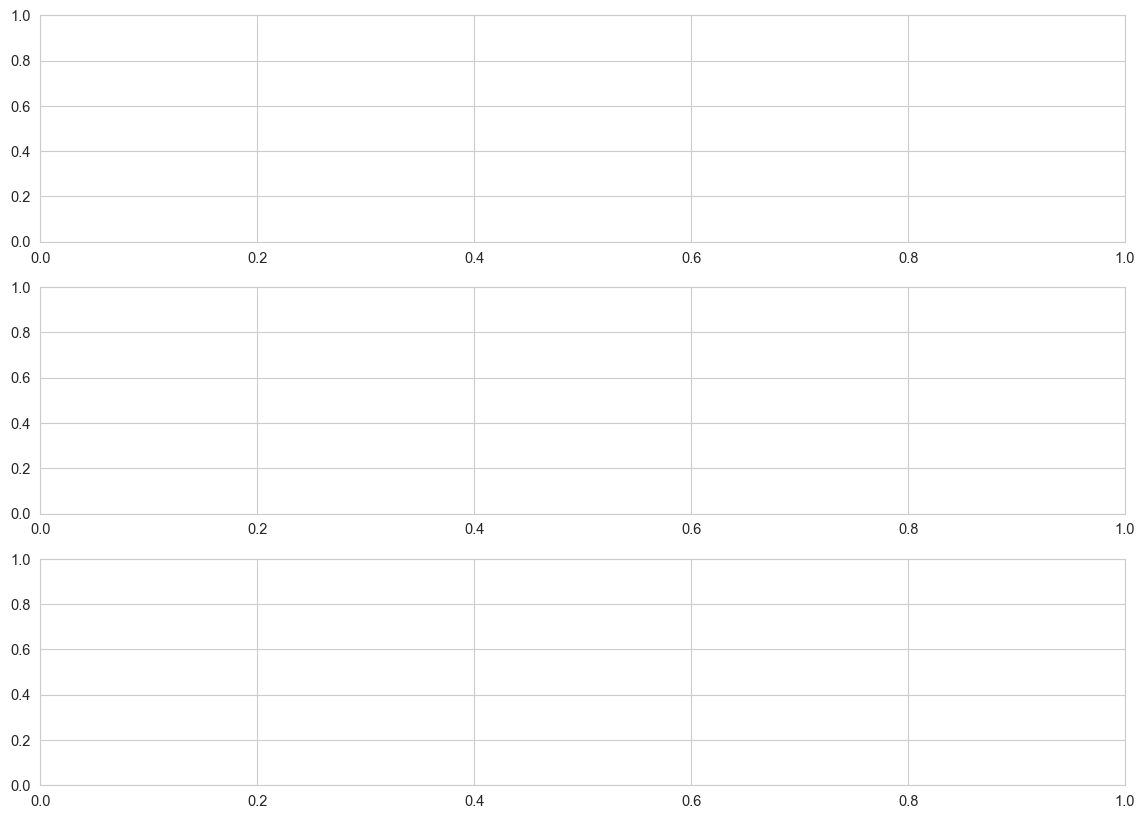

In [1866]:
size_mult = 1.5
plt.rc('axes', titlesize=9*size_mult)     # fontsize of the axes title
plt.rc('axes', labelsize=9*size_mult)    # fontsize of the x and y axes labels
plt.rc('xtick', labelsize=7*size_mult)    # fontsize of the tick labels
plt.rc('ytick', labelsize=7*size_mult)    # fontsize of the tick labels
plt.rc('legend', fontsize=6*size_mult)    # legend fontsize
plt.rc('figure', titlesize=9*size_mult)  # fontsize of the figure title

print('Experiment ID:', exp_info['EXPERIMENT_NAME'])
    
fig, axes, mu_dfs, w_dfs, perf_dfs = plot_target_fair_irl_comparisons(
    feat_objective_set_names=exp_info['FEAT_EXP_OBJECTIVE_NAMES'],
    perf_objective_set_names=exp_info['PERF_MEAS_OBJECTIVE_NAMES'],
    expert_algos=[
        'OptAcc',
        'COMPAS',
        'HardtDemPar',
        'HardtEqOpp',
#         'HardtTNRPar',
#         'RedBoundedGroupLoss',
    ],
    dataset=exp_info['DATASET'],
    feat_demo_producers=[
#         'muE',
#         'muE_target',
#         'muL_source FairIRL',
        'muL_target FairIRL',
    ],
    perf_demo_producers=[
        'Acc',
#         'AccPar',
        'DemPar',
        'EqOpp',
        'FPRPar',
        'TNRPar',
#         'FNRPar',
#         'PR_Z0',
#         'PR_Z1',
#         'NR_Z0',
#         'NR_Z1'
#         'TPR_Z0',
#         'TPR_Z1',
#         'TNR_Z0',
#         'TNR_Z1',
#         'FPR_Z0',
#         'FPR_Z1',
#         'FNR_Z0',
#         'FNR_Z1',
        'PredPar',
#         'OppPredPar',
    ],
    w_demo_producers=[
      'wL (FairIRL)',
    ],
    mu_noise_factor=.001,
    perf_noise_factor=.001,
    w_noise_factor=.001,
    mu_hue_order=[
        'muE',
        'muL (FairIRL)',
        'muL (Beh Clone)',
#         None,
#         None,
#         'muL (FairIRLFO)',
    ],
    perf_hue_order=['muE', 'muL (FairIRL)', 'muL (FairIRLFO)'],
    w_hue_order=[None, 'wL (FairIRL)', 'wL (FairIRLFO)'],
    extra_skip_conditions=skip_by_name,
    min_exp_timestamp=min_exp_timestamp,
    max_mu_value=1,
    min_w_value=-.05,
    mu_yticks=np.linspace(0, 1, 11).round(1),
    mu_ylim=(0, 1.05),
    mu_whis=[1, 99],
    w_yticks = np.linspace(-1, 1, 101).round(1),
    w_ylim=(-.05, .35),
    perf_ylim=(.45, 1.05),
    perf_yticks=np.linspace(0, 1, 11).round(1),
    size_mult=size_mult,
    figsize=(14, 10)
)
print(f"Source Dataset: {exp_info['DATASET']}")
print(f"Target Dataset: {exp_info['TARGET_DATASET']}")

# Scratch

In [170]:
exp_info = dict(base_exp_info)
exp_info['FEAT_EXP_OBJECTIVE_NAMES'] = [
    'TPR_Z0', 'TPR_Z1',
#     'TNR_Z0', 'TNR_Z1',
    'FPR_Z0', 'FPR_Z1',
#     'FNR_Z0', 'FNR_Z1',
#     'Acc',
#     'DemPar',
#     'EqOpp',
#     'PredPar',
]
exp_info['RESTRICT_Y_ACTION'] = True

X, y, ft = generate_compas_dataset(20_000)
# X, y, ft = generate_adult_dataset(20_000)

# Initiate objectives
objectives = []
for obj_name in exp_info['FEAT_EXP_OBJECTIVE_NAMES']:
    objectives.append(OBJ_LOOKUP_BY_NAME[obj_name]())
feat_obj_set = ObjectiveSet(objectives)
del objectives
# Reset the objective set since they get fitted in each trial run
feat_obj_set.reset()


X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=.2,
)
del X, y


# Fit a classifier that predicts `y` from `X`.
clf = sklearn_clf_pipeline(
    feature_types=ft,
    clf_inst=RandomForestClassifier(),
)
clf.fit(X_train, y_train)

# Initiate variables needed to run IRL Loop
x_cols = (
    ft['boolean']
    + ft['categoric']
    + ft['continuous']
)
x_cols.remove('z')

# wi = [.2, .3, -.15, -.2]  # .598, .881, .906
# wi = [.195, .22, -.205, -.17]  # .608, .984, .994
wi = [.2, .3, .15, .2]  # .598, .881, .906
# wi = [.9, .02, .02]


reward_weights = { obj.name: wi[j] for j, obj in enumerate(feat_obj_set.objectives) }

test_df = X_test.copy()
test_df['y'] = y_test
# test_df = X_train.copy()
# test_df['y'] = y_train
# test_df['y'] = clf.predict(X_test)

clf_pol = compute_optimal_policy(
    clf_df=test_df,  # NOT the dataset used to train the C_{Y_Z,X} clf
    clf=clf,
    x_cols=x_cols,
    obj_set=feat_obj_set,
    reward_weights=reward_weights,
    skip_error_terms=True,
    method=exp_info['METHOD'],
    min_freq_fill_pct=exp_info['MIN_FREQ_FILL_PCT'],
)

demo = generate_demo(clf_pol, X_train, y_train, can_observe_y=False)
muj = feat_obj_set.compute_demo_feature_exp(demo)
print(f"\t\t muL = {np.round(muj, 3)}")


print('Acc', AccuracyObjective().compute_feat_exp(demo).round(3))
print('DemPar', DemographicParityObjective().compute_feat_exp(demo).round(3))
print('EqOpp', EqualOpportunityObjective().compute_feat_exp(demo).round(3))

display(demo.groupby(['z', 'y'])[['yhat']].agg(['count', 'mean', 'sum']))
display(demo.groupby(['z'])[['yhat']].agg(['count', 'mean', 'sum']))

		 muL = [0.748 0.776 0.503 0.396]
Acc 0.605
DemPar 0.947
EqOpp 0.972


yhat                  
    count      mean     sum
z y                        
0 0  4608  0.496745  2289.0
  1  4768  0.748112  3567.0
1 0  2650  0.604151  1601.0
  1  1970  0.776142  1529.0

yhat                  
  count      mean     sum
z                        
0  9376  0.624573  5856.0
1  4620  0.677489  3130.0

# HW Scratch

In [11]:
from math import comb
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

### Problem 1

In [28]:
def expected_4_cliques(n, p):
    return comb(n, 4) * p**6

In [45]:
def thresh_4_clique(n):
    return comb(n, 4)**(-(1/6))

In [120]:
expected_4_cliques(int(1e15), p=1e-9)

41666.66666666643

100000 0.0007883266647717149
1000000 0.0001698383027949114
10000000 3.659052019222436e-05


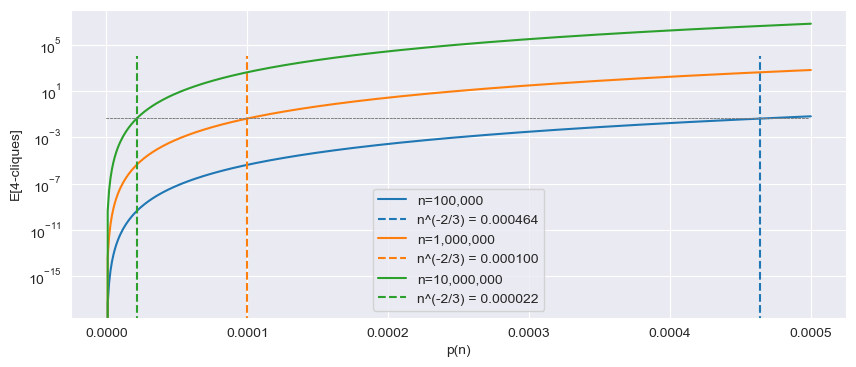

In [237]:
sns.set_style('darkgrid')
fig, ax = plt.subplots(1, 1, figsize=(10, 4))
cp = sns.color_palette()

for i, n in enumerate([100_000, 1_000_000, 10_000_000]):
    x = np.linspace(0, .0005, 501)
    y = [expected_4_cliques(n, p) for p in x]
    ax.plot(x, y, label=f"n={n:,}", c=cp[i])
    ax.set_xlabel('p(n)')
    ax.set_ylabel('E[4-cliques]')
    print(n, thresh_4_clique(n))
    
    thresh = n**(-2/3)
    threshx = [thresh for _ in range(10)]
    threshy = np.linspace(0, 1e4, 10)
    ax.plot(threshx, threshy, ls='--', label=f"n^(-2/3) = {thresh:.6f}", c=cp[i])
    
    x2 = np.linspace(0, .95*ax.get_xlim()[1], 2)
    y2 = .05*np.ones(2)
    ax.plot(x2, y2, ls='--', lw=.5, c='gray')

# ax.set_xscale('log')
ax.set_yscale('log')
ax.legend()
pass

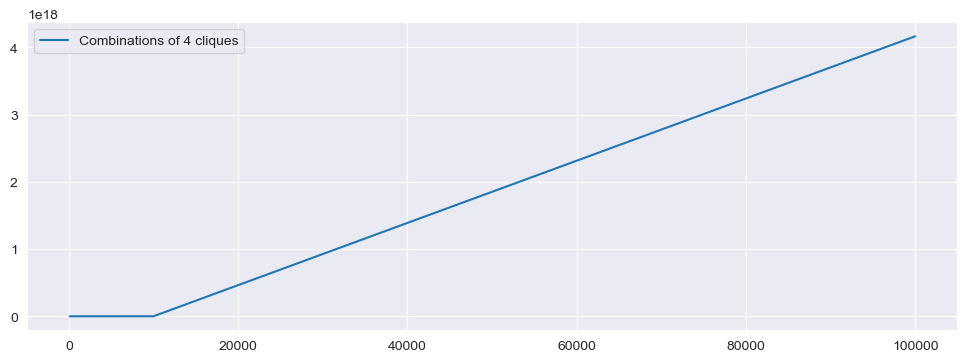

In [95]:
fig, ax = plt.subplots(1, 1, figsize=(12, 4))
x1 = [100, 1_000, 10_000, 100_000]
y1 = [comb(n, 4) for n in x1]
x2 = np.linspace(0, 1, 101)
y2 = [p**6 for p in x2]
ax.plot(x1, y1, label='Combinations of 4 cliques')
# ax.plot(x2, y2, label='p^6(n)')
ax.legend()

In [42]:
comb(1000, 4) * 2**(-(comb(4, 2)))

647142574.21875

In [43]:
2**(-(comb(4, 2)))

0.015625

### Problem 4

In [157]:
def prob_vertex_has_deg_k(n, k, p):
    return comb(n, k) * (p**k) * (1-p)**(n-k)

In [197]:
k_range = [
    3,
    int(np.log(n)),
    int(np.sqrt(n)),
    int(n-1),
]
n = 1_000
d = 100
p = d / n

for k in k_range:
    output = n * comb(n, k) * (p**k)
    print(k, ':', output)

3 : 166167000.00000003
6 : 1368173298991.5005
31 : 7.602322407769473e+30
999 : 0.0
